<a href="https://colab.research.google.com/github/Fridmanette/Analyzing-Academic-Success-Predictive-Modeling-and-Statistical-Analysis-of-High-School-Students-Pe/blob/main/Instacart_Customer_Behavior_Analysis_and_Recommendation_System_Machine_Learning_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive mounted successfully!")


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install sparksql-magic

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
# Install findspark
!pip install -q findspark

# Import findspark and initialize it
import findspark
findspark.init()

# Import PySpark modules
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SQLContext

# Create a Spark session with necessary configurations
spark = SparkSession.builder \
    .appName('Instacart_Market_Basket_Analysis') \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory', '8G') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .getOrCreate()

# Suppress Spark logs for a cleaner output
spark.sparkContext.setLogLevel("ERROR")

# Create an SQL context for running Spark SQL queries
sqlContext = SQLContext(spark)

# Confirm that the Spark session is set up correctly
print("Spark session created successfully!")

Spark session created successfully!


In [ ]:
# Defining file paths for the datasets
orders_path = 'file_name'
products_path = 'file_name'
aisles_path = 'file_name'
departments_path = 'file_name'
order_products_prior_path = 'file_name'
order_products_train_path = 'file_name'

# Loading the CSV files into Spark DataFrames
file_type = "csv"

orders_df = spark.read.format(file_type).option("header", "true").load(orders_path)
products_df = spark.read.format(file_type).option("header", "true").load(products_path)
aisles_df = spark.read.format(file_type).option("header", "true").load(aisles_path)
departments_df = spark.read.format(file_type).option("header", "true").load(departments_path)
order_products_prior_df = spark.read.format(file_type).option("header", "true").load(order_products_prior_path)
order_products_train_df = spark.read.format(file_type).option("header", "true").load(order_products_train_path)

# Displaying first few rows
print("Loaded DataFrames:")
orders_df.show(5)
products_df.show(5)
aisles_df.show(5)
departments_df.show(5)
order_products_prior_df.show(5)
order_products_train_df.show(5)

# Casting columns to appropriate data types
orders_df = orders_df.withColumn("order_id", col("order_id").cast("int")) \
                     .withColumn("user_id", col("user_id").cast("int")) \
                     .withColumn("order_number", col("order_number").cast("int")) \
                     .withColumn("order_dow", col("order_dow").cast("int")) \
                     .withColumn("order_hour_of_day", col("order_hour_of_day").cast("int")) \
                     .withColumn("days_since_prior_order", col("days_since_prior_order").cast("float"))

products_df = products_df.withColumn("product_id", col("product_id").cast("int")) \
                         .withColumn("aisle_id", col("aisle_id").cast("int")) \
                         .withColumn("department_id", col("department_id").cast("int"))

order_products_prior_df = order_products_prior_df.withColumn("order_id", col("order_id").cast("int")) \
                                                 .withColumn("product_id", col("product_id").cast("int")) \
                                                 .withColumn("add_to_cart_order", col("add_to_cart_order").cast("int")) \
                                                 .withColumn("reordered", col("reordered").cast("int"))

aisles_df = aisles_df.withColumn("aisle_id", aisles_df["aisle_id"].cast("int"))
departments_df = departments_df.withColumn("department_id", departments_df["department_id"].cast("int"))

Loaded DataFrames:
+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
| 2539329|      1|   prior|           1|        2|               08|                  null|
| 2398795|      1|   prior|           2|        3|               07|                  15.0|
|  473747|      1|   prior|           3|        3|               12|                  21.0|
| 2254736|      1|   prior|           4|        4|               07|                  29.0|
|  431534|      1|   prior|           5|        4|               15|                  28.0|
+--------+-------+--------+------------+---------+-----------------+----------------------+
only showing top 5 rows

+----------+--------------------+--------+-------------+
|product_id|        product_name|aisle_id|department_id|
+----------+--

In [ ]:
# Summary and Descriptive Analysis of Datasets
from pyspark.sql.functions import col, min, max, count, countDistinct, mean

def describe_dataframe(df, df_name):
    """Displays basic information and summary statistics for a DataFrame."""
    print(f"\n--- Summary for {df_name} DataFrame ---")

    # Counting total number of rows
    total_rows = df.count()
    print(f"Total rows: {total_rows}")

    # Showing column names and data types
    print("Schema:")
    df.printSchema()

    # Displaying descriptive statistics for numerical columns
    print("\nDescriptive statistics:")
    df.describe().show()

    # Displaying min and max values for numerical columns
    numeric_cols = [c for c, t in df.dtypes if t in ['int', 'double', 'float']]
    if numeric_cols:
        df.select([min(col(c)).alias(f"{c}_min") for c in numeric_cols] +
                  [max(col(c)).alias(f"{c}_max") for c in numeric_cols]).show()
    else:
        print("No numerical columns to display min/max.")

# Applying descriptive summary to each DataFrame
describe_dataframe(orders_df, "orders")
describe_dataframe(products_df, "products")
describe_dataframe(aisles_df, "aisles")
describe_dataframe(departments_df, "departments")
describe_dataframe(order_products_prior_df, "order_products_prior")
describe_dataframe(order_products_train_df, "order_products_train")


--- Summary for orders DataFrame ---
Total rows: 3421083
Schema:
root
 |-- order_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- eval_set: string (nullable = true)
 |-- order_number: integer (nullable = true)
 |-- order_dow: integer (nullable = true)
 |-- order_hour_of_day: integer (nullable = true)
 |-- days_since_prior_order: float (nullable = true)


Descriptive statistics:
+-------+-----------------+------------------+--------+------------------+------------------+-----------------+----------------------+
|summary|         order_id|           user_id|eval_set|      order_number|         order_dow|order_hour_of_day|days_since_prior_order|
+-------+-----------------+------------------+--------+------------------+------------------+-----------------+----------------------+
|  count|          3421083|           3421083| 3421083|           3421083|           3421083|          3421083|               3214874|
|   mean|        1710542.0|102978.20805926077|    nu

In [ ]:
# Identifying Null values
from pyspark.sql.functions import when, col, trim, regexp_replace, count

# Initial check for null values in all DataFrames
print("Initial check for null values:")
dataframes = [
    (orders_df, "orders"),
    (products_df, "products"),
    (aisles_df, "aisles"),
    (departments_df, "departments"),
    (order_products_prior_df, "order_products_prior"),
    (order_products_train_df, "order_products_train")
]

# Looping through each DataFrame and displaying the count of null values in each column
for df, name in dataframes:
    print(f"\nNull values in {name} DataFrame:")
    df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

Initial check for null values:

Null values in orders DataFrame:
+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
|       0|      0|       0|           0|        0|                0|                206209|
+--------+-------+--------+------------+---------+-----------------+----------------------+


Null values in products DataFrame:
+----------+------------+--------+-------------+
|product_id|product_name|aisle_id|department_id|
+----------+------------+--------+-------------+
|         0|           0|       1|            1|
+----------+------------+--------+-------------+


Null values in aisles DataFrame:
+--------+-----+
|aisle_id|aisle|
+--------+-----+
|       0|    0|
+--------+-----+


Null values in departments DataFrame:
+-------------+----------+
|depar

In [ ]:
# Identifying and Resolving Buying Pattern Inconsistencies

from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Adding a column to label each observation based on the given rules
full_df = orders_df.join(order_products_prior_df, on="order_id", how="inner")

# Labeling observations based on the rules
full_df = full_df.withColumn(
    "buying_pattern",
    F.when((F.col("days_since_prior_order") == 0) & (F.col("reordered") == 1), "same_day_multi_orders")
    .when((F.col("days_since_prior_order") == 0) & (F.col("reordered") == 0), "true_single_time_buyers")
    .when((F.col("days_since_prior_order") != 0) & (F.col("reordered") == 1), "multi_time_buyers")
    .when((F.col("days_since_prior_order") != 0) & (F.col("reordered") == 0), "inconsistent_observations")
    .otherwise("missing_data")
)

# Defining a Window specification for calculating the total count across all rows
window_spec = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

# Calculating the distribution of buying patterns
distribution_df = full_df.groupBy("buying_pattern").agg(
    F.count("*").alias("count")
).withColumn(
    "percentage",
    (F.col("count") / F.sum("count").over(window_spec) * 100)
)

# Displaying the distribution
print("Distribution of Buying Patterns:")
distribution_df.orderBy(F.desc("count")).show(truncate=False)

# Investigating and resolving inconsistencies for `inconsistent_observations`
# Create a window to order user orders by `order_number`
user_order_window = Window.partitionBy("user_id").orderBy("order_number")

# Adding columns for the next order_id and next order_number for each user
orders_with_lead = orders_df.withColumn(
    "next_order_id", F.lead("order_id", 1).over(user_order_window)
).withColumn(
    "next_order_number", F.lead("order_number", 1).over(user_order_window)
)

# Joining `orders_with_lead` with `order_products_prior_df` to combine order details
orders_with_reordered_flag = orders_with_lead.join(order_products_prior_df, on="order_id", how="inner")

# Filtering for inconsistencies
potential_inconsistencies = orders_with_reordered_flag.filter(
    (F.col("days_since_prior_order") != 0) & (F.col("reordered") == 0)
)

# Correcting the `reordered` flag where inconsistencies are identified
corrected_reordered = potential_inconsistencies.withColumn(
    "corrected_reordered",
    F.when(
        (F.col("next_order_id").isNotNull()) & (F.col("next_order_number").isNotNull()),
        1
    ).otherwise(F.col("reordered"))
)

# Replacing the `reordered` flag in the original DataFrame with corrected values
orders_with_corrected_reordered = orders_with_reordered_flag.join(
    corrected_reordered.select("order_id", "corrected_reordered"),
    on="order_id",
    how="left"
).withColumn(
    "reordered",
    F.when(F.col("corrected_reordered").isNotNull(), F.col("corrected_reordered")).otherwise(F.col("reordered"))
).drop("corrected_reordered")

# Validating changes by displaying a sample
print("Sample of corrected 'reordered' values:")
orders_with_corrected_reordered.select(
    "order_id", "user_id", "order_number", "days_since_prior_order", "reordered"
).show(10, truncate=False)

# Validating remaining inconsistencies
final_inconsistencies = orders_with_corrected_reordered.filter(
    (F.col("days_since_prior_order") != 0) & (F.col("reordered") == 0)
)
print(f"Remaining inconsistencies: {final_inconsistencies.count()}")

Distribution of Buying Patterns:
+-------------------------+--------+-------------------+
|buying_pattern           |count   |percentage         |
+-------------------------+--------+-------------------+
|multi_time_buyers        |18795057|57.947751234804414 |
|inconsistent_observations|11112666|34.26188092557894  |
|missing_data             |2078068 |6.406970062022559  |
|same_day_multi_orders    |331479  |1.0219954444172068 |
|true_single_time_buyers  |117219  |0.36140233317688464|
+-------------------------+--------+-------------------+

Sample of corrected 'reordered' values:
+--------+-------+------------+----------------------+---------+
|order_id|user_id|order_number|days_since_prior_order|reordered|
+--------+-------+------------+----------------------+---------+
|148     |41523  |27          |5.0                   |1        |
|148     |41523  |27          |5.0                   |1        |
|148     |41523  |27          |5.0                   |1        |
|148     |41523  |27   

Logic for Mapping dominant_pattern:

same_day_multi_orders → 1

true_single_time_buyers → 2

multi_time_buyers → 3

inconsistent_observations → 4

missing_data → 5

In [ ]:
# Labeling Users Based on Dominant Buying Patterns

# Step 1: Grouping by user_id and buying_pattern to count occurrences
user_pattern_counts = full_df.groupBy("user_id", "buying_pattern").count()

# Step 2: Find the dominant pattern for each user
from pyspark.sql.window import Window

window = Window.partitionBy("user_id").orderBy(F.desc("count"))
dominant_pattern_df = user_pattern_counts.withColumn(
    "rank", F.row_number().over(window)
).filter(F.col("rank") == 1).drop("rank")

# Step 3: Mapping buying patterns to numerical values
pattern_mapping = {
    "same_day_multi_orders": 1,
    "true_single_time_buyers": 2,
    "multi_time_buyers": 3,
    "inconsistent_observations": 4,
    "missing_data": 5,
}

# Step 4: Adding a numeric column for the dominant pattern
dominant_pattern_df = dominant_pattern_df.withColumn(
    "dominant_pattern_numeric",
    F.expr(
        f"CASE buying_pattern "
        + " ".join([f"WHEN '{k}' THEN {v}" for k, v in pattern_mapping.items()])
        + " END"
    ).cast("int")
)

# Displaying results
print("User labeling with numeric dominant buying patterns:")
dominant_pattern_df.show(10, truncate=False)

User labeling with numeric dominant buying patterns:
+-------+-------------------------+-----+------------------------+
|user_id|buying_pattern           |count|dominant_pattern_numeric|
+-------+-------------------------+-----+------------------------+
|148    |inconsistent_observations|46   |4                       |
|463    |inconsistent_observations|57   |4                       |
|471    |inconsistent_observations|61   |4                       |
|496    |multi_time_buyers        |335  |3                       |
|833    |inconsistent_observations|113  |4                       |
|1088   |inconsistent_observations|126  |4                       |
|1238   |multi_time_buyers        |188  |3                       |
|1342   |multi_time_buyers        |21   |3                       |
|1580   |multi_time_buyers        |36   |3                       |
|1591   |inconsistent_observations|15   |4                       |
+-------+-------------------------+-----+------------------------+
only show

In [ ]:
# Handling Missing Values and Validating DataFrames
# Step 1: Handling missing `days_since_prior_order` in `orders_df`
median_days_orders = orders_df.filter(F.col("days_since_prior_order").isNotNull()) \
    .approxQuantile("days_since_prior_order", [0.5], 0.01)[0]

orders_df = orders_df.withColumn(
    "days_since_prior_order",
    F.when(F.col("days_since_prior_order").isNull(), median_days_orders).otherwise(F.col("days_since_prior_order"))
)
print("Missing values in 'days_since_prior_order' in `orders_df` have been imputed with the median.")

# Step 2: Handling missing `aisle_id` and `department_id` in `products_df`
products_df = products_df.fillna({"aisle_id": -1, "department_id": -1})
print("Missing `aisle_id` and `department_id` in `products_df` have been handled.")

# Step 3: Validating `order_products_prior_df` and `order_products_train_df`
order_products_prior_df = order_products_prior_df.join(products_df, "product_id", "inner")
order_products_train_df = order_products_train_df.join(products_df, "product_id", "inner")
print("Validated `order_products_prior_df` and `order_products_train_df` for `product_id` consistency.")

# Step 4: Schema and Null Value Checks
print("\nSchemas and final check for null values after adjustments:")
dataframes = [
    (orders_df, "orders"),
    (products_df, "products"),
    (order_products_prior_df, "order_products_prior"),
    (order_products_train_df, "order_products_train"),
    (aisles_df, "aisles"),
    (departments_df, "departments")
]

for df, name in dataframes:
    print(f"\nSchema for {name} DataFrame:")
    df.printSchema()
    print(f"Null values in {name} DataFrame:")
    df.select([F.count(F.when(F.col(c).isNull(), 1)).alias(c) for c in df.columns]).show()

# Final check for `days_since_prior_order` in `orders_df`
print("\nFinal check for 'days_since_prior_order' column in `orders_df`:")
orders_df.select(F.count(F.when(F.col("days_since_prior_order").isNull(), 1)).alias("null_count")).show()

Missing values in 'days_since_prior_order' in `orders_df` have been imputed with the median.
Missing `aisle_id` and `department_id` in `products_df` have been handled.
Validated `order_products_prior_df` and `order_products_train_df` for `product_id` consistency.

Schemas and final check for null values after adjustments:

Schema for orders DataFrame:
root
 |-- order_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- eval_set: string (nullable = true)
 |-- order_number: integer (nullable = true)
 |-- order_dow: integer (nullable = true)
 |-- order_hour_of_day: integer (nullable = true)
 |-- days_since_prior_order: double (nullable = true)

Null values in orders DataFrame:
+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
|       0|      0| 

In [ ]:
# EDA after data cleaning
print("\nDescriptive Summary for Each DataFrame:")

# List of DataFrames and their names
dataframes = [
    (orders_df, "orders"),
    (products_df, "products"),
    (aisles_df, "aisles"),
    (departments_df, "departments"),
    (order_products_prior_df, "order_products_prior"),
    (order_products_train_df, "order_products_train")
]

# Looping through each DataFrame and showing a summary
for df, name in dataframes:
    print(f"\nSummary for {name} DataFrame:")
    print(f"Total rows: {df.count()}")

    # Describing the numerical columns
    numeric_columns = [field.name for field in df.schema.fields if field.dataType in [IntegerType(), FloatType()]]
    if numeric_columns:
        df.select(numeric_columns).describe().show()

    # Showing distinct counts for key columns
    print(f"Distinct values per column in {name}:")
    for column in df.columns:
        print(f"{column}: {df.select(column).distinct().count()} distinct values")


Descriptive Summary for Each DataFrame:

Summary for orders DataFrame:
Total rows: 3421083
+-------+-----------------+------------------+------------------+------------------+-----------------+
|summary|         order_id|           user_id|      order_number|         order_dow|order_hour_of_day|
+-------+-----------------+------------------+------------------+------------------+-----------------+
|  count|          3421083|           3421083|           3421083|           3421083|          3421083|
|   mean|        1710542.0|102978.20805926077|17.154857979183785|2.7762191095626734|13.45201534134074|
| stddev|987581.7398225744|59533.717793502125|17.733164470966702|2.0468291939879775|4.226088402102001|
|    min|                1|                 1|                 1|                 0|                0|
|    max|          3421083|            206209|               100|                 6|               23|
+-------+-----------------+------------------+------------------+------------------+

In [ ]:
# Joining and Enhancing DataFrames with Buying Patterns and Consistency Checks, generating full_df

from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Step 1: Ensuring consistent column types across DataFrames
orders_df = orders_df.withColumn("order_id", col("order_id").cast("int"))
order_products_prior_df = order_products_prior_df.withColumn("order_id", col("order_id").cast("int")) \
                                                 .withColumn("product_id", col("product_id").cast("int"))
products_df = products_df.withColumn("product_id", col("product_id").cast("int"))

# Step 2: Renaming columns in order_products_prior_df to avoid ambiguity
order_products_prior_df = order_products_prior_df.withColumnRenamed("aisle_id", "product_aisle_id") \
                                                 .withColumnRenamed("department_id", "product_department_id")

# Step 3: Joining orders with order_products_prior
order_details_df = orders_df.join(order_products_prior_df, "order_id", "inner")

# Step 4: Renaming columns in products, aisles, and departments DataFrames to avoid ambiguity
products_df = products_df.withColumnRenamed("product_name", "product_name_ref") \
                         .withColumnRenamed("aisle_id", "product_aisle_id_ref") \
                         .withColumnRenamed("department_id", "product_department_id_ref")
aisles_df = aisles_df.withColumnRenamed("aisle_id", "aisle_id_ref").withColumnRenamed("aisle", "aisle_name_ref")
departments_df = departments_df.withColumnRenamed("department_id", "department_id_ref").withColumnRenamed("department", "department_name_ref")

# Step 5: Joining with products, aisles, and departments DataFrames
full_df = order_details_df \
    .join(products_df, "product_id", "left") \
    .join(aisles_df, col("product_aisle_id") == col("aisle_id_ref"), "left") \
    .join(departments_df, col("product_department_id") == col("department_id_ref"), "left")

# Step 6: Adding `buying_pattern` and `dominant_pattern_numeric`
# Adding buying_pattern column
full_df = full_df.withColumn(
    "buying_pattern",
    F.when((F.col("days_since_prior_order") == 0) & (F.col("reordered") == 1), "same_day_multi_orders")
    .when((F.col("days_since_prior_order") == 0) & (F.col("reordered") == 0), "true_single_time_buyers")
    .when((F.col("days_since_prior_order") != 0) & (F.col("reordered") == 1), "multi_time_buyers")
    .when((F.col("days_since_prior_order") != 0) & (F.col("reordered") == 0), "inconsistent_observations")
    .otherwise("missing_data")
)

# Adding dominant_pattern_numeric column
pattern_mapping = {
    "same_day_multi_orders": 1,
    "true_single_time_buyers": 2,
    "multi_time_buyers": 3,
    "inconsistent_observations": 4,
    "missing_data": 5,
}
full_df = full_df.withColumn(
    "dominant_pattern_numeric",
    F.expr(
        f"CASE buying_pattern "
        + " ".join([f"WHEN '{k}' THEN {v}" for k, v in pattern_mapping.items()])
        + " END"
    ).cast("int")
)

# Step 7: Handling any remaining nulls in categorical columns
full_df = full_df.fillna({
    "product_name_ref": "Unknown",
    "aisle_name_ref": "Unknown",
    "department_name_ref": "Unknown"
})

# Step 8: Displaying a sample of the joined DataFrame
print("\nJoined DataFrame sample:")
full_df.select(
    "product_department_id", "product_aisle_id", "product_id", "order_id", "user_id",
    "eval_set", "order_number", "order_dow", "order_hour_of_day",
    "days_since_prior_order", "add_to_cart_order", "reordered",
    "product_name_ref", "aisle_name_ref", "department_name_ref",
    "buying_pattern", "dominant_pattern_numeric"
).show(5, truncate=False)

# Step 9: Checking for any remaining null values
print("\nFinal check for null values in the joined DataFrame:")
full_df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in [
        "product_department_id", "product_aisle_id", "product_id", "order_id", "user_id",
        "eval_set", "order_number", "order_dow", "order_hour_of_day",
        "days_since_prior_order", "add_to_cart_order", "reordered",
        "product_name_ref", "aisle_name_ref", "department_name_ref",
        "buying_pattern", "dominant_pattern_numeric"
    ]
]).show()

# Step 10: Displaying the total number of rows
final_row_count = full_df.count()
print(f"\nTotal rows in the final joined DataFrame: {final_row_count}")



Joined DataFrame sample:
+---------------------+----------------+----------+--------+-------+--------+------------+---------+-----------------+----------------------+-----------------+---------+-------------------------------+-----------------------+-------------------+-------------------------+------------------------+
|product_department_id|product_aisle_id|product_id|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|add_to_cart_order|reordered|product_name_ref               |aisle_name_ref         |department_name_ref|buying_pattern           |dominant_pattern_numeric|
+---------------------+----------------+----------+--------+-------+--------+------------+---------+-----------------+----------------------+-----------------+---------+-------------------------------+-----------------------+-------------------+-------------------------+------------------------+
|9                    |63              |38650     |148     |41523  |prior   |27    

In [ ]:
# Defining output path for processed DataFrames
output_path = "output_path"

# Defining a function to save a DataFrame to a CSV file
def save_dataframe_to_csv(df, file_name, output_dir=output_path):
    try:
        df.write.format("csv") \
            .option("header", "true") \
            .mode("overwrite") \
            .save(os.path.join(output_dir, file_name))
        print(f"Successfully saved {file_name} to {output_dir}")
    except Exception as e:
        print(f"Error saving {file_name}: {e}")

# Saving DataFrames to Google Drive
save_dataframe_to_csv(orders_df, "file.csv")
save_dataframe_to_csv(products_df, "file.csv")
save_dataframe_to_csv(aisles_df, "file.csv")
save_dataframe_to_csv(departments_df, "file.csv")
save_dataframe_to_csv(order_products_prior_df, "file.csv")
save_dataframe_to_csv(order_products_train_df, "file.csv")
save_dataframe_to_csv(full_df, "file.csv")

NLP

Cleaning Product Names and Merging Similar Products Using spaCy

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_md

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
import spacy
import re

In [ ]:
# Cleaning and Merging Product Names Using spaCy with Enhanced NLP and Broadcast Configuration

# Increasing broadcast timeout for large DataFrames
spark.conf.set("spark.sql.broadcastTimeout", 60000)

# Loading the spaCy model
import spacy
import re
nlp = spacy.load('en_core_web_md')

# Function to clean product names
def clean_product_name(name):
    if name:
        name = name.lower()
        # Removing common and repetitive words
        name = re.sub(r'\b(organic|fresh|new|large|small|extra|gluten-free|fat-free|pack|case|bundle|ounce|oz|lbs|bottle|can|bag|box|size|brand|classic|value|premium|natural|original)\b', '', name)
        # Normalizing similar terms
        name = name.replace('chocolate chip', 'choc chip')
        # Removing punctuation, digits, and extra spaces
        name = re.sub(r'[^\w\s]', '', name)  # Removing special characters
        name = re.sub(r'\d+', '', name)      # Removing digits
        name = re.sub(r'\s+', ' ', name).strip()  # Collapsing spaces
        return name
    return None

# Registering the updated cleaning function as a UDF
from pyspark.sql import functions as F
from pyspark.sql import types as T

clean_name_udf = F.udf(clean_product_name, T.StringType())
products_df = products_df.withColumn("cleaned_product_name", clean_name_udf(F.col("product_name")))

# Confirming column creation
print("Schema after cleaning:")
products_df.printSchema()

# Precomputing spaCy vectors for cleaned product names
unique_names_df = products_df.select("cleaned_product_name").distinct().dropna()
unique_names_list = unique_names_df.rdd.flatMap(lambda x: x).collect()

# Precomputing vectors for cleaned product names and storing in a dictionary
unique_names_nlp = {name: nlp(name) for name in unique_names_list}

# Function to find the most similar product name using precomputed vectors
def merge_similar_products(name):
    if not name:
        return name
    doc = nlp(name)
    best_match = None
    best_score = 0.0
    for unique_name, unique_doc in unique_names_nlp.items():
        similarity = doc.similarity(unique_doc)
        if similarity > best_score and similarity > 0.85: #threshold adjustable
            best_match = unique_name
            best_score = similarity
    return best_match if best_match else name

# Registering the similarity function as a UDF
merge_similar_udf = F.udf(merge_similar_products, T.StringType())

# Ensuring 'cleaned_product_name' column exists before applying the UDF
if "cleaned_product_name" in products_df.columns:
    products_df = products_df.withColumn("final_product_name", merge_similar_udf(F.col("cleaned_product_name"))).cache()
else:
    print("Error: 'cleaned_product_name' column not found!")
    raise ValueError("Column 'cleaned_product_name' not found")

# Confirming that the final product name column was added
print("Schema after applying similarity function:")
products_df.printSchema()

# Showing a few rows for verification
products_df.select("product_id", "cleaned_product_name", "final_product_name").show(5)

# Saving the processed DataFrame with spaCy results
new_output_path = "output_path"
products_df.select(
    "product_id", "product_name", "aisle_id", "department_id", "cleaned_product_name", "final_product_name"
).coalesce(1).write.mode("overwrite").option("header", "true").csv(new_output_path)

print(f"Processed products saved to: {new_output_path}")

In [ ]:
# Loading Processed Products DataFrame from spaCy Output
processed_products_path = "file_name.csv"
processed_products_df = spark.read.csv(processed_products_path, header=True, inferSchema=True)
print("Reloaded processed products DataFrame")
processed_products_df.show(5)

Reloaded processed products DataFrame
+----------+--------------------+--------+-------------+--------------------+--------------------+
|product_id|        product_name|aisle_id|department_id|cleaned_product_name|  final_product_name|
+----------+--------------------+--------+-------------+--------------------+--------------------+
|         1|Chocolate Sandwic...|      61|           19|chocolate sandwic...|chocolate sandwic...|
|         2|    All-Seasons Salt|     104|           13|     allseasons salt|     allseasons salt|
|         3|Robust Golden Uns...|      94|            7|robust golden uns...|robust golden uns...|
|         4|Smart Ones Classi...|      38|            1|smart ones favori...|smart ones favori...|
|         5|Green Chile Anyti...|       5|           13|green chile anyti...|green chile anyti...|
+----------+--------------------+--------+-------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
processed_products_df.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle_id: integer (nullable = true)
 |-- department_id: integer (nullable = true)
 |-- cleaned_product_name: string (nullable = true)
 |-- final_product_name: string (nullable = true)



In [ ]:
complete_products_df = processed_products_df
print("DataFrame renamed to 'complete_products_df'")
complete_products_df.show(5)
complete_products_df.printSchema()

DataFrame renamed to 'complete_products_df'
+----------+--------------------+--------+-------------+--------------------+--------------------+
|product_id|        product_name|aisle_id|department_id|cleaned_product_name|  final_product_name|
+----------+--------------------+--------+-------------+--------------------+--------------------+
|         1|Chocolate Sandwic...|      61|           19|chocolate sandwic...|chocolate sandwic...|
|         2|    All-Seasons Salt|     104|           13|     allseasons salt|     allseasons salt|
|         3|Robust Golden Uns...|      94|            7|robust golden uns...|robust golden uns...|
|         4|Smart Ones Classi...|      38|            1|smart ones favori...|smart ones favori...|
|         5|Green Chile Anyti...|       5|           13|green chile anyti...|green chile anyti...|
+----------+--------------------+--------+-------------+--------------------+--------------------+
only showing top 5 rows

root
 |-- product_id: integer (nullable 

In [ ]:
complete_products_df.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in complete_products_df.columns]
).show()

+----------+------------+--------+-------------+--------------------+------------------+
|product_id|product_name|aisle_id|department_id|cleaned_product_name|final_product_name|
+----------+------------+--------+-------------+--------------------+------------------+
|         0|           0|       0|            0|                   7|                 7|
+----------+------------+--------+-------------+--------------------+------------------+



In [ ]:
null_rows = complete_products_df.filter(
    (col("cleaned_product_name").isNull()) | (col("final_product_name").isNull())
)
null_rows.show(truncate=False)

+----------+-----------------+--------+-------------+--------------------+------------------+
|product_id|product_name     |aisle_id|department_id|cleaned_product_name|final_product_name|
+----------+-----------------+--------+-------------+--------------------+------------------+
|3186      |1893 Original Can|77      |7            |null                |null              |
|16016     |Brand Value Pack |118     |11           |null                |null              |
|18561     |805              |27      |5            |null                |null              |
|24356     |Bag              |100     |21           |null                |null              |
|25334     |1664             |27      |5            |null                |null              |
|28921     |Original         |37      |1            |null                |null              |
|38324     |2010             |28      |5            |null                |null              |
+----------+-----------------+--------+-------------+-------

In [ ]:
# Filtering and Validating Orders with Processed Products Data

from pyspark.sql.functions import col

# Step 1: Counting total rows in `order_products_prior_df` and `order_products_train_df` before processing
prior_orders_before = order_products_prior_df.count()
train_orders_before = order_products_train_df.count()
print(f"Total orders in `order_products_prior_df` before processing: {prior_orders_before}")
print(f"Total orders in `order_products_train_df` before processing: {train_orders_before}")

# Step 2: Removing rows with null `cleaned_product_name` or `final_product_name` from `complete_products_df`
valid_product_ids = complete_products_df.filter(
    col("cleaned_product_name").isNotNull() & col("final_product_name").isNotNull()
).select("product_id")

# Step 3: Filtering `order_products_prior_df` and `order_products_train_df` to include only valid `product_id`s
order_products_prior_df = order_products_prior_df.join(valid_product_ids, "product_id", "inner")
order_products_train_df = order_products_train_df.join(valid_product_ids, "product_id", "inner")

# Step 4: Counting total rows in `order_products_prior_df` and `order_products_train_df` after processing
prior_orders_after = order_products_prior_df.count()
train_orders_after = order_products_train_df.count()
print(f"Total orders in `order_products_prior_df` after processing: {prior_orders_after}")
print(f"Total orders in `order_products_train_df` after processing: {train_orders_after}")

# Step 5: Calculating the difference
print(f"Orders removed from `order_products_prior_df`: {prior_orders_before - prior_orders_after}")
print(f"Orders removed from `order_products_train_df`: {train_orders_before - train_orders_after}")

Total orders in `order_products_prior_df` before processing: 32434489
Total orders in `order_products_train_df` before processing: 1384617
Total orders in `order_products_prior_df` after processing: 32433562
Total orders in `order_products_train_df` after processing: 1384561
Orders removed from `order_products_prior_df`: 927
Orders removed from `order_products_train_df`: 56


In [ ]:
# Debugging: Checking rows with null values in `complete_products_df`
null_rows_debug = complete_products_df.filter(
    col("cleaned_product_name").isNull() | col("final_product_name").isNull()
)
null_rows_debug.show(truncate=False)

+----------+-----------------+--------+-------------+--------------------+------------------+
|product_id|product_name     |aisle_id|department_id|cleaned_product_name|final_product_name|
+----------+-----------------+--------+-------------+--------------------+------------------+
|3186      |1893 Original Can|77      |7            |null                |null              |
|16016     |Brand Value Pack |118     |11           |null                |null              |
|18561     |805              |27      |5            |null                |null              |
|24356     |Bag              |100     |21           |null                |null              |
|25334     |1664             |27      |5            |null                |null              |
|28921     |Original         |37      |1            |null                |null              |
|38324     |2010             |28      |5            |null                |null              |
+----------+-----------------+--------+-------------+-------

In [ ]:
# Checking for duplicates or unexpected rows in `valid_product_ids`
valid_product_ids.groupBy("product_id").count().filter(col("count") > 1).show()

# Checking the count of valid product IDs
print(f"Valid product IDs count: {valid_product_ids.count()}")


+----------+-----+
|product_id|count|
+----------+-----+
+----------+-----+

Valid product IDs count: 49680


In [ ]:
# Reapplying the filtering step
complete_products_df = complete_products_df.filter(
    col("cleaned_product_name").isNotNull() & col("final_product_name").isNotNull()
)

# Revalidating nulls in `complete_products_df`
complete_products_df.select(
    [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in complete_products_df.columns]
).show()


+----------+------------+--------+-------------+--------------------+------------------+
|product_id|product_name|aisle_id|department_id|cleaned_product_name|final_product_name|
+----------+------------+--------+-------------+--------------------+------------------+
|         0|           0|       0|            0|                   0|                 0|
+----------+------------+--------+-------------+--------------------+------------------+



In [ ]:
# Validation: Checking for null values in crucial columns
print("Validation step: Confirming no null values in crucial columns after processing.")
null_check_df = complete_products_df.select(
    [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in complete_products_df.columns]
)
null_check_df.show()

# If any null values are found, raising an error or log for debugging
if null_check_df.filter(F.col("cleaned_product_name") > 0).count() > 0 or null_check_df.filter(F.col("final_product_name") > 0).count() > 0:
    print("Error: Null values detected in crucial columns after processing!")
else:
    print("No null values detected in crucial columns. Validation passed.")


Validation step: Confirming no null values in crucial columns after processing.
+----------+------------+--------+-------------+--------------------+------------------+
|product_id|product_name|aisle_id|department_id|cleaned_product_name|final_product_name|
+----------+------------+--------+-------------+--------------------+------------------+
|         0|           0|       0|            0|                   0|                 0|
+----------+------------+--------+-------------+--------------------+------------------+

No null values detected in crucial columns. Validation passed.


In [ ]:
# Dropping rows where 'cleaned_product_name' or 'final_product_name' is null
# These columns are essential for analysis, so incomplete records are removed

from pyspark.sql.functions import col, count, when

# Step 1: Checking for null values in `complete_products_df`
print("Initial null check for `complete_products_df`:")
complete_products_df.select(
    [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in complete_products_df.columns]
).show()

# Step 2: Displaying rows where 'cleaned_product_name' or 'final_product_name' is null
print("Rows with null values in `cleaned_product_name` or `final_product_name`:")
null_rows_df = complete_products_df.filter(
    (F.col("cleaned_product_name").isNull()) | (F.col("final_product_name").isNull())
)
null_rows_df.show(truncate=False)

# Step 3: Dropping rows with null values in 'cleaned_product_name' or 'final_product_name'
complete_products_df = complete_products_df.dropna(subset=["cleaned_product_name", "final_product_name"])

# Step 4: Confirming that null values have been removed from `complete_products_df`
print("Final null check for `complete_products_df` after cleaning:")
complete_products_df.select(
    [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in complete_products_df.columns]
).show()

# Step 5: Validating `order_products_prior_df` and `order_products_train_df` for nulls after filtering
print("Null check for `order_products_prior_df` after join:")
order_products_prior_df.select(
    [F.count(F.when(col(c).isNull(), c)).alias(c) for c in order_products_prior_df.columns]
).show()

print("Null check for `order_products_train_df` after join:")
order_products_train_df.select(
    [F.count(F.when(col(c).isNull(), c)).alias(c) for c in order_products_train_df.columns]
).show()

# Saving the cleaned `complete_products_df`
cleaned_output_path = "output_path"
complete_products_df.coalesce(1).write.mode("overwrite").option("header", "true").csv(cleaned_output_path)
print(f"Cleaned DataFrame saved to: {cleaned_output_path}")

# Step 6: Logging null validation results
print("Validation complete. Ensure no nulls persist in crucial columns across all DataFrames.")


In [ ]:
# Final Validation and Summary of Removed Rows Post-Processing

from pyspark.sql.functions import col, count, when

products_before = 49688
prior_orders_before = 32434489
train_orders_before = 1384617

print(f"Initial row count for `complete_products_df`: {products_before}")
print(f"Initial row count for `order_products_prior_df`: {prior_orders_before}")
print(f"Initial row count for `order_products_train_df`: {train_orders_before}")

products_after = complete_products_df.count()
prior_orders_after = order_products_prior_df.count()
train_orders_after = order_products_train_df.count()

# count removed rows
print(f"Rows removed from `complete_products_df`: {products_before - products_after}")
print(f"Rows removed from `order_products_prior_df`: {prior_orders_before - prior_orders_after}")
print(f"Rows removed from `order_products_train_df`: {train_orders_before - train_orders_after}")

# Final Summary
print(f"Final row count for `complete_products_df`: {products_after}")
print(f"Final row count for `order_products_prior_df`: {prior_orders_after}")
print(f"Final row count for `order_products_train_df`: {train_orders_after}")


Initial row count for `complete_products_df`: 49688
Initial row count for `order_products_prior_df`: 32434489
Initial row count for `order_products_train_df`: 1384617
Rows removed from `complete_products_df`: 8
Rows removed from `order_products_prior_df`: 927
Rows removed from `order_products_train_df`: 56
Final row count for `complete_products_df`: 49680
Final row count for `order_products_prior_df`: 32433562
Final row count for `order_products_train_df`: 1384561


In [ ]:
complete_products_df.show(5, truncate=False)

+----------+-----------------------------------------------------------------+--------+-------------+---------------------------------------------------------+---------------------------------------------------------+
|product_id|product_name                                                     |aisle_id|department_id|cleaned_product_name                                     |final_product_name                                       |
+----------+-----------------------------------------------------------------+--------+-------------+---------------------------------------------------------+---------------------------------------------------------+
|1         |Chocolate Sandwich Cookies                                       |61      |19           |chocolate sandwich cookies                               |chocolate sandwich cookies                               |
|2         |All-Seasons Salt                                                 |104     |13           |allseasons salt            

In [ ]:
# Checking for null or empty values in 'final_product_name'
# This ensures that no invalid entries remain after cleaning

# Counting rows with null or empty `final_product_name`
null_or_empty_count = complete_products_df.filter(
    (F.col("final_product_name").isNull()) | (F.col("final_product_name") == "")
).count()
print(f"Rows with null or empty 'final_product_name': {null_or_empty_count}")

# Counting unique product names
unique_count = complete_products_df.select("final_product_name").distinct().count()
print(f"Number of unique final product names: {unique_count}")

# Checking the total number of rows in the DataFrame
total_count = complete_products_df.count()
print(f"Total number of rows in the DataFrame: {total_count}")

# Defining duplicates_df to identify duplicate product names
duplicates_df = complete_products_df.groupBy("final_product_name").count().filter(F.col("count") > 1)

# Displaying a sample of duplicates for reference
print(f"Sample of duplicates in 'final_product_name':")
duplicates_df.show(10, truncate=False)

# Adjusting duplicate counts to only include extra occurrences (count - 1 for each duplicate)
duplicates_total_adjusted = duplicates_df.withColumn("extra", F.col("count") - 1).agg(F.sum("extra")).collect()[0][0]
print(f"Adjusted duplicate total (only extra occurrences): {duplicates_total_adjusted}")

# Recalculating total
calculated_total_adjusted = duplicates_total_adjusted + unique_count + null_or_empty_count
print(f"Adjusted Calculated Total (Duplicates + Unique + Null/Empty): {calculated_total_adjusted}")

# Validating against the actual total
if calculated_total_adjusted != total_count:
    print(f"Warning: Mismatch in total rows! Adjusted Calculated Total = {calculated_total_adjusted}, Actual Total = {total_count}")
else:
    print("Integrity check passed: Adjusted Calculated Total matches Actual Total.")


Rows with null or empty 'final_product_name': 0
Number of unique final product names: 45832
Total number of rows in the DataFrame: 49680
Sample of duplicates in 'final_product_name':
+-------------------------+-----+
|final_product_name       |count|
+-------------------------+-----+
|chocolate sandwch        |17   |
|baked snack crackers     |3    |
|habanero                 |10   |
|milk chocolate cashews   |4    |
|blueberry preserves      |7    |
|aleppo pepper            |2    |
|peachpear sparkling water|3    |
|strawberry               |2    |
|iceberg lettuce          |2    |
|barbecue sauce           |2    |
+-------------------------+-----+
only showing top 10 rows

Adjusted duplicate total (only extra occurrences): 3848
Adjusted Calculated Total (Duplicates + Unique + Null/Empty): 49680
Integrity check passed: Adjusted Calculated Total matches Actual Total.


In [ ]:
# Save the complete products DataFrame with all columns
processed_final_output_path = "output_path"

# Ensure the columns are ordered properly for clarity
final_columns = [
    "product_id",
    "product_name",
    "aisle_id",
    "department_id",
    "cleaned_product_name",
    "final_product_name"
]

# Save the DataFrame
complete_products_df.select(*final_columns) \
    .coalesce(1) \
    .write \
    .mode("overwrite") \
    .option("header", "true") \
    .csv(processed_final_output_path)

print(f"Processed products list DataFrame saved to: {processed_final_output_path}")


In [ ]:
# Reload the processed products file to verify
processed_products_final = spark.read.csv(
    "file.csv",
    header=True,
    inferSchema=True
)

# Displaying a few rows for verification
processed_products_final.show(5, truncate=False)

# Printing schema
processed_products_final.printSchema()

# Validating the row count to ensure the file was loaded correctly
row_count = processed_products_final.count()
print(f"Number of rows in processed_products_final: {row_count}")

+----------+-----------------------------------------------------------------+--------+-------------+---------------------------------------------------------+---------------------------------------------------------+
|product_id|product_name                                                     |aisle_id|department_id|cleaned_product_name                                     |final_product_name                                       |
+----------+-----------------------------------------------------------------+--------+-------------+---------------------------------------------------------+---------------------------------------------------------+
|1         |Chocolate Sandwich Cookies                                       |61      |19           |chocolate sandwich cookies                               |chocolate sandwich cookies                               |
|2         |All-Seasons Salt                                                 |104     |13           |allseasons salt            

In [ ]:
total_count = processed_products_final.count()
unique_count = processed_products_final.select("final_product_name").distinct().count()
print(f"Total Rows: {total_count}, Unique Final Product Names: {unique_count}")


Total Rows: 49680, Unique Final Product Names: 45832


In [ ]:
processed_products_final.select("product_name", "final_product_name").distinct().show(10, truncate=False)


+-----------------------------------------------------------+--------------------------------------------------------+
|product_name                                               |final_product_name                                      |
+-----------------------------------------------------------+--------------------------------------------------------+
|Organic Pitted Kalamata Olives                             |kalamata pitted olives                                  |
|Coho Salmon Fillet                                         |coho salmon fillet                                      |
|Jumilla Red Wine                                           |jumilla red wine                                        |
|Mild Pineapple Salsa                                       |mild pineapple salsa                                    |
|Tangerine And Lemongrass Room & Fabric Freshener           |tangerine and lemongrass room fabric freshener          |
|Classic Roasted Chicken Stock                  

In [ ]:
# Check for remaining duplicates
remaining_duplicates_df = processed_products_final.groupBy("final_product_name").count().filter(F.col("count") > 1)

# Counting the number of remaining duplicates
remaining_duplicates_count = remaining_duplicates_df.count()

# Displaying results
print(f"Remaining duplicates: {remaining_duplicates_count}")
if remaining_duplicates_count > 0:
    print("Sample of remaining duplicates:")
    remaining_duplicates_df.show(10, truncate=False)
else:
    print("No duplicates found.")


Remaining duplicates: 2371
Sample of remaining duplicates:
+-------------------------+-----+
|final_product_name       |count|
+-------------------------+-----+
|chocolate sandwch        |17   |
|baked snack crackers     |3    |
|habanero                 |10   |
|milk chocolate cashews   |4    |
|blueberry preserves      |7    |
|aleppo pepper            |2    |
|peachpear sparkling water|3    |
|strawberry               |2    |
|iceberg lettuce          |2    |
|barbecue sauce           |2    |
+-------------------------+-----+
only showing top 10 rows



In [ ]:
# Inspecting Remaining Duplicates in Final Processed Products DataFrame

remaining_duplicates_df = processed_products_final.groupBy("final_product_name").agg(
    F.count("*").alias("count"),
    F.collect_list("aisle_id").alias("aisle_ids"),
    F.collect_list("department_id").alias("department_ids")
)
remaining_duplicates_df.show(10, truncate=False)

+----------------------------------------------------------------+-----+----------+--------------+
|final_product_name                                              |count|aisle_ids |department_ids|
+----------------------------------------------------------------+-----+----------+--------------+
|adrenal health liquid phytocaps                                 |1    |[47]      |[11]          |
|advanced nutrition dark chocolate sea salt meal replacement bars|1    |[3]       |[19]          |
|aleppo pepper                                                   |2    |[104, 104]|[13, 13]      |
|all choc chip cookie mix                                        |1    |[105]     |[13]          |
|all cracked green olives                                        |1    |[110]     |[13]          |
|all in one nutritional shake                                    |1    |[65]      |[11]          |
|aloe deodorant soap aloe                                        |1    |[127]     |[11]          |
|alphabet 

In [ ]:
# Deduplicating Processed Products and Mapping Original to Retained Product IDs

from pyspark.sql import functions as F, Window

# Window specification for ranking duplicates
window_spec = Window.partitionBy("final_product_name").orderBy(F.desc("product_id"))

# Assigning rank to duplicates and keep only the top-ranked product_id
deduplicated_products_df = processed_products_final.withColumn(
    "rank", F.row_number().over(window_spec)
).filter(F.col("rank") == 1).drop("rank")

# Creating a mapping for duplicates to retained product_id
product_id_mapping_df = processed_products_final.alias("original").join(
    deduplicated_products_df.select("product_id", "final_product_name").alias("deduplicated"),
    on="final_product_name",
    how="inner"
).select(
    F.col("original.product_id").alias("original_product_id"),  # product_id from the original DataFrame
    F.col("final_product_name"),  # final_product_name is the join key
    F.col("deduplicated.product_id").alias("retained_product_id")  # product_id from deduplicated DataFrame
)


In [ ]:
# Updating DataFrames with Deduplicated Product IDs for Consistency Across Datasets

# Updating `order_products_prior_df`
order_products_prior_df = order_products_prior_df.join(
    product_id_mapping_df,
    order_products_prior_df["product_id"] == product_id_mapping_df["original_product_id"],
    how="left"
).withColumn(
    "product_id",
    F.when(F.col("retained_product_id").isNotNull(), F.col("retained_product_id"))
    .otherwise(F.col("product_id"))
).drop("original_product_id", "retained_product_id")

# Updating `order_products_train_df`
order_products_train_df = order_products_train_df.join(
    product_id_mapping_df,
    order_products_train_df["product_id"] == product_id_mapping_df["original_product_id"],
    how="left"
).withColumn(
    "product_id",
    F.when(F.col("retained_product_id").isNotNull(), F.col("retained_product_id"))
    .otherwise(F.col("product_id"))
).drop("original_product_id", "retained_product_id")

# Updating `full_df`
full_df = full_df.join(
    product_id_mapping_df,
    full_df["product_id"] == product_id_mapping_df["original_product_id"],
    how="left"
).withColumn(
    "product_id",
    F.when(F.col("retained_product_id").isNotNull(), F.col("retained_product_id"))
    .otherwise(F.col("product_id"))
).drop("original_product_id", "retained_product_id")


In [ ]:
# Total rows in the original DataFrame
original_total = processed_products_final.count()

# Total rows in the deduplicated DataFrame
deduplicated_total = deduplicated_products_df.count()

# Total rows in the mapping DataFrame
mapping_total = product_id_mapping_df.select("original_product_id").distinct().count()

print(f"Original total: {original_total}")
print(f"Deduplicated total: {deduplicated_total}")
print(f"Mapping total: {mapping_total}")


Original total: 49680
Deduplicated total: 45832
Mapping total: 49680


In [ ]:
print("Sample mapping of duplicates:")
product_id_mapping_df.show(10, truncate=False)

Sample mapping of duplicates:
+-------------------+---------------------------------------------------------+-------------------+
|original_product_id|final_product_name                                       |retained_product_id|
+-------------------+---------------------------------------------------------+-------------------+
|1                  |chocolate sandwich cookies                               |1                  |
|2                  |allseasons salt                                          |2                  |
|3                  |robust golden unsweetened oolong tea                     |3                  |
|4                  |smart ones favorites mini rigatoni with vodka cream sauce|4                  |
|5                  |green chile anytime sauce                                |5                  |
|6                  |dry nose oil                                             |6                  |
|7                  |pure coconut water with orange                   

In [ ]:
# Checking for ambiguous mappings
ambiguous_mappings = product_id_mapping_df.groupBy("original_product_id").agg(
    F.countDistinct("retained_product_id").alias("retained_count")
).filter(F.col("retained_count") > 1)

ambiguous_count = ambiguous_mappings.count()
print(f"Number of ambiguous mappings: {ambiguous_count}")

if ambiguous_count > 0:
    print("Ambiguous mappings found:")
    ambiguous_mappings.show(10, truncate=False)
else:
    print("No ambiguous mappings found.")


Number of ambiguous mappings: 0
No ambiguous mappings found.


In [ ]:
deduplicated_products_df.show(5, truncate=False)
deduplicated_products_df.printSchema()


+----------+----------------------------------------------------------------+--------+-------------+----------------------------------------------------------------+----------------------------------------------------------------+
|product_id|product_name                                                    |aisle_id|department_id|cleaned_product_name                                            |final_product_name                                              |
+----------+----------------------------------------------------------------+--------+-------------+----------------------------------------------------------------+----------------------------------------------------------------+
|44610     |Adrenal Health Liquid Phyto-Caps                                |47      |11           |adrenal health liquid phytocaps                                 |adrenal health liquid phytocaps                                 |
|11480     |Advanced Nutrition Dark Chocolate Sea Salt Meal Replacement Bars

In [ ]:
# Joining full_df with product_id_mapping_df to update product_id references
full_df_updated = full_df.join(
    product_id_mapping_df,
    full_df["product_id"] == product_id_mapping_df["original_product_id"],
    how="left"
).withColumn(
    "product_id",
    F.coalesce(F.col("retained_product_id"), F.col("product_id"))
).drop("original_product_id", "retained_product_id")

print("Final validation of updated full_df:")
full_df_updated.select("product_id").distinct().count()


Final validation of updated full_df:


45829

In [ ]:
# Checking for remaining duplicates in deduplicated DataFrame
remaining_duplicates_df = deduplicated_products_df.groupBy("final_product_name").count().filter(F.col("count") > 1)

# Counting the number of remaining duplicates
remaining_duplicates_count = remaining_duplicates_df.count()

# Displaying results
print(f"Remaining duplicates in deduplicated DataFrame: {remaining_duplicates_count}")
if remaining_duplicates_count > 0:
    print("Sample of remaining duplicates in deduplicated DataFrame:")
    remaining_duplicates_df.show(10, truncate=False)
else:
    print("No duplicates found in deduplicated DataFrame.")

Remaining duplicates in deduplicated DataFrame: 0
No duplicates found in deduplicated DataFrame.


In [ ]:
# Saving mapping
mapping_output_path = "output_path"
product_id_mapping_df.coalesce(1).write.mode("overwrite").option("header", "true").csv(mapping_output_path)

# Saving deduplicated products
deduplicated_output_path = "output_path"
deduplicated_products_df.coalesce(1).write.mode("overwrite").option("header", "true").csv(deduplicated_output_path)

print("Mapping and deduplicated products saved.")

Mapping and deduplicated products saved.


In [ ]:
# Filtering rows where `product_department_id` and `product_aisle_id` are not null
full_df = full_df.filter(
    (F.col("product_department_id").isNotNull()) &
    (F.col("product_aisle_id").isNotNull())
)

In [ ]:
full_df.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- order_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- eval_set: string (nullable = true)
 |-- order_number: integer (nullable = true)
 |-- order_dow: integer (nullable = true)
 |-- order_hour_of_day: integer (nullable = true)
 |-- days_since_prior_order: double (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- reordered: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- product_aisle_id: integer (nullable = false)
 |-- product_department_id: integer (nullable = false)
 |-- product_name_ref: string (nullable = false)
 |-- product_aisle_id_ref: integer (nullable = true)
 |-- product_department_id_ref: integer (nullable = true)
 |-- aisle_id_ref: integer (nullable = true)
 |-- aisle_name_ref: string (nullable = false)
 |-- department_id_ref: integer (nullable = true)
 |-- department_name_ref: string (nullable = false)
 |-- buying_pattern: string (nullable = false

In [ ]:
# Filtering rows where product_department_id and product_aisle_id are not null
full_df = full_df.filter(
    (F.col("product_department_id").isNotNull()) &
    (F.col("product_aisle_id").isNotNull())
)

In [ ]:
full_df.select(
    F.count(F.when(F.col("product_department_id").isNull(), 1)).alias("null_product_department_id"),
    F.count(F.when(F.col("product_aisle_id").isNull(), 1)).alias("null_product_aisle_id")
).show()

+--------------------------+---------------------+
|null_product_department_id|null_product_aisle_id|
+--------------------------+---------------------+
|                         0|                    0|
+--------------------------+---------------------+



In [ ]:
initial_row_count = full_df.count()

# Applying filter again to validate row count change
filtered_row_count = full_df.filter(
    (F.col("product_department_id").isNotNull()) &
    (F.col("product_aisle_id").isNotNull())
).count()

print(f"Initial row count: {initial_row_count}, Row count after filtering: {filtered_row_count}")

Initial row count: 32434489, Row count after filtering: 32434489


In [ ]:
full_df.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- order_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- eval_set: string (nullable = true)
 |-- order_number: integer (nullable = true)
 |-- order_dow: integer (nullable = true)
 |-- order_hour_of_day: integer (nullable = true)
 |-- days_since_prior_order: double (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- reordered: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- product_aisle_id: integer (nullable = false)
 |-- product_department_id: integer (nullable = false)
 |-- product_name_ref: string (nullable = false)
 |-- product_aisle_id_ref: integer (nullable = true)
 |-- product_department_id_ref: integer (nullable = true)
 |-- aisle_id_ref: integer (nullable = true)
 |-- aisle_name_ref: string (nullable = false)
 |-- department_id_ref: integer (nullable = true)
 |-- department_name_ref: string (nullable = false)
 |-- buying_pattern: string (nullable = false

In [ ]:
# Calculating and Saving Product Reorder Frequencies with Validation and Final Checks

from pyspark.sql import functions as F

# Step 1: Calculating reorder frequencies
reorder_freq = order_products_prior_df.groupBy("product_id") \
    .agg(
        F.count(F.when(F.col("reordered") == 1, True)).alias("reorder_count"),
        F.count("*").alias("total_orders")
    ) \
    .withColumn("reorder_rate", F.col("reorder_count") / F.col("total_orders"))

# Caching the results if reused multiple times
reorder_freq.cache()

# Step 2: Validating and joining with product details
required_columns = {"product_id", "final_product_name"}
if required_columns.issubset(set(processed_products_final.columns)):
    reorder_freq = reorder_freq.join(
        F.broadcast(processed_products_final.select("product_id", "final_product_name")),
        "product_id",
        "left"
    )
else:
    raise ValueError(f"processed_products_final is missing required columns: {required_columns - set(processed_products_final.columns)}")

# Validation: Checking for missing product_ids in processed_products_final
missing_products = reorder_freq.join(
    processed_products_final.select("product_id"),
    "product_id",
    "left_anti"
)

if missing_products.count() > 0:
    print(f"Warning: {missing_products.count()} product_ids in reorder_freq are not found in processed_products_final.")
else:
    print("Validation passed: All product_ids in reorder_freq are present in processed_products_final.")

# Step 3: Sorting by reorder rate and total orders
reorder_freq = reorder_freq.orderBy(F.col("reorder_rate").desc(), F.col("total_orders").desc())

# Step 4: Saving the results
output_path = "output_path"
reorder_freq.select("product_id", "final_product_name", "reorder_count", "total_orders", "reorder_rate") \
    .coalesce(1) \
    .write \
    .mode("overwrite") \
    .option("header", "true") \
    .csv(output_path)

print(f"Final results saved to: {output_path}")

# Step 5: Validation
# Reloading the saved file to validate schema and row count
reorder_freq_validated = spark.read.csv(output_path, header=True, inferSchema=True)
print(f"Row count in saved reorder frequency file: {reorder_freq_validated.count()}")
reorder_freq_validated.printSchema()

In [ ]:
reorder_freq.describe(["reorder_count", "total_orders", "reorder_rate"]).show()

+-------+------------------+-----------------+-------------------+
|summary|     reorder_count|     total_orders|       reorder_rate|
+-------+------------------+-----------------+-------------------+
|  count|             45821|            45821|              45821|
|   mean|417.40821893891444|707.8318238362323| 0.3658400494239355|
| stddev| 4845.534311662774| 6732.94673268335|0.20808625330442496|
|    min|                 0|                1|                0.0|
|    max|            547334|           761651| 0.9411764705882353|
+-------+------------------+-----------------+-------------------+



In [ ]:
reorder_freq.filter(F.col("final_product_name").isNull()).show()

+----------+-------------+------------+------------+------------------+
|product_id|reorder_count|total_orders|reorder_rate|final_product_name|
+----------+-------------+------------+------------+------------------+
+----------+-------------+------------+------------+------------------+



In [ ]:
# Analyzing and Saving Reorder Trends by Departments and Aisles with Detailed Joins

from pyspark.sql import functions as F

# Step 1: Joining `order_products_prior_df` with product details
product_details_df = order_products_prior_df.join(
    products_df.select(
        F.col("product_id"),
        F.col("product_department_id_ref").alias("joined_product_department_id"),
        F.col("product_aisle_id_ref").alias("joined_product_aisle_id")
    ),
    "product_id",
    "left"
)

# Step 2: Joining with departments
product_details_df = product_details_df.join(
    departments_df.withColumnRenamed("department_id_ref", "joined_department_id"),
    F.col("joined_product_department_id") == F.col("joined_department_id"),
    "left"
)

# Step 3: Joining with aisles
product_details_df = product_details_df.join(
    aisles_df.withColumnRenamed("aisle_id_ref", "joined_aisle_id"),
    F.col("joined_product_aisle_id") == F.col("joined_aisle_id"),
    "left"
)

# Step 4: Analyzing Reorder Trends by Department
department_reorder = product_details_df.groupBy("department_name_ref") \
    .agg(
        F.count(F.when(F.col("reordered") == 1, True)).alias("reorder_count"),
        F.count("*").alias("total_orders")
    ) \
    .withColumn("reorder_rate", F.col("reorder_count") / F.col("total_orders")) \
    .orderBy(F.col("reorder_rate").desc(), F.col("total_orders").desc())

print("Reorder Rates by Department:")
department_reorder.show(5, truncate=False)

# Step 5: Saving department analysis results
department_output_path = "output_path"
department_reorder.coalesce(1) \
    .write \
    .mode("overwrite") \
    .option("header", "true") \
    .csv(department_output_path)

print(f"Department analysis saved to: {output_path}")

# Step 6: Analyzing Reorder Trends by Aisle
aisle_reorder = product_details_df.groupBy("aisle_name_ref") \
    .agg(
        F.count(F.when(F.col("reordered") == 1, True)).alias("reorder_count"),
        F.count("*").alias("total_orders")
    ) \
    .withColumn("reorder_rate", F.col("reorder_count") / F.col("total_orders")) \
    .orderBy(F.col("reorder_rate").desc(), F.col("total_orders").desc())

print("Reorder Rates by Aisle:")
aisle_reorder.show(5, truncate=False)

# Step 7: Saving aisle analysis results
aisle_output_path = "output_path"
aisle_reorder.coalesce(1) \
    .write \
    .mode("overwrite") \
    .option("header", "true") \
    .csv(aisle_output_path)

print(f"Aisle analysis saved to: {output_path}")


In [ ]:
!pip install matplotlib pandas

In [ ]:
# Loading and Verifying Reorder Trend Analysis Results from CSV Files

import pandas as pd
import matplotlib.pyplot as plt

# Loading CSV files into Pandas DataFrames
reorder_frequency_df = pd.read_csv("path/file_name.csv")
department_reorder_df = pd.read_csv("path/file_name.csv")
aisle_reorder_df = pd.read_csv("path/file_name.csv")

# Displaying the first few rows of each DataFrame to confirm successful loading
print("Reorder Frequency DataFrame:")
print(reorder_frequency_df.head())

print("\nDepartment Reorder Analysis DataFrame:")
print(department_reorder_df.head())

print("\nAisle Reorder Analysis DataFrame:")
print(aisle_reorder_df.head())

Reorder Frequency DataFrame:
   product_id                        final_product_name  reorder_count  \
0        6433                       raw veggie wrappers             64   
1        2075  serenity ultimate extrema overnight pads             81   
2       43553                       orange energy shots             12   
3       27740                        chocolate love bar             93   
4       14609        prosobee soy infant formula powder             32   

   total_orders  reorder_rate  
0            68      0.941176  
1            87      0.931034  
2            13      0.923077  
3           101      0.920792  
4            35      0.914286  

Department Reorder Analysis DataFrame:
  department_name_ref  reorder_count  total_orders  reorder_rate
0          dairy eggs        3531048       5286319      0.667960
1           beverages        1789505       2755543      0.649420
2             produce        5178155       7996462      0.647556
3             missing         3757

In [ ]:
expected_columns = {
    "reorder_frequency": ["product_id", "final_product_name", "reorder_count", "total_orders", "reorder_rate"],
    "department_reorder": ["department_name_ref", "reorder_count", "total_orders", "reorder_rate"],  # Updated column name
    "aisle_reorder": ["aisle_name_ref", "reorder_count", "total_orders", "reorder_rate"]  # Updated column name
}

for name, cols in expected_columns.items():
    df = eval(f"{name}_df")
    missing_cols = [col for col in cols if col not in df.columns]
    if missing_cols:
        print(f"Missing columns in {name}: {missing_cols}")
    else:
        print(f"All expected columns are present in {name}.")

All expected columns are present in reorder_frequency.
All expected columns are present in department_reorder.
All expected columns are present in aisle_reorder.


In [ ]:
print(f"Reorder Frequency rows: {reorder_frequency_df.shape[0]}")
print(f"Department Reorder Analysis rows: {department_reorder_df.shape[0]}")
print(f"Aisle Reorder Analysis rows: {aisle_reorder_df.shape[0]}")

Reorder Frequency rows: 45821
Department Reorder Analysis rows: 21
Aisle Reorder Analysis rows: 134


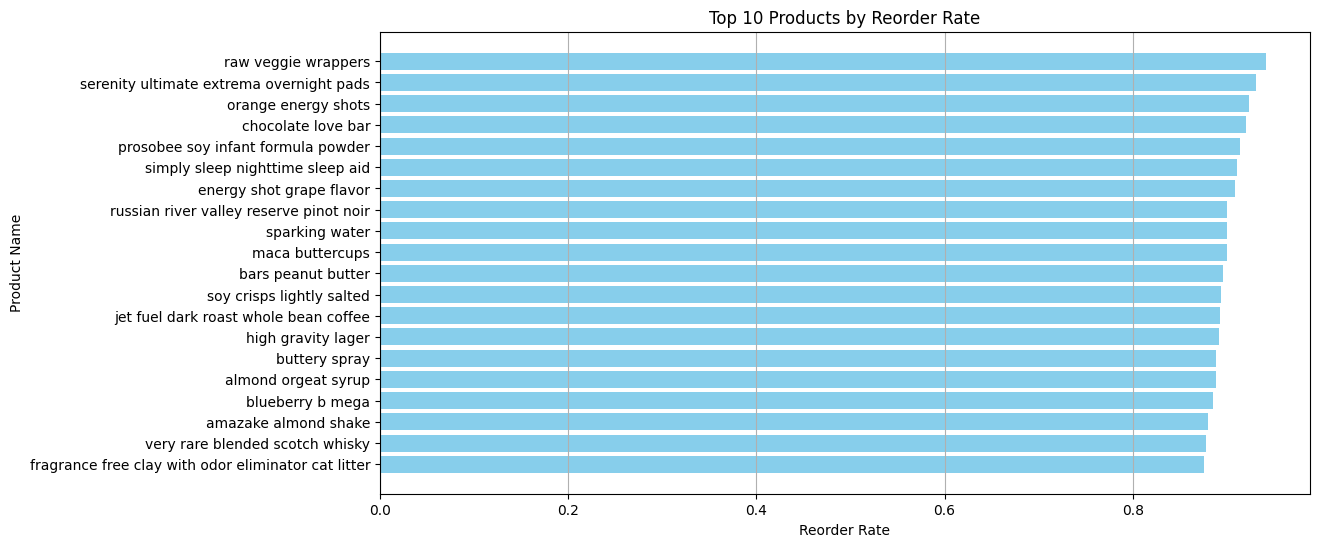

In [ ]:
# Sorting and selecting top 10 products by reorder rate
top_products = reorder_frequency_df.sort_values(by='reorder_rate', ascending=False).head(20)

# Plotting
plt.figure(figsize=(12, 6))
plt.barh(top_products['final_product_name'], top_products['reorder_rate'], color='skyblue')
plt.xlabel('Reorder Rate')
plt.ylabel('Product Name')
plt.title('Top 10 Products by Reorder Rate')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

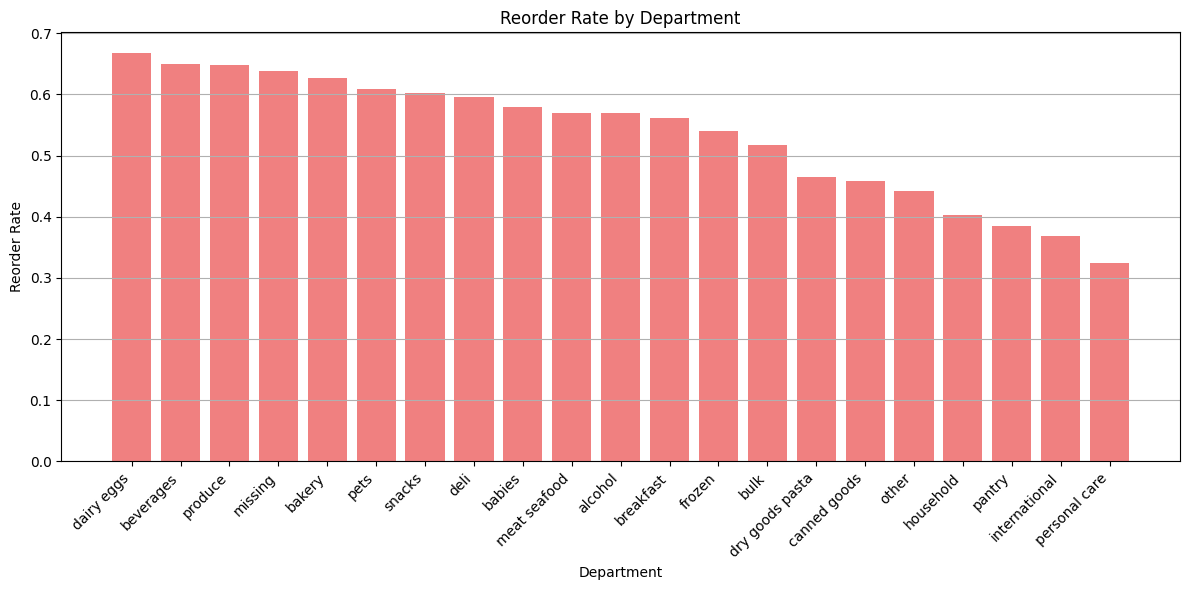

In [ ]:
# Sorting departments by reorder rate
department_reorder_df = department_reorder_df.sort_values(by='reorder_rate', ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(department_reorder_df['department_name_ref'], department_reorder_df['reorder_rate'], color='lightcoral')
plt.xlabel('Department')
plt.ylabel('Reorder Rate')
plt.title('Reorder Rate by Department')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Performing Chi-Square Test for Association Between Departments and Reorder Counts

from scipy.stats import chi2_contingency

# Creating a contingency table for reorder counts by department
department_table = department_reorder_df.pivot_table(index='department_name_ref', values='reorder_count', aggfunc='sum')
total_orders_table = department_reorder_df.pivot_table(index='department_name_ref', values='total_orders', aggfunc='sum')
contingency_table = pd.concat([department_table, total_orders_table], axis=1)
contingency_table.columns = ['reorder_count', 'total_orders']

# Performing the Chi-Square Test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Adding explanatory text
print("Chi-Square Test Results:")
print(f"Chi2 Statistic: {chi2:.2f}")
print(f"P-value: {p_value:.5f}")
print(f"Degrees of Freedom: {dof}")

if p_value < 0.05:
    print("\nInterpretation:")
    print("The p-value is less than 0.05, indicating that there is a statistically significant association between departments and reorder counts.")
    print("This means the likelihood of reordering is dependent on the department.")
else:
    print("\nInterpretation:")
    print("The p-value is greater than or equal to 0.05, indicating that there is no statistically significant association between departments and reorder counts.")
    print("This means the likelihood of reordering is independent of the department.")


Chi-Square Test Results:
Chi2 Statistic: 320261.85
P-value: 0.00000
Degrees of Freedom: 20

Interpretation:
The p-value is less than 0.05, indicating that there is a statistically significant association between departments and reorder counts.
This means the likelihood of reordering is dependent on the department.


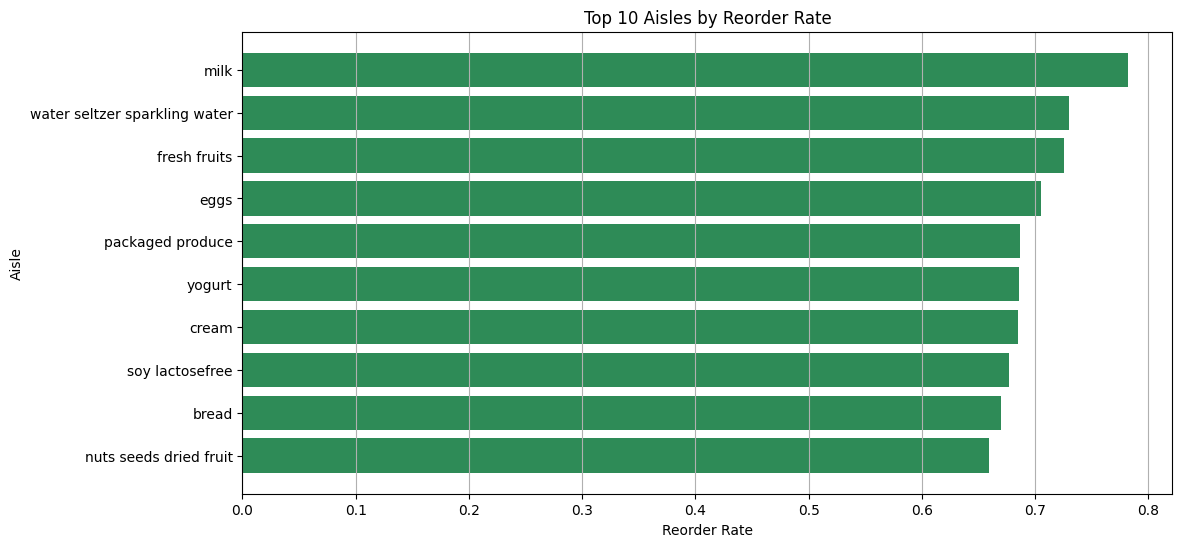

In [ ]:
# Sorting and selecting top 10 aisles by reorder rate
top_aisles = aisle_reorder_df.sort_values(by='reorder_rate', ascending=False).head(10)

# Plotting
plt.figure(figsize=(12, 6))
plt.barh(top_aisles['aisle_name_ref'], top_aisles['reorder_rate'], color='seagreen')
plt.xlabel('Reorder Rate')
plt.ylabel('Aisle')
plt.title('Top 10 Aisles by Reorder Rate')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

In [ ]:
# Analyzing and Saving Order Trends by Day of the Week and Hour of the Day

from pyspark.sql import functions as F

# Ensuring `orders_df` is the adjusted DataFrame with `adjusted_days_since_prior_order`
# Step 1: Analyzing orders by day of the week
dow_reorder = orders_adjusted.groupBy("order_dow") \
    .agg(
        F.count("*").alias("total_orders"),
        F.mean("adjusted_days_since_prior_order").alias("avg_days_since_prior_order")  # Use adjusted days
    ) \
    .orderBy("order_dow")

print("Orders by Day of the Week:")
dow_reorder.show(7)

# Saving orders by day of the week analysis
dow_reorder_path = "output_path.csv"
dow_reorder.coalesce(1).write.mode("overwrite").option("header", "true").csv(dow_reorder_path)
print(f"Orders by Day of the Week analysis saved to: {dow_reorder_path}")

# Step 2: Analyzing orders by hour of the day
hour_reorder = orders_adjusted.groupBy("order_hour_of_day") \
    .agg(
        F.count("*").alias("total_orders")
    ) \
    .orderBy("order_hour_of_day")

print("Orders by Hour of the Day:")
hour_reorder.show(24)  # Displaying all 24 hours for completeness

# Saving orders by hour of the day analysis
hour_reorder_path = "output_path/file_name.csv"
hour_reorder.coalesce(1).write.mode("overwrite").option("header", "true").csv(hour_reorder_path)
print(f"Orders by Hour of the Day analysis saved to: {hour_reorder_path}")

In [ ]:
# Loading and Verifying Orders by Day and Hour Analysis Results from CSV Files

import pandas as pd
import matplotlib.pyplot as plt

# File paths
dow_reorder_path = "output_path.csv"
hour_reorder_path = "output_path.csv"

# Loading CSV files into Pandas DataFrames
dow_reorder_df = pd.read_csv(dow_reorder_path/file_name.csv)
hour_reorder_df = pd.read_csv(hour_reorder_path/file_name.csv)

# Displaying the first few rows to confirm data loaded correctly
print("Orders by Day of the Week:")
print(dow_reorder_df.head())

print("\nOrders by Hour of the Day:")
print(hour_reorder_df.head())


Orders by Day of the Week:
   order_dow  total_orders  avg_days_since_prior_order
0          0       6252671                   11.526177
1          1       5696488                   11.293299
2          2       4242988                   11.282575
3          3       3868541                   10.908043
4          4       3812222                   10.604960

Orders by Hour of the Day:
   order_hour_of_day  total_orders
0                  0        220332
1                  1        116586
2                  2         69902
3                  3         51672
4                  4         53633


In [ ]:
# Checking for nulls

dow_nulls = orders_df.filter(F.col("order_dow").isNull()).count()
hour_nulls = orders_df.filter(F.col("order_hour_of_day").isNull()).count()
print(f"Null values in 'order_dow': {dow_nulls}")
print(f"Null values in 'order_hour_of_day': {hour_nulls}")


Null values in 'order_dow': 0
Null values in 'order_hour_of_day': 0


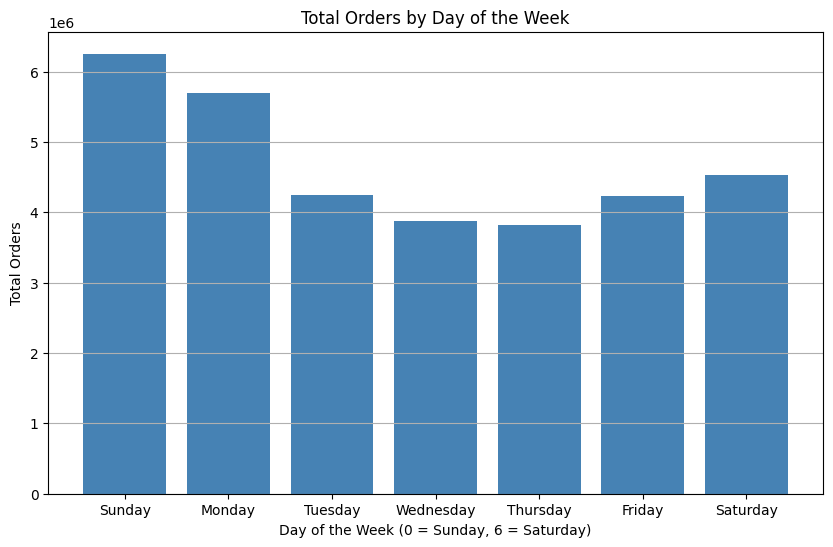

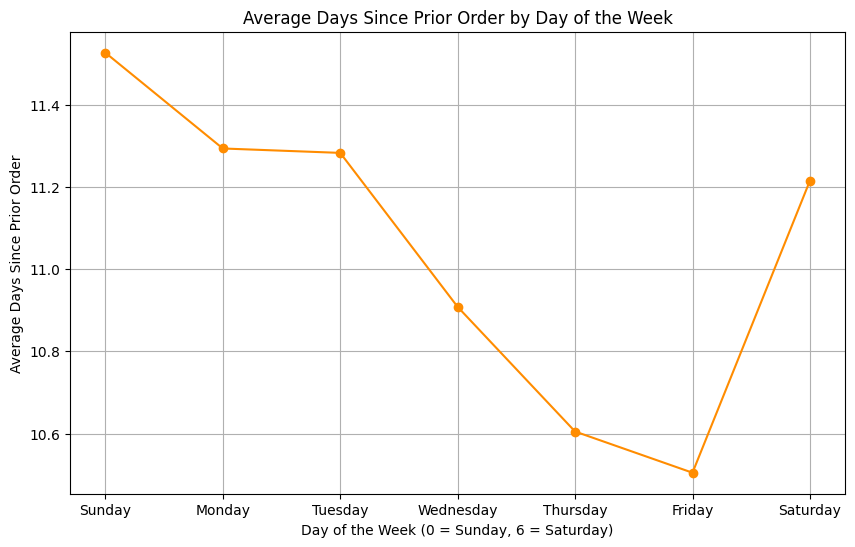

In [ ]:
# Plotting order by day of the week and average days since prior order by day of the week

# Ensuring data is sorted by 'order_dow'
dow_reorder_df = dow_reorder_df.sort_values(by='order_dow')

# Plotting orders by day of the week
plt.figure(figsize=(10, 6))
plt.bar(dow_reorder_df['order_dow'], dow_reorder_df['total_orders'], color='steelblue')
plt.xlabel('Day of the Week (0 = Sunday, 6 = Saturday)')
plt.ylabel('Total Orders')
plt.title('Total Orders by Day of the Week')
plt.grid(axis='y')
plt.xticks(ticks=range(7), labels=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.show()

# Plotting average days since prior order by day of the week
plt.figure(figsize=(10, 6))
plt.plot(dow_reorder_df['order_dow'], dow_reorder_df['avg_days_since_prior_order'], marker='o', color='darkorange')
plt.xlabel('Day of the Week (0 = Sunday, 6 = Saturday)')
plt.ylabel('Average Days Since Prior Order')
plt.title('Average Days Since Prior Order by Day of the Week')
plt.grid(True)
plt.xticks(ticks=range(7), labels=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.show()


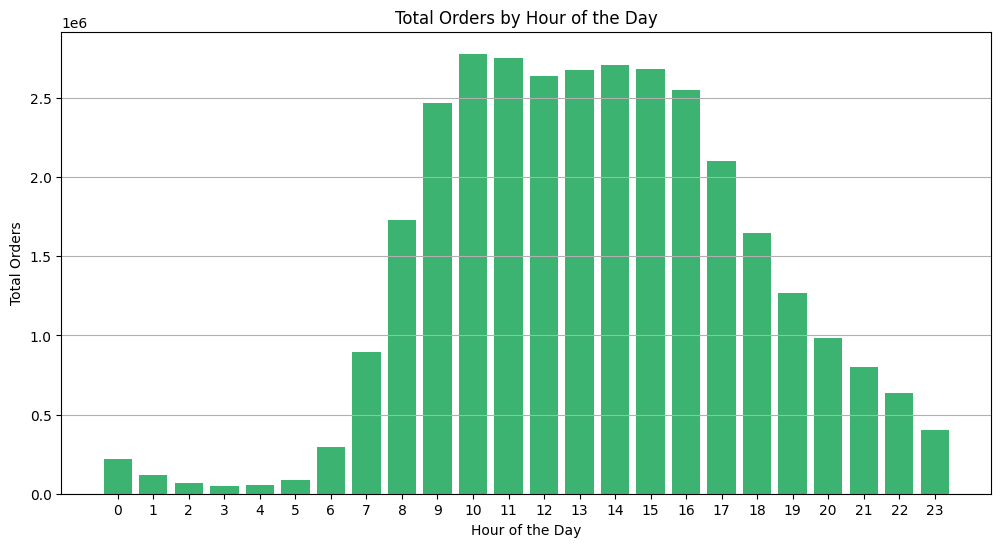

In [ ]:
# Plotting orders by hour of the day
plt.figure(figsize=(12, 6))
plt.bar(hour_reorder_df['order_hour_of_day'], hour_reorder_df['total_orders'], color='mediumseagreen')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Orders')
plt.title('Total Orders by Hour of the Day')
plt.grid(axis='y')
plt.xticks(ticks=range(0, 24))
plt.show()

In [ ]:
# Analyzing Correlations Between Order Patterns and Time Features (Day and Hour)

import numpy as np

# Correlation between day of the week and average days since prior order
correlation_dow = dow_reorder_df['order_dow'].corr(dow_reorder_df['avg_days_since_prior_order'])
print(f"Correlation between Day of Week and Avg Days Since Prior Order: {correlation_dow}")

# Correlation between hour of the day and total orders
correlation_hour = hour_reorder_df['order_hour_of_day'].corr(hour_reorder_df['total_orders'])
print(f"Correlation between Hour of Day and Total Orders: {correlation_hour}")

Correlation between Day of Week and Avg Days Since Prior Order: -0.6414059188501503
Correlation between Hour of Day and Total Orders: 0.35587178552779886


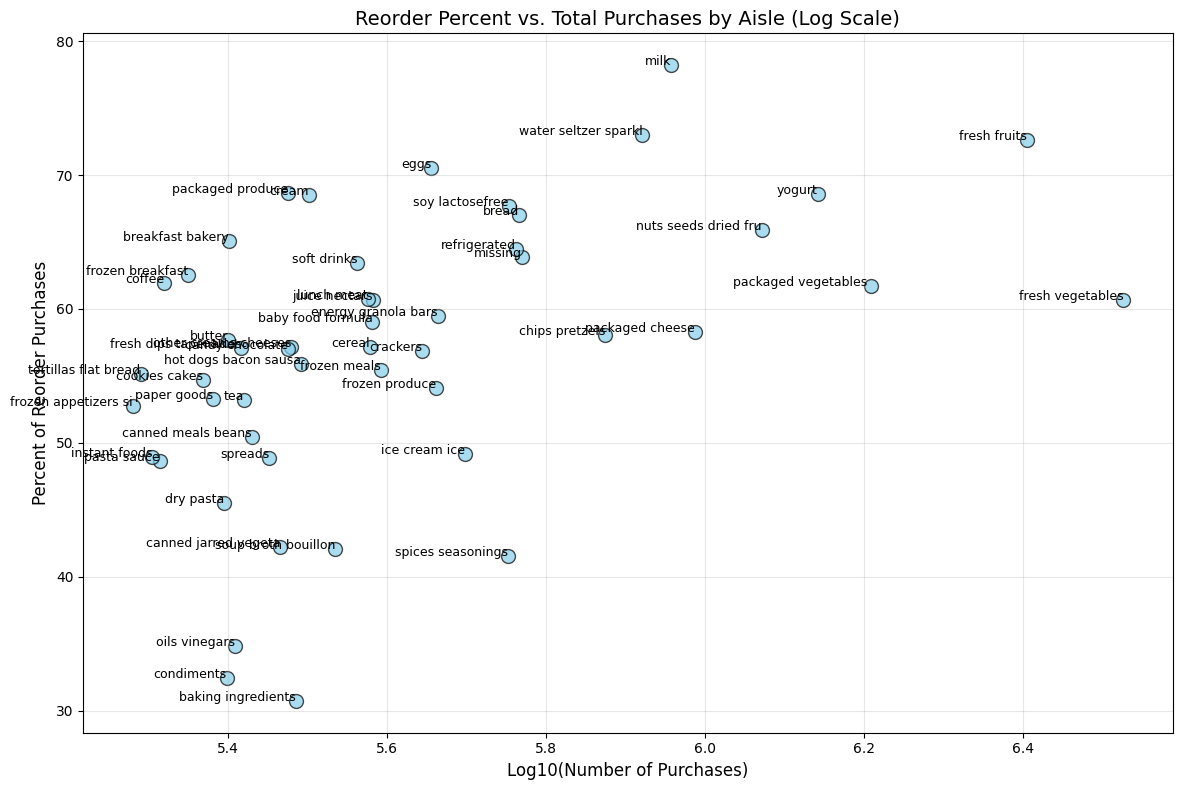

In [ ]:
# Analyzing and Visualizing Reorder Percentages vs. Total Purchases by Aisle (Log Scale)

from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Joining processed products with aisles to get aisle names
processed_products_with_aisles = processed_products_final.join(
    aisles_df.select(F.col("aisle_id_ref").alias("aisle_id"), F.col("aisle_name_ref").alias("aisle_name")),
    "aisle_id",
    "left"
)

# Step 2: Using adjusted `full_df` and joining with processed products and aisles
full_cleaned_df = full_df.join(
    processed_products_with_aisles.select("product_id", "final_product_name", "aisle_name"),
    "product_id",
    "inner"
)

# Step 3: Aggregating data by aisle
aisle_data = (
    full_cleaned_df.groupBy("aisle_name")
    .agg(
        F.count("*").alias("total_orders"),  # Total purchases
        F.count(F.when(F.col("reordered") == 1, True)).alias("reorder_count"),  # Reordered purchases
    )
    .withColumn("percent_reorder_purchases", (F.col("reorder_count") / F.col("total_orders")) * 100)
    .filter(F.col("total_orders") > 0)  # Filter rows with total orders > 0
    .orderBy(F.col("total_orders").desc())  # Sort by total purchases
)

if aisle_data.count() == 0:
    print("No data available for plotting. Check the filtering criteria.")
else:
    # Step 4: Converting to Pandas and select top 50 aisles
    aisle_df = aisle_data.limit(50).toPandas()

    # Step 5: Plotting
    plt.figure(figsize=(12, 8))

    # Scatter plot with log scale for total purchases
    plt.scatter(
        np.log10(aisle_df["total_orders"]),  # Log scale for X-axis
        aisle_df["percent_reorder_purchases"],  # Y-axis
        color="skyblue",
        edgecolor="black",
        s=100,  # Bubble size
        alpha=0.7,
    )

    # Annotating points with aisle names
    for i, row in aisle_df.iterrows():
        aisle_name = row["aisle_name"][:20]  # Truncate long names
        plt.text(
            np.log10(row["total_orders"]),
            row["percent_reorder_purchases"],
            aisle_name,
            fontsize=9,
            ha="right",
        )

    # Adding labels and title
    plt.xlabel("Log10(Number of Purchases)", fontsize=12)
    plt.ylabel("Percent of Reorder Purchases", fontsize=12)
    plt.title("Reorder Percent vs. Total Purchases by Aisle (Log Scale)", fontsize=14)
    plt.grid(True, alpha=0.3)

    # Showing plot
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd

# Defining function to map hours to time periods
def map_time_period(hour):
    if 22 <= hour <= 23 or 0 <= hour <= 6:
        return "Night"
    elif 6 < hour <= 12:
        return "Morning"
    elif 12 < hour <= 17:
        return "Noon"
    else:
        return "Evening"

# Applying the function to group hours
hour_reorder_df['time_period'] = hour_reorder_df['order_hour_of_day'].apply(map_time_period)


In [ ]:
# Aggregating total orders by time period
grouped_metrics = hour_reorder_df.groupby('time_period')['total_orders'].sum().reset_index()
print(grouped_metrics)


  time_period  total_orders
0     Evening       4702324
1     Morning      13271413
2       Night       1936994
3        Noon      12729047


In [ ]:
# Mapping time periods to numerical values
time_period_mapping = {"Night": 1, "Morning": 2, "Noon": 3, "Evening": 4}
hour_reorder_df['time_period_numeric'] = hour_reorder_df['time_period'].map(time_period_mapping)

# Calculating correlation
correlation_time_period = hour_reorder_df['time_period_numeric'].corr(hour_reorder_df['total_orders'])
print(f"Correlation between Time Period and Total Orders: {correlation_time_period}")


Correlation between Time Period and Total Orders: 0.5230602366939074


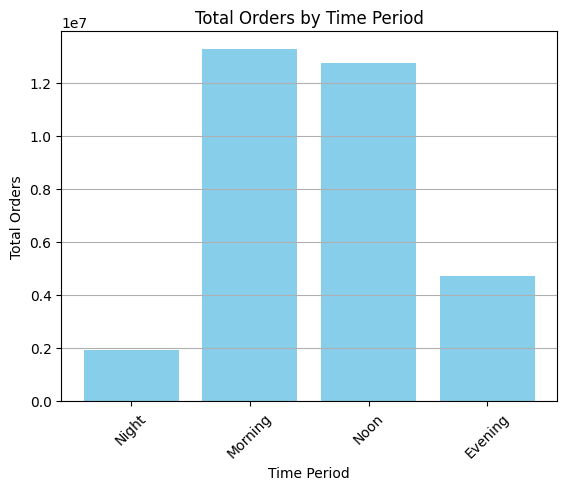

In [ ]:
import matplotlib.pyplot as plt

# Defining the desired order
time_period_order = ["Night", "Morning", "Noon", "Evening"]

# Grouping the data and using the categorical order
grouped_metrics = hour_reorder_df.groupby('time_period')['total_orders'].sum().reset_index()
grouped_metrics['time_period'] = pd.Categorical(grouped_metrics['time_period'], categories=time_period_order, ordered=True)

# Sorting the data by the defined order
grouped_metrics = grouped_metrics.sort_values('time_period')

# Plotting the data
plt.bar(grouped_metrics['time_period'], grouped_metrics['total_orders'], color='skyblue')
plt.title("Total Orders by Time Period")
plt.xlabel("Time Period")
plt.ylabel("Total Orders")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()



<Figure size 800x600 with 0 Axes>

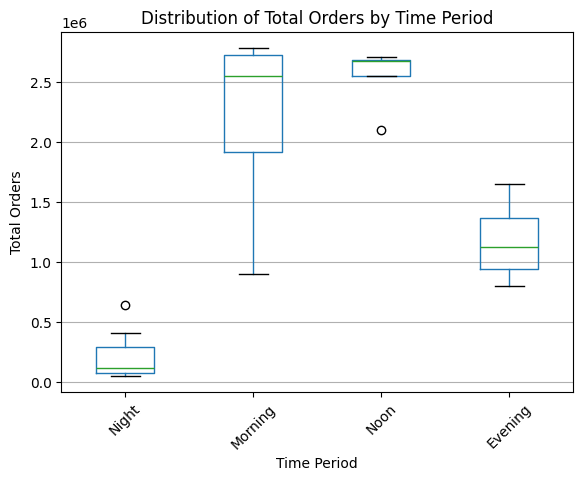

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Applying the function to group hours
hour_reorder_df['time_period'] = hour_reorder_df['order_hour_of_day'].apply(map_time_period)

# Defining the desired order
time_period_order = ["Night", "Morning", "Noon", "Evening"]

# Setting the categorical order
hour_reorder_df['time_period'] = pd.Categorical(hour_reorder_df['time_period'], categories=time_period_order, ordered=True)

# Plotting the box plot
plt.figure(figsize=(8, 6))
hour_reorder_df.boxplot(column='total_orders', by='time_period', grid=False)
plt.title("Distribution of Total Orders by Time Period")
plt.suptitle("")  # Remove the automatic subplot title
plt.xlabel("Time Period")
plt.ylabel("Total Orders")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [ ]:
# Generating heatmap for most popular products by hour of the day

# Adding final_product_name if missing
if "final_product_name" not in full_df.columns:
    full_df = full_df.join(
        processed_products_final.select("product_id", "final_product_name"),
        "product_id",
        "left"
    )

# Adding order_hour_of_day if missing
if "order_hour_of_day" not in full_df.columns:
    full_df = full_df.join(
        orders_df.select("order_id", "order_hour_of_day"),
        "order_id",
        "left"
    )

In [ ]:
# Top 50 Product Hourly Purchases

product_hour_data = (
    full_df.groupBy("product_id", "final_product_name", "order_hour_of_day")
    .agg(F.count("*").alias("total_purchases"))
)

# Identifying the top 50 products
top_50_products = (
    product_hour_data.groupBy("product_id", "final_product_name")
    .agg(F.sum("total_purchases").alias("total_orders"))
    .orderBy(F.col("total_orders").desc())
    .limit(50)
)

# Filtering for the top 50 products
top_50_product_hour_data = (
    product_hour_data.join(top_50_products, ["product_id", "final_product_name"], "inner")
    .orderBy(F.col("final_product_name"), F.col("order_hour_of_day"))
)

In [ ]:
# Converting to Pandas for visualization
product_hour_df = top_50_product_hour_data.toPandas()

# Aggregating duplicate entries before pivoting
product_hour_df = (
    product_hour_df.groupby(["final_product_name", "order_hour_of_day"], as_index=False)
    .agg({"total_purchases": "sum"})
)

# Pivot for heatmap
heatmap_data = product_hour_df.pivot(
    index="final_product_name", columns="order_hour_of_day", values="total_purchases"
).fillna(0)

# Normalizing for better visualization
row_sums = heatmap_data.sum(axis=1)
normalized_heatmap_data = heatmap_data.div(row_sums.replace(0, 1), axis=0)

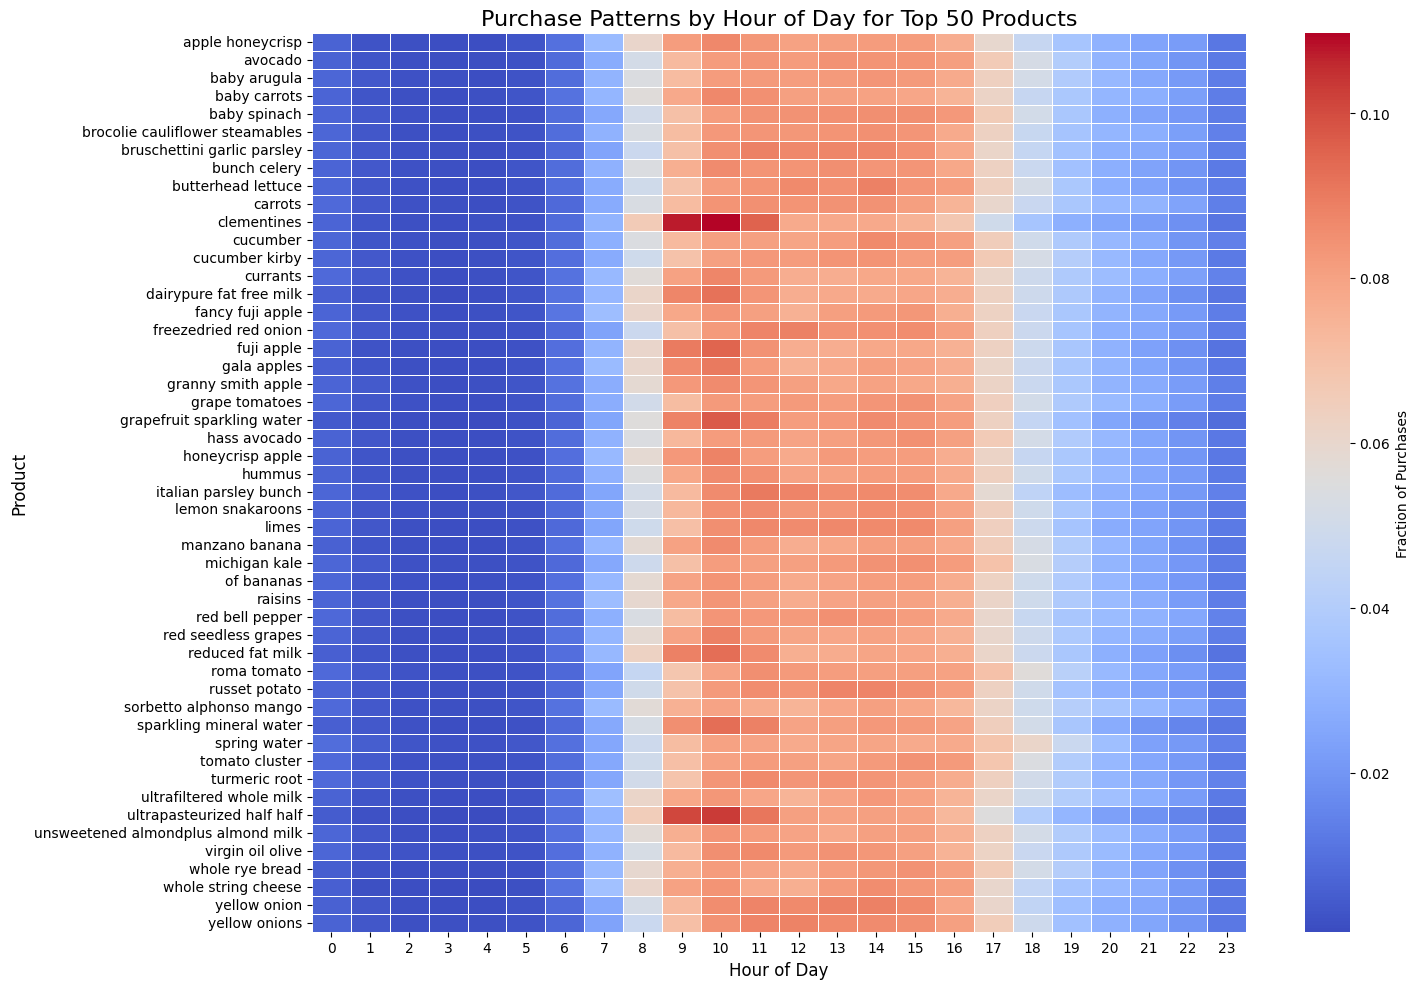

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(
    normalized_heatmap_data,
    cmap="coolwarm",
    annot=False,
    linewidths=0.5,
    cbar_kws={"label": "Fraction of Purchases"},
)

# Heatmap settings
plt.title("Purchase Patterns by Hour of Day for Top 50 Products", fontsize=16)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Product", fontsize=12)
plt.tight_layout()
plt.show()

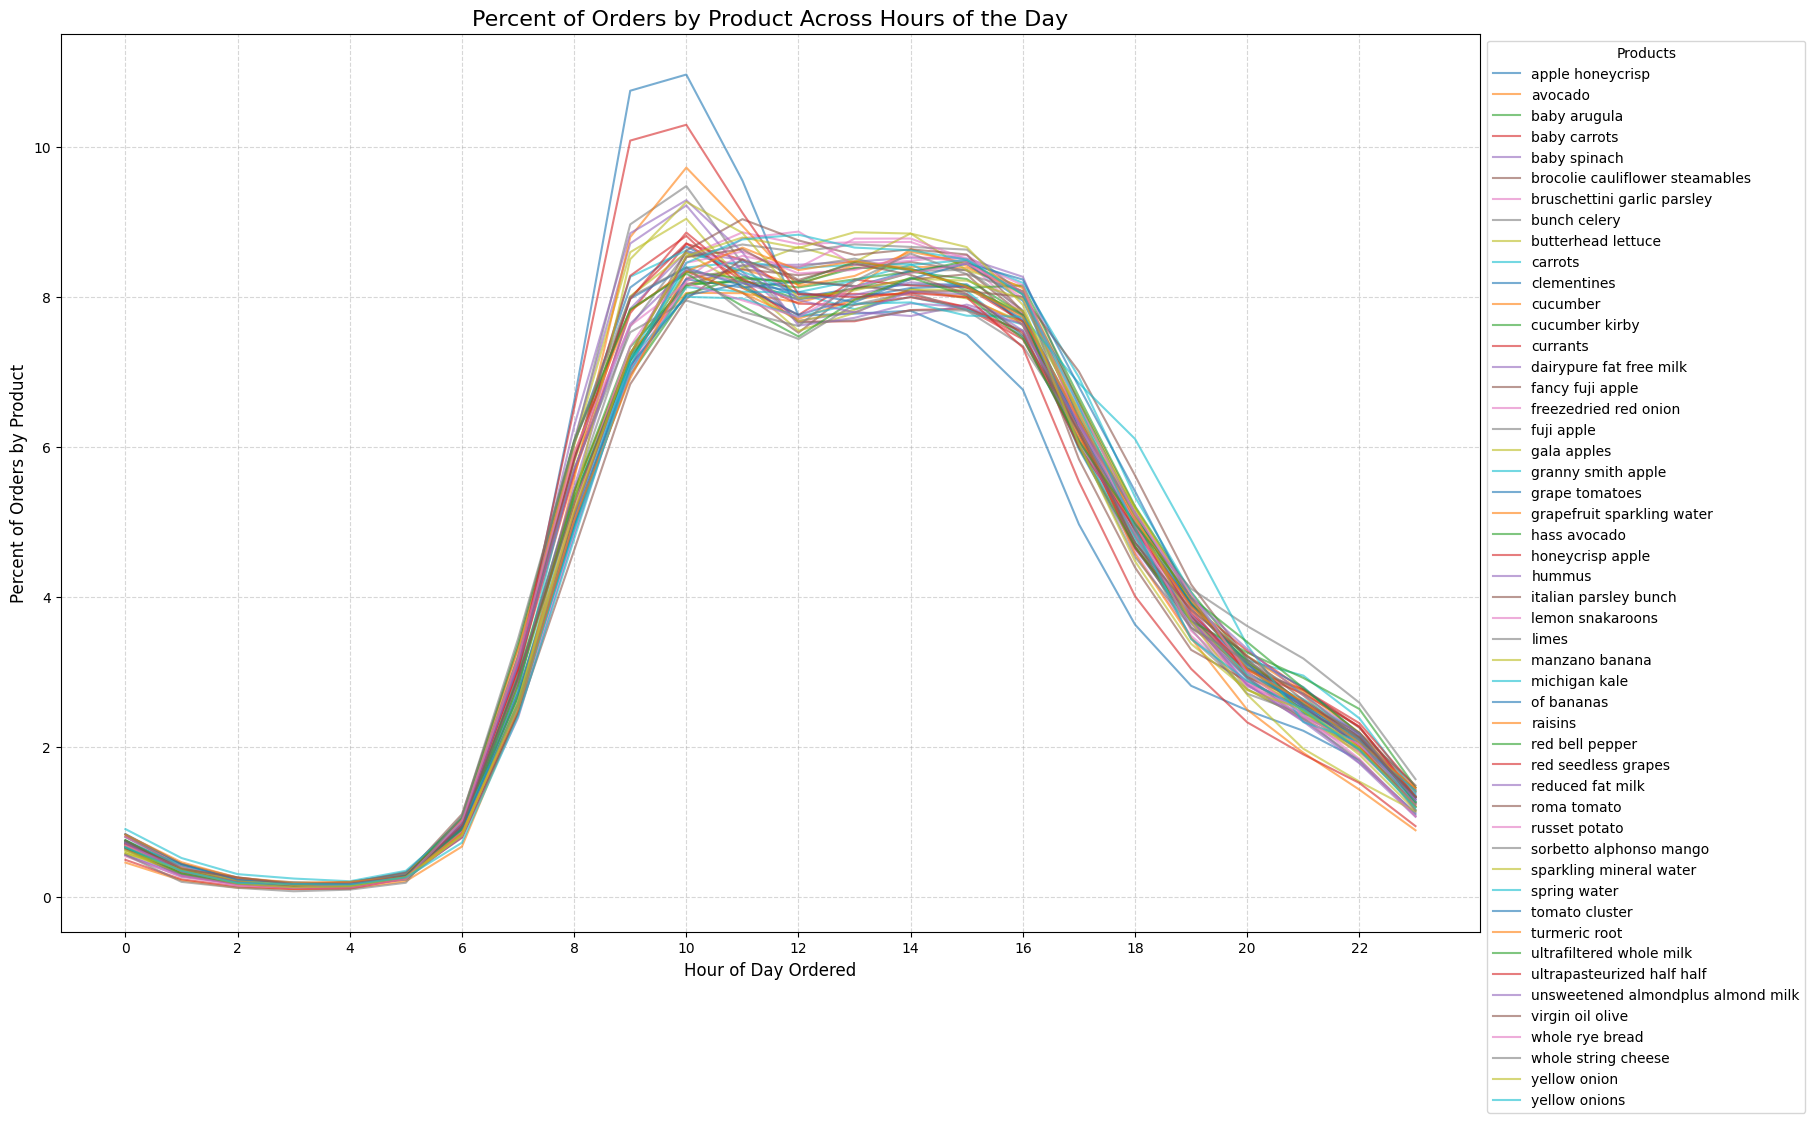

In [ ]:
# Visualizing Hourly Order Distribution for Top Products

import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Normalizing the data for percent of orders by product across hours
# Ensuring the DataFrame is grouped and normalized correctly
product_hour_df['percent_orders'] = product_hour_df.groupby('final_product_name')['total_purchases'].transform(
    lambda x: x / x.sum() * 100
)

# Step 2: Plotting the line graph
plt.figure(figsize=(15, 10))

# Looping through each product and plot its data
for product in product_hour_df['final_product_name'].unique():
    product_data = product_hour_df[product_hour_df['final_product_name'] == product]
    plt.plot(
        product_data['order_hour_of_day'],
        product_data['percent_orders'],
        label=product,
        alpha=0.6,
    )

# Enhancing plot
plt.title("Percent of Orders by Product Across Hours of the Day", fontsize=16)
plt.xlabel("Hour of Day Ordered", fontsize=12)
plt.ylabel("Percent of Orders by Product", fontsize=12)
plt.xticks(range(0, 24, 2))  # Display only even hours for clarity
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Adding a legend for product names
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10, title="Products")

# Showing plot
plt.show()

In [ ]:
print("Columns in product_hour_data:", product_hour_data.columns)
product_hour_data.show(5, truncate=False)


Columns in product_hour_data: ['product_id', 'final_product_name', 'order_hour_of_day', 'total_purchases']
+----------+-----------------------------------------------------+-----------------+---------------+
|product_id|final_product_name                                   |order_hour_of_day|total_purchases|
+----------+-----------------------------------------------------+-----------------+---------------+
|463       |salt free seasoning                                  |9                |4              |
|2366      |plugins scented oil refill lavender vanilla          |0                |1              |
|5518      |punjabi tikka masala rich creamy tomato cooking sauce|21               |1              |
|7993      |dressing sandwich spread made with olive oil         |4                |1              |
|10362     |crushed tomato                                       |17               |1              |
+----------+-----------------------------------------------------+-----------------+-

In [ ]:
# Classifying and Analyzing Peak Time Periods for Product Orders

from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Step 1: Using `full_df` to aggregate data by product and hour of the day
product_hour_data = (
    full_df.groupBy("product_id", "final_product_name", "order_hour_of_day")
    .agg(F.count("*").alias("total_purchases"))
)

# Debugging Step: Inspecting `product_hour_data`
print("Columns in product_hour_data:", product_hour_data.columns)
product_hour_data.show(5, truncate=False)

# Step 2: Defining function to map hours to time periods
def map_time_period(hour):
    if 22 <= hour <= 23 or 0 <= hour <= 6:
        return "Night"
    elif 7 <= hour <= 12:
        return "Morning"
    elif 13 <= hour <= 17:
        return "Noon"
    else:
        return "Evening"

# Registering UDF
map_time_period_udf = F.udf(map_time_period, StringType())

# Step 3: Adding `time_period` column to classify hours
product_hour_data = product_hour_data.withColumn(
    "time_period", map_time_period_udf(F.col("order_hour_of_day"))
)

# Debugging Step: Inspecting `product_hour_data` after adding `time_period`
print("Columns in product_hour_data after adding time_period:", product_hour_data.columns)
product_hour_data.show(5, truncate=False)

# Step 4: Aggregating to find peak time period for each product
product_peak_hours = (
    product_hour_data.groupBy("product_id", "final_product_name", "time_period")
    .agg(F.sum("total_purchases").alias("total_purchases_by_period"))
    .orderBy("product_id", F.desc("total_purchases_by_period"))
)

# Debugging Step: Inspecting `product_peak_hours`
print("Columns in product_peak_hours:", product_peak_hours.columns)
product_peak_hours.show(5, truncate=False)

# Step 5: Ranking and selecting the top time period for each product
window = Window.partitionBy("product_id").orderBy(F.desc("total_purchases_by_period"))
product_peak_hours = product_peak_hours.withColumn(
    "rank", F.row_number().over(window)
).filter(F.col("rank") == 1).select("product_id", "final_product_name", "time_period")

# Debugging Step: Inspecting `product_peak_hours` after ranking
print("Columns in product_peak_hours after ranking:", product_peak_hours.columns)
product_peak_hours.show(5, truncate=False)

# Step 6: Joining with hourly data to propagate peak time period
filtered_product_hour_df = product_hour_data.join(
    product_peak_hours.withColumnRenamed("time_period", "peak_time_period"),  # Avoid duplicate column names
    ["product_id", "final_product_name"],
    "inner"
)

# Debugging Step: Inspecting `filtered_product_hour_df`
print("Columns in filtered_product_hour_df:", filtered_product_hour_df.columns)
filtered_product_hour_df.show(5, truncate=False)

# Step 7: Converting to Pandas for plotting
filtered_product_hour_df_pd = filtered_product_hour_df.toPandas()

# Debugging Step: Checking for duplicate columns in Pandas
if len(filtered_product_hour_df_pd.columns) != len(set(filtered_product_hour_df_pd.columns)):
    print("Duplicate columns detected in filtered_product_hour_df_pd!")

# Step 8: Creating `legend_label` column
filtered_product_hour_df_pd["legend_label"] = (
    filtered_product_hour_df_pd["final_product_name"] + " (" + filtered_product_hour_df_pd["peak_time_period"] + ")"
)

# Debugging Step: Printing the first few rows of the final DataFrame
print(filtered_product_hour_df_pd.head())


Columns in product_hour_data: ['product_id', 'final_product_name', 'order_hour_of_day', 'total_purchases']
+----------+-----------------------------------------------------+-----------------+---------------+
|product_id|final_product_name                                   |order_hour_of_day|total_purchases|
+----------+-----------------------------------------------------+-----------------+---------------+
|463       |salt free seasoning                                  |9                |4              |
|2366      |plugins scented oil refill lavender vanilla          |0                |1              |
|5518      |punjabi tikka masala rich creamy tomato cooking sauce|21               |1              |
|7993      |dressing sandwich spread made with olive oil         |4                |1              |
|10362     |crushed tomato                                       |17               |1              |
+----------+-----------------------------------------------------+-----------------+-

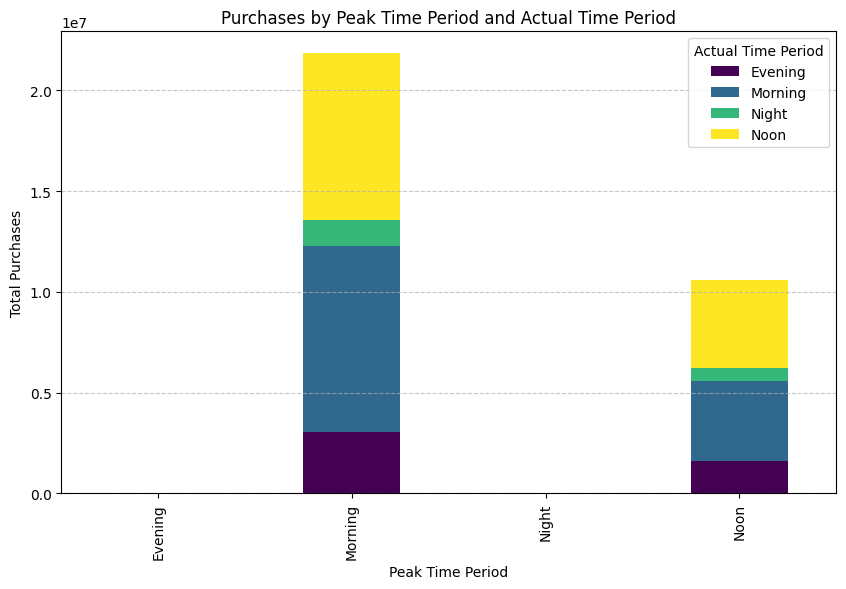

In [ ]:
peak_period_counts = (
    filtered_product_hour_df_pd.groupby(["peak_time_period", "time_period"])["total_purchases"].sum().unstack()
)

# Stacked bar plot
peak_period_counts.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="viridis")
plt.title("Purchases by Peak Time Period and Actual Time Period")
plt.xlabel("Peak Time Period")
plt.ylabel("Total Purchases")
plt.legend(title="Actual Time Period")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Clustering Products Based on Time-Period Purchase Patterns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

# Preparing data for clustering
clustering_data = filtered_product_hour_df_pd.pivot_table(
    index="product_id", columns="time_period", values="total_purchases", fill_value=0
).reset_index()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data.drop("product_id", axis=1))

kmeans = KMeans(n_clusters=3, random_state=42)
clustering_data["Cluster"] = kmeans.fit_predict(scaled_data)

# Analyzing clusters
print(clustering_data.groupby("Cluster").mean())

time_period    product_id       Evening       Morning        Night  \
Cluster                                                              
0            25315.459554     17.922047     33.149435     3.839009   
1            41144.875000  14181.875000  26757.770833  2677.138889   
2            35690.382114   2033.191057   3946.621951   383.015357   

time_period          Noon  
Cluster                    
0               38.179869  
1            30533.400000  
2             4477.255285  


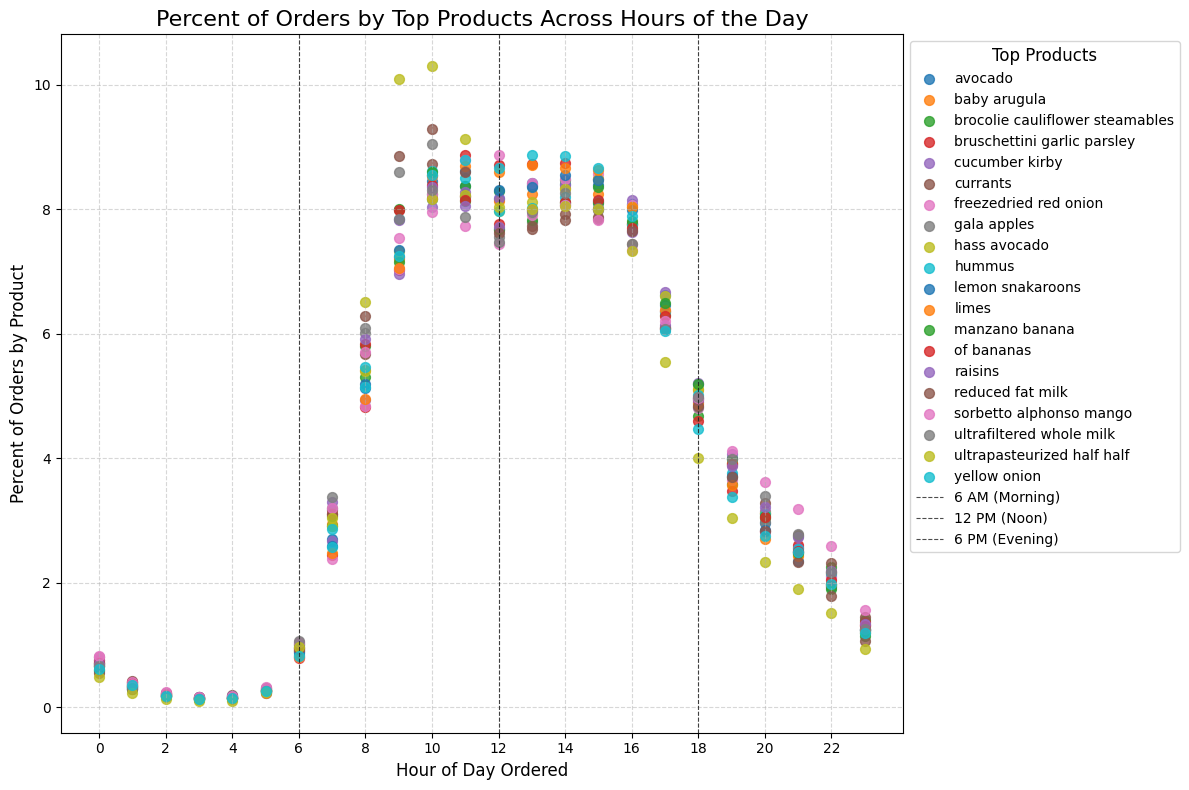

In [ ]:
# Visualizing Hourly Purchase Trends for Top Products Using Scatter Plots

import matplotlib.pyplot as plt
import numpy as np

# Validating that necessary columns are present
required_columns = {'final_product_name', 'total_purchases', 'order_hour_of_day'}
missing_columns = required_columns - set(filtered_product_hour_df_pd.columns)
if missing_columns:
    raise ValueError(f"Missing required columns: {missing_columns}")

# Step 1: Normalizing data for percent of orders by product across hours
filtered_product_hour_df_pd['percent_orders'] = (
    filtered_product_hour_df_pd.groupby('final_product_name')['total_purchases']
    .transform(lambda x: (x / x.sum() * 100) if x.sum() > 0 else 0)  # Avoid division by zero
)

# Step 2: Increasing the number of products plotted
top_n = 20  # Adjustable
top_products = (
    filtered_product_hour_df_pd.groupby('final_product_name')['total_purchases']
    .sum()
    .nlargest(top_n)
    .index
)
highlighted_df = filtered_product_hour_df_pd[
    filtered_product_hour_df_pd['final_product_name'].isin(top_products)
].sort_values(by=['final_product_name', 'order_hour_of_day'])

# Step 3: Aggregating duplicate hours for each product
plt.figure(figsize=(12, 8))
for product in highlighted_df['final_product_name'].unique():
    product_data = highlighted_df[highlighted_df['final_product_name'] == product]

    # Aggregating by order_hour_of_day to handle duplicates
    aggregated_data = (
        product_data.groupby('order_hour_of_day', as_index=False)
        .agg({'percent_orders': 'mean'})  # Take the mean percent_orders for duplicate hours
    )
    hours = aggregated_data['order_hour_of_day'].values
    percent_orders = aggregated_data['percent_orders'].values

    # Plotting as dots
    plt.scatter(hours, percent_orders, label=product, s=50, alpha=0.8)  # Adjust `s` for dot size

# Step 4: Adding plot enhancements
plt.axvline(x=6, color="black", linestyle="--", linewidth=0.8, alpha=0.7, label="6 AM (Morning)")
plt.axvline(x=12, color="black", linestyle="--", linewidth=0.8, alpha=0.7, label="12 PM (Noon)")
plt.axvline(x=18, color="black", linestyle="--", linewidth=0.8, alpha=0.7, label="6 PM (Evening)")

plt.title("Percent of Orders by Top Products Across Hours of the Day", fontsize=16)
plt.xlabel("Hour of Day Ordered", fontsize=12)
plt.ylabel("Percent of Orders by Product", fontsize=12)
plt.xticks(range(0, 24, 2))
plt.grid(True, linestyle="--", alpha=0.5)

# Step 5: Simplifying the legend
plt.legend(
    loc="upper left",
    bbox_to_anchor=(1, 1),
    title="Top Products",
    fontsize=10,
    title_fontsize=12
)

# Showing plot
plt.tight_layout()
plt.show()


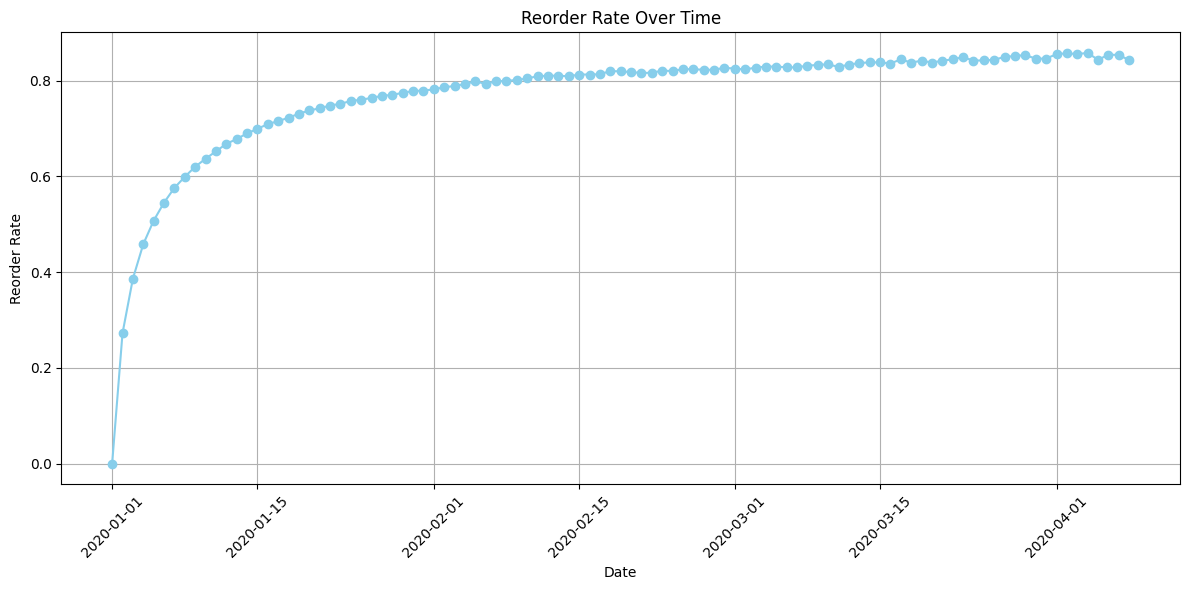

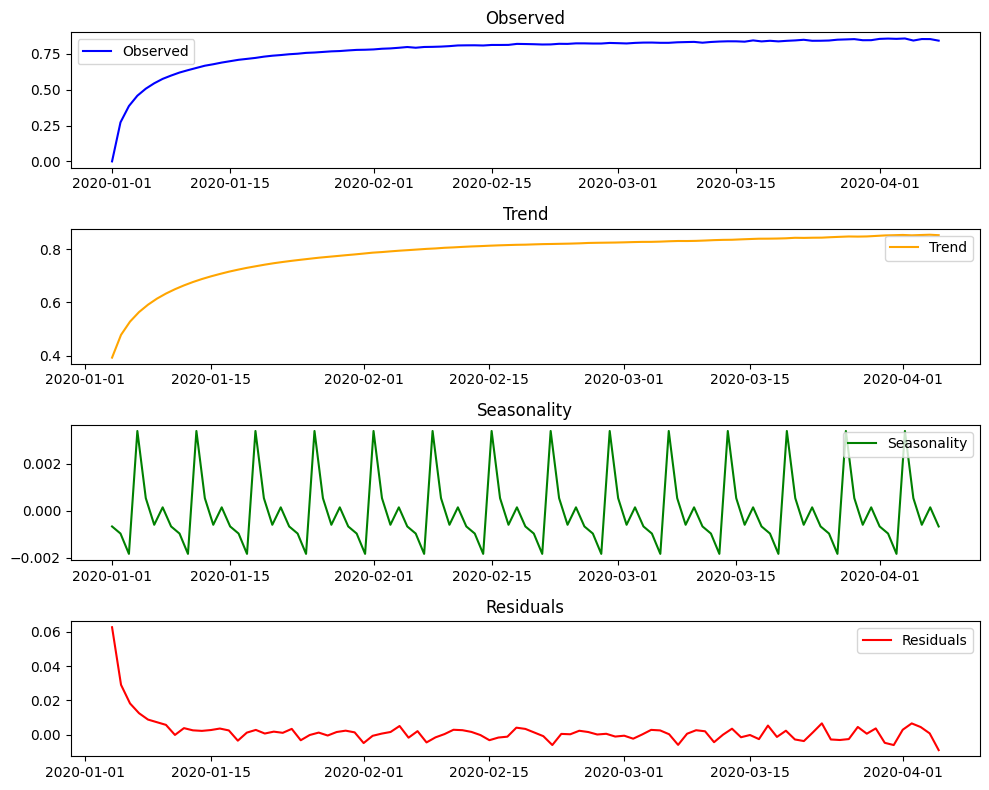

In [ ]:
# Time Series Analysis - Seasonal Decomposition
from pyspark.sql.functions import expr, to_date, col, count, when
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Step 1: Generating synthetic order dates
# Assuming the first order starts from '2020-01-01' and each subsequent order is one day apart
try:
    orders_df = orders_df.withColumn(
        "order_date", expr("date_add(to_date('2020-01-01'), order_number - 1)")
    )
except Exception as e:
    print(f"Error generating synthetic dates: {e}")

# Step 2: Joining orders with order_products_prior to calculate reorder rates by date
try:
    full_df_with_date = orders_df.join(order_products_prior_df, "order_id", "inner")

    # Step 3: Grouping by the generated date and calculating reorder counts
    reorder_by_date = full_df_with_date.groupBy("order_date") \
        .agg(
            count(when(col("reordered") == 1, True)).alias("reorder_count"),
            count("*").alias("total_orders")
        ) \
        .withColumn("reorder_rate", col("reorder_count") / col("total_orders")) \
        .orderBy("order_date")

    # Step 4: Converting the Spark DataFrame to Pandas for visualization
    reorder_by_date_pd = reorder_by_date.toPandas()

except Exception as e:
    print(f"Error during data aggregation: {e}")
    reorder_by_date_pd = pd.DataFrame()

# Checking if the DataFrame is not empty
if not reorder_by_date_pd.empty:
    try:
        # Step 5: Plotting the time series data
        plt.figure(figsize=(12, 6))
        plt.plot(reorder_by_date_pd['order_date'], reorder_by_date_pd['reorder_rate'], marker='o', color='skyblue')
        plt.title('Reorder Rate Over Time')
        plt.xlabel('Date')
        plt.ylabel('Reorder Rate')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Step 6: Performing seasonal decomposition (additive model with a weekly period)
        reorder_by_date_pd.set_index('order_date', inplace=True)

        # Check if there are enough data points for decomposition
        if len(reorder_by_date_pd) > 14:  # Ensure there are enough data points
            try:
                decomposition = seasonal_decompose(
                    reorder_by_date_pd['reorder_rate'],
                    model='additive',
                    period=7
                )

                # Step 7: Plotting the decomposition results
                plt.figure(figsize=(10, 8))

                plt.subplot(411)
                plt.plot(decomposition.observed, label='Observed', color='blue')
                plt.title('Observed')
                plt.legend(loc='best')

                plt.subplot(412)
                plt.plot(decomposition.trend, label='Trend', color='orange')
                plt.title('Trend')
                plt.legend(loc='best')

                plt.subplot(413)
                plt.plot(decomposition.seasonal, label='Seasonality', color='green')
                plt.title('Seasonality')
                plt.legend(loc='best')

                plt.subplot(414)
                plt.plot(decomposition.resid, label='Residuals', color='red')
                plt.title('Residuals')
                plt.legend(loc='best')

                plt.tight_layout()
                plt.show()

            except ValueError as e:
                print(f"Error during decomposition: {e}")
        else:
            print("Not enough data points for seasonal decomposition.")
    except Exception as e:
        print(f"Error during visualization or decomposition: {e}")
else:
    print("The Pandas DataFrame is empty. Ensure the data processing steps are correct.")


Clustering

User Features Schema:
root
 |-- user_id: integer (nullable = true)
 |-- total_orders: long (nullable = false)
 |-- total_reorders: long (nullable = true)
 |-- unique_products: long (nullable = false)
 |-- avg_basket_size: double (nullable = true)
 |-- median_order_hour: integer (nullable = true)
 |-- median_order_dow: integer (nullable = true)
 |-- reorder_ratio: double (nullable = true)

+-------+------------+--------------+---------------+------------------+-----------------+----------------+------------------+
|user_id|total_orders|total_reorders|unique_products|avg_basket_size   |median_order_hour|median_order_dow|reorder_ratio     |
+-------+------------+--------------+---------------+------------------+-----------------+----------------+------------------+
|148    |7           |18            |85             |11.864077669902912|13               |4               |2.5714285714285716|
|471    |6           |39            |84             |11.16             |14               |2         

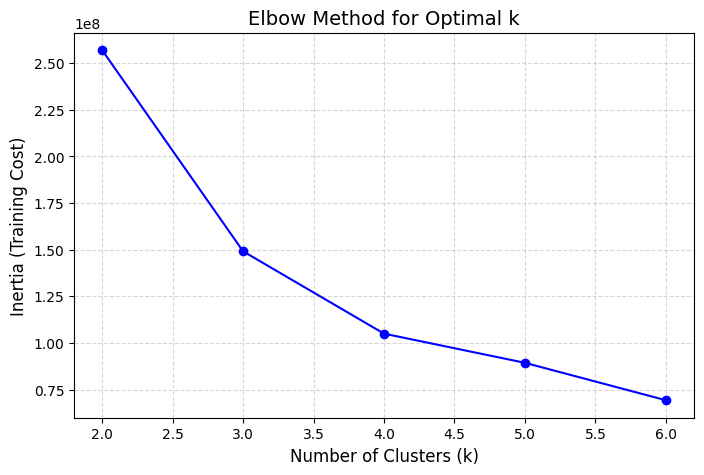

In [ ]:
# User Clustering by kmeans and Optimal k Determination Using the Elbow Method

from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

# Step 1: User-level metrics
# Grouping by `user_id` to calculate user-specific features
user_features = full_df.groupBy("user_id").agg(
    F.countDistinct("order_id").alias("total_orders"),
    F.sum("reordered").alias("total_reorders"),
    F.countDistinct("product_id").alias("unique_products"),
    F.avg("add_to_cart_order").alias("avg_basket_size"),
    F.expr("percentile_approx(order_hour_of_day, 0.5)").alias("median_order_hour"),
    F.expr("percentile_approx(order_dow, 0.5)").alias("median_order_dow")
)

# Step 2: Calculating reorder ratio
user_features = user_features.withColumn(
    "reorder_ratio",
    F.when(F.col("total_orders") > 0, F.col("total_reorders") / F.col("total_orders")).otherwise(0)
)

# Debugging: Inspecting user features
print("User Features Schema:")
user_features.printSchema()
user_features.show(5, truncate=False)

# Step 3: Assembling features for clustering
assembler = VectorAssembler(
    inputCols=[
        "total_orders", "reorder_ratio", "unique_products",
        "avg_basket_size", "median_order_hour", "median_order_dow"
    ],
    outputCol="features"
)
user_features = assembler.transform(user_features)

# Debugging: Checking the DataFrame with features
user_features.select("user_id", "features").show(5, truncate=False)

# Step 4: Elbow Method to find the optimal number of clusters
inertia_values = []
cluster_range = range(2, 7)  # Testing k from 2 to 6

for k in cluster_range:
    kmeans = KMeans(k=k, seed=1, featuresCol="features")
    model = kmeans.fit(user_features)
    inertia_values.append(model.summary.trainingCost)

# Debugging: Checking inertia values
print("Inertia Values for Different k:", inertia_values)

# Plotting the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Training Cost)', fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [ ]:
# K-Means Clustering with k=4 and Cluster Analysis

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Function to perform clustering for k=4
def perform_clustering_k4(user_features, output_path):
    print("Performing clustering for k=4...")

    # Applying KMeans clustering
    kmeans = KMeans(k=4, seed=1, featuresCol="features", predictionCol="prediction_k4")
    model = kmeans.fit(user_features)
    user_features_with_predictions = model.transform(user_features)

    # Evaluating clusters
    evaluator = ClusteringEvaluator(predictionCol="prediction_k4")
    silhouette = evaluator.evaluate(user_features_with_predictions)
    print(f"Silhouette Score for k=4: {silhouette}")

    # Analyzing clusters
    cluster_counts = user_features_with_predictions.groupBy("prediction_k4").count()
    print("Cluster counts for k=4:")
    cluster_counts.show()

    # Saving results
    user_features_with_predictions.select("user_id", "prediction_k4").write.mode("overwrite").csv(output_path)
    print(f"Results for k=4 saved to {output_path}")

    return user_features_with_predictions

# Output path
output_path_k4 = "/output_path"

# Performing clustering for k=4
user_features_k4 = perform_clustering_k4(user_features, output_path_k4)

In [ ]:
# Dropping the features column before saving
user_features_combined = user_features_k4.select("user_id", "prediction_k4")

# Saving the DataFrame with predictions for k=4 only
predictions_output_path = "/output_path"
user_features_combined.write.mode("overwrite").option("header", "true").csv(predictions_output_path)
print(f"Results for k=4 saved to {predictions_output_path}")

In [ ]:
# Evaluation of Clustering Metrics for k=4: Calinski-Harabasz and Davies-Bouldin Indices

from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
import numpy as np

# Function to compute clustering metrics for k=4
def compute_clustering_metrics_k4(user_features):
    print("Computing clustering metrics for k=4...")

    # Extracting features and predictions for k=4
    user_features_pd = user_features.select("features", "prediction_k4").toPandas()
    features_array = np.array(user_features_pd["features"].tolist())  # Converting 'features' column to an array
    predictions = user_features_pd["prediction_k4"]  # Extracting predictions

    # Calculating Calinski-Harabasz Index
    ch_score = calinski_harabasz_score(features_array, predictions)
    print(f"Calinski-Harabasz Index (k=4): {ch_score}")

    # Calculating Davies-Bouldin Index
    db_score = davies_bouldin_score(features_array, predictions)
    print(f"Davies-Bouldin Index (k=4): {db_score}")

# Calculating metrics for k=4
compute_clustering_metrics_k4(user_features_k4)

In [ ]:
# Feature Importance for k=4
from pyspark.sql import functions as F

# Evaluating Feature Importance for k=4
# DataFrame with k=4 clustering results
user_features_k4_selected = user_features_k4.select(
    "user_id", "prediction_k4", "total_orders", "reorder_ratio", "unique_products",
    "avg_basket_size", "median_order_hour", "median_order_dow"
)

# Calculating centroids for each cluster
cluster_centroids_k4 = user_features_k4_selected.groupBy("prediction_k4").agg(
    F.mean("total_orders").alias("avg_total_orders"),
    F.mean("reorder_ratio").alias("avg_reorder_ratio"),
    F.mean("unique_products").alias("avg_unique_products"),
    F.mean("avg_basket_size").alias("avg_basket_size"),
    F.mean("median_order_hour").alias("median_order_hour"),
    F.mean("median_order_dow").alias("median_order_dow")
)

# Displaying cluster centroids
print("Cluster Centroids for k=4:")
cluster_centroids_k4.show()

Cluster Centroids for k=4:
+-------------+------------------+------------------+-------------------+-----------------+------------------+------------------+
|prediction_k4|  avg_total_orders| avg_reorder_ratio|avg_unique_products|  avg_basket_size| median_order_hour|  median_order_dow|
+-------------+------------------+------------------+-------------------+-----------------+------------------+------------------+
|            1|54.392309657639245| 10.44892129694875| 237.91900868676547|  10.288042505189|13.156617271333674| 2.664537557485948|
|            3| 8.004052182376283|2.4291550670735456| 25.598132065583588|4.701805169710085| 13.47185932469866|2.6682263981432954|
|            2|  32.3944055449466| 8.097364061540498| 134.63915411273783|8.896797296510751|13.404837683004455| 2.611323290190254|
|            0|16.091846253577245| 5.452017491659363|  71.07454899046596|7.736723781556952|13.580754818410359|  2.60674814615713|
+-------------+------------------+------------------+----------

   prediction_k4  avg_total_orders  avg_reorder_ratio  avg_unique_products  \
0              1         54.392310          10.448921           237.919009   
1              3          8.004052           2.429155            25.598132   
2              2         32.394406           8.097364           134.639154   
3              0         16.091846           5.452017            71.074549   

   avg_basket_size  median_order_hour  median_order_dow  
0        10.288043          13.156617          2.664538  
1         4.701805          13.471859          2.668226  
2         8.896797          13.404838          2.611323  
3         7.736724          13.580755          2.606748  


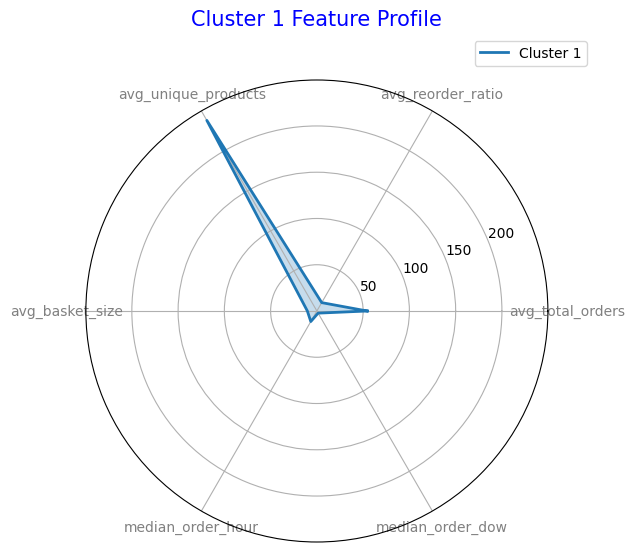

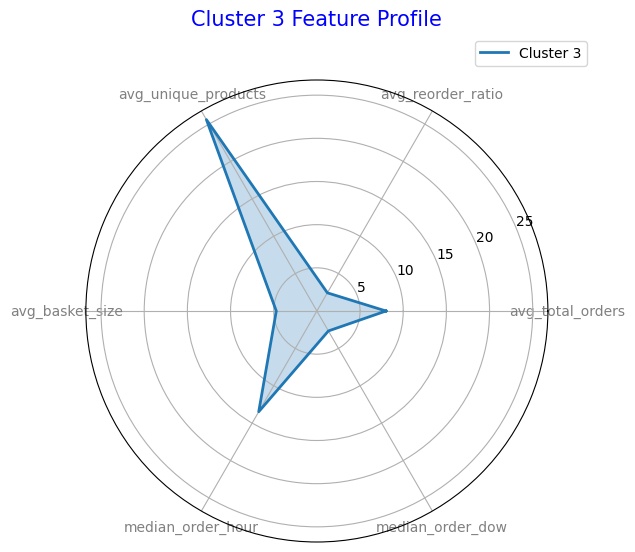

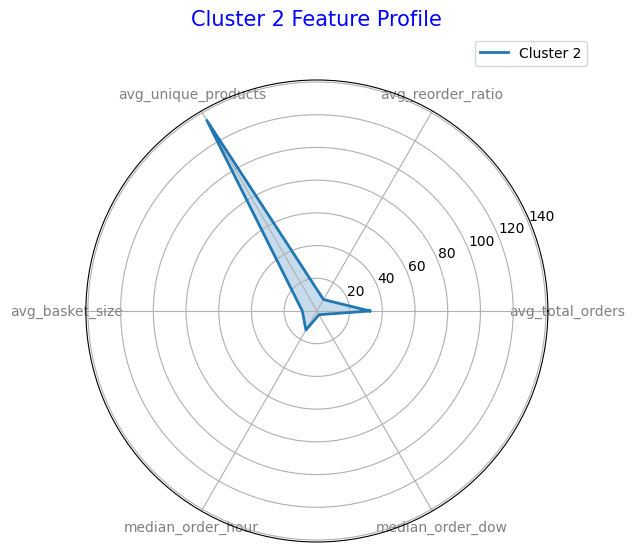

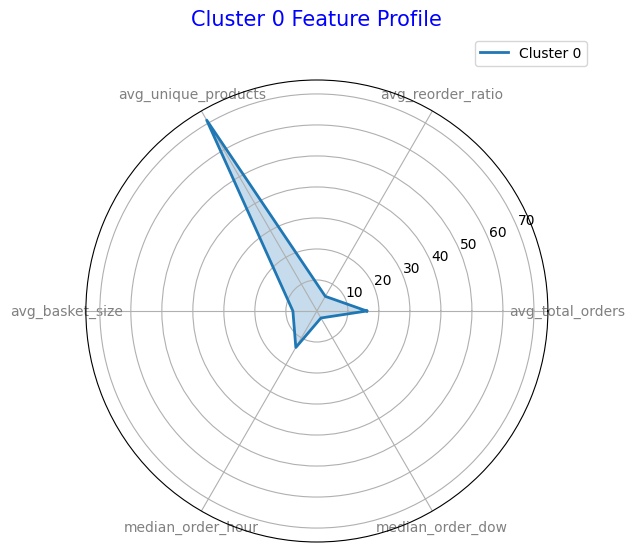

In [ ]:
# Visualizing Cluster Profiles with Radar Charts for k=4

from math import pi
import matplotlib.pyplot as plt

# Converting cluster centroids to Pandas DataFrame for plotting
cluster_centroids_pd = cluster_centroids_k4.toPandas()

# Printing to verify the structure
print(cluster_centroids_pd.head())

# Preparing data for radar chart
# Renaming the column for the cluster identifier to 'Cluster' for clarity
cluster_centroids_pd = cluster_centroids_pd.rename(columns={"prediction_k4": "Cluster"})

# Transposing for radar plot
radar_data = cluster_centroids_pd.set_index("Cluster").T
categories = radar_data.index.tolist()

# Radar chart for each cluster
for cluster in radar_data.columns:  # Iterate through clusters
    values = radar_data[cluster].values.flatten().tolist()
    values += values[:1]  # Close the loop for radar chart

    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]

    # Creating radar plot
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, color='grey', size=10)
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {cluster}")
    ax.fill(angles, values, alpha=0.25)
    plt.title(f"Cluster {cluster} Feature Profile", size=15, color="blue", y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.show()


In [ ]:
from pyspark.ml.clustering import KMeans

# Reapplying KMeans clustering for k=4
kmeans = KMeans(k=4, seed=1, featuresCol="features", predictionCol="prediction_k4")
user_features_k4 = kmeans.fit(user_features).transform(user_features)

# Verifying that `prediction_k4` is added
user_features_k4.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- total_orders: long (nullable = false)
 |-- total_reorders: long (nullable = true)
 |-- unique_products: long (nullable = false)
 |-- avg_basket_size: double (nullable = true)
 |-- median_order_hour: integer (nullable = true)
 |-- median_order_dow: integer (nullable = true)
 |-- reorder_ratio: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction_k4: integer (nullable = false)



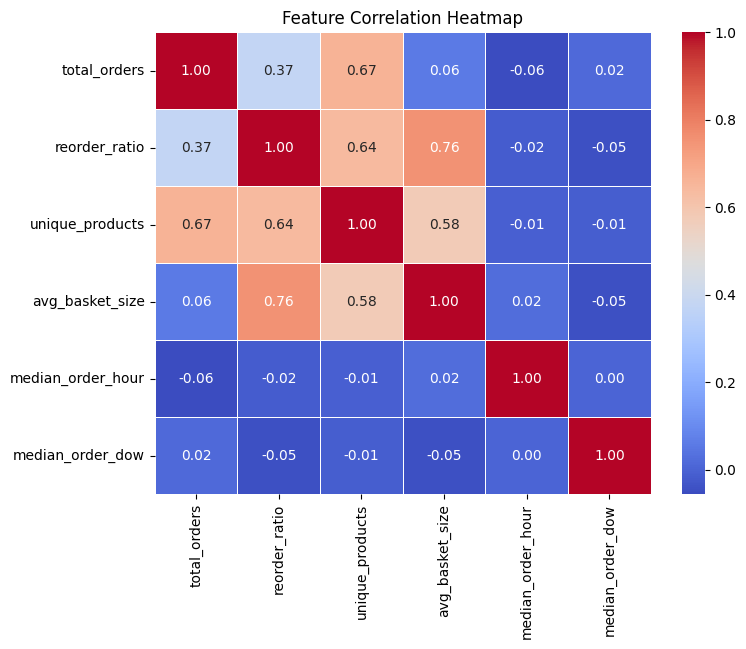

In [ ]:
# Analyzing Feature Interdependencies with a Correlation Heatmap

import seaborn as sns
import matplotlib.pyplot as plt

# Converting features and cluster assignments to Pandas
features_pd = user_features_k4.select(
    "total_orders",
    "reorder_ratio",
    "unique_products",
    "avg_basket_size",
    "median_order_hour",
    "median_order_dow",
    "prediction_k4"
).dropna().toPandas()  # Dropping rows with null values and converting to Pandas

# Renaming the cluster column for readability
features_pd = features_pd.rename(columns={"prediction_k4": "Cluster"})

# Calculating the correlation matrix
correlation_matrix = features_pd.drop("Cluster", axis=1).corr()  # Exclude cluster column for correlation calculation

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

Available columns in features_pd: Index(['total_orders', 'reorder_ratio', 'unique_products', 'avg_basket_size',
       'median_order_hour', 'median_order_dow', 'Cluster'],
      dtype='object')


<ipython-input-99-5a93e4a2e260>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=features_pd, x="Cluster", y=feature, palette="Set2")


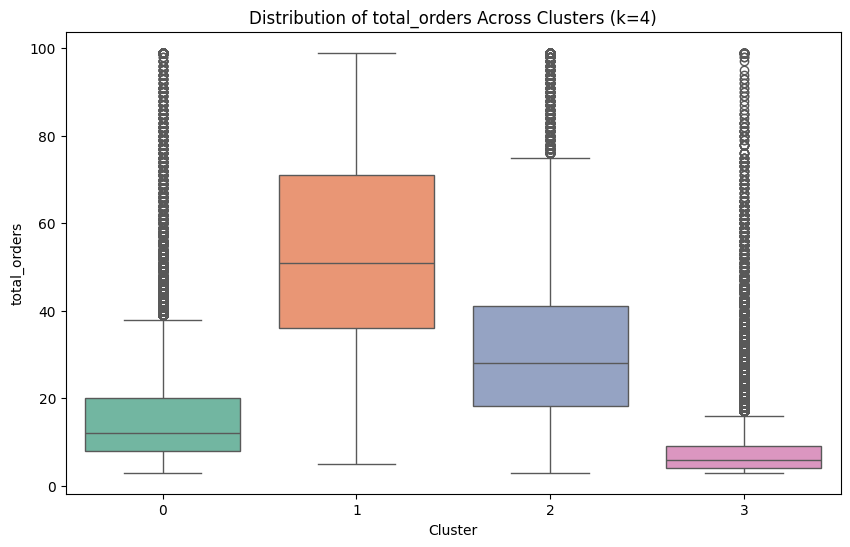

<ipython-input-99-5a93e4a2e260>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=features_pd, x="Cluster", y=feature, palette="Set2")


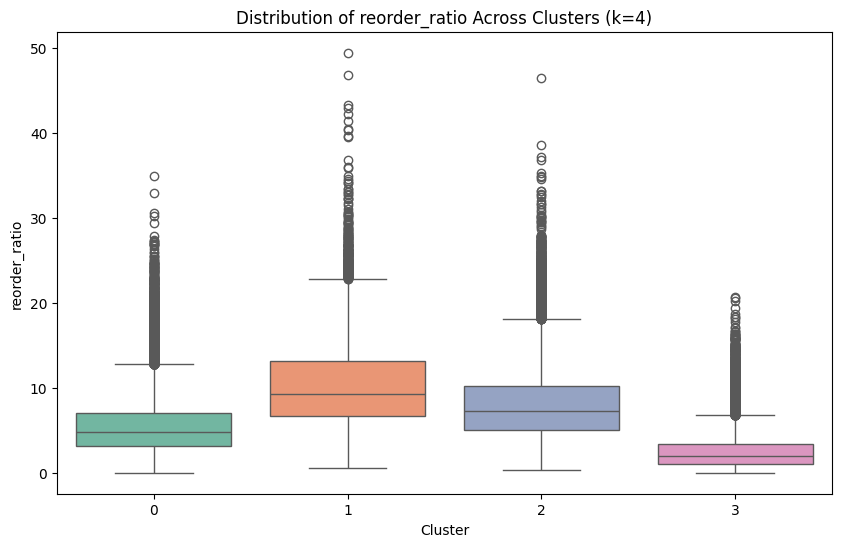

<ipython-input-99-5a93e4a2e260>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=features_pd, x="Cluster", y=feature, palette="Set2")


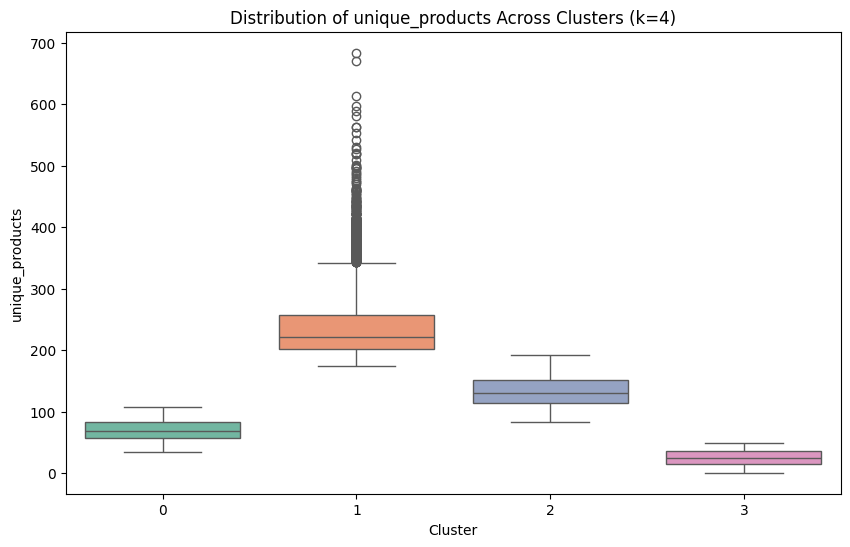

<ipython-input-99-5a93e4a2e260>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=features_pd, x="Cluster", y=feature, palette="Set2")


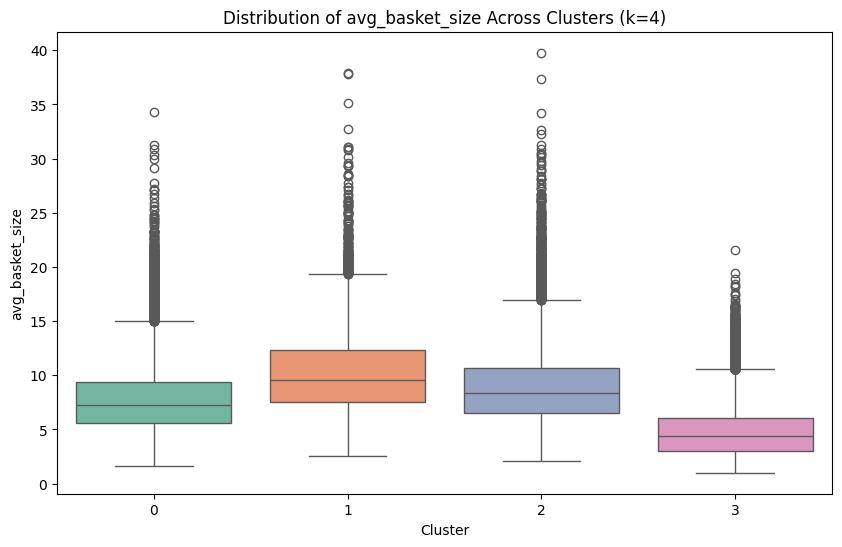

<ipython-input-99-5a93e4a2e260>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=features_pd, x="Cluster", y=feature, palette="Set2")


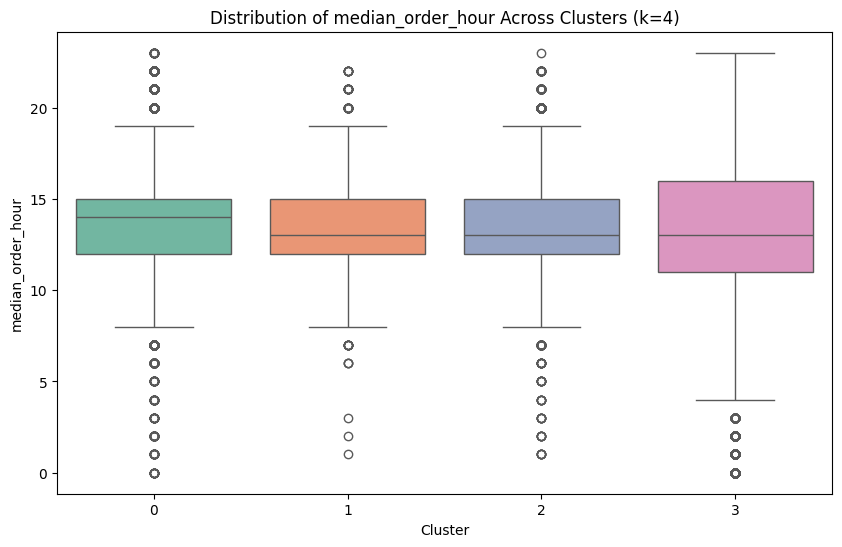

<ipython-input-99-5a93e4a2e260>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=features_pd, x="Cluster", y=feature, palette="Set2")


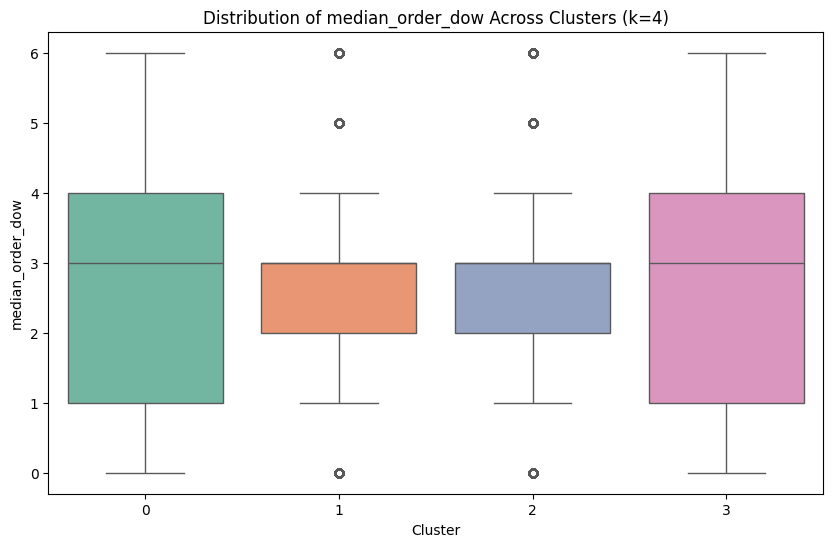

In [ ]:
# Cluster-Wise Feature Distributions: Boxplot Analysis for k=4

import seaborn as sns
import matplotlib.pyplot as plt

# Verifying that the expected columns exist in features_pd
print("Available columns in features_pd:", features_pd.columns)

# List of features to plot
features = [
    "total_orders",
    "reorder_ratio",
    "unique_products",
    "avg_basket_size",
    "median_order_hour",
    "median_order_dow"
]

# Iterating over features and create boxplots
for feature in features:
    if feature in features_pd.columns:  # Ensure the column exists
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=features_pd, x="Cluster", y=feature, palette="Set2")
        plt.title(f"Distribution of {feature} Across Clusters (k=4)")
        plt.xlabel("Cluster")
        plt.ylabel(feature)
        plt.show()
    else:
        print(f"Feature '{feature}' not found in DataFrame. Skipping...")

Available columns in cluster_centroids_pd: Index(['Cluster', 'avg_total_orders', 'avg_reorder_ratio',
       'avg_unique_products', 'avg_basket_size', 'median_order_hour',
       'median_order_dow'],
      dtype='object')


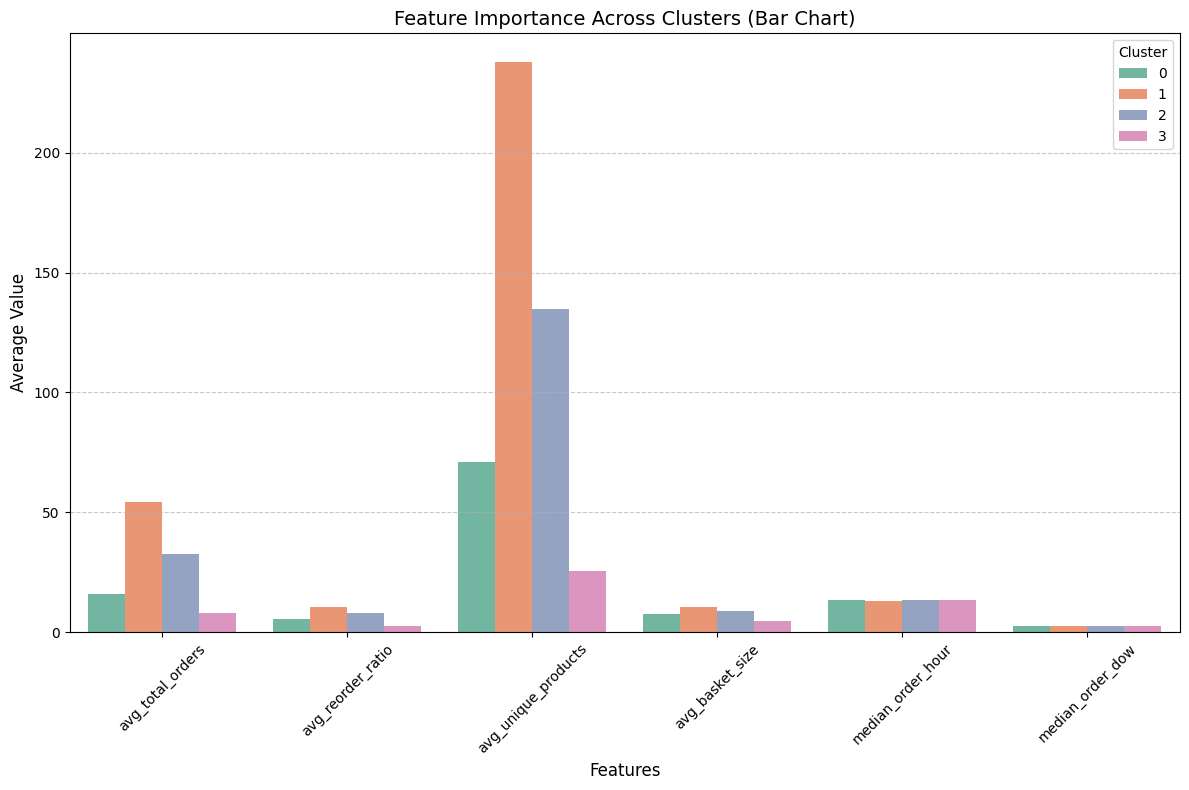

In [ ]:
# Cluster Feature Profiling: Comparative Bar Chart Analysis

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Verifying the structure of the cluster centroids DataFrame
print("Available columns in cluster_centroids_pd:", cluster_centroids_pd.columns)

# List of features to plot
features = [
    "avg_total_orders",
    "avg_reorder_ratio",
    "avg_unique_products",
    "avg_basket_size",
    "median_order_hour",
    "median_order_dow"
]

# Melting the DataFrame for easier plotting with grouped bar chart
cluster_centroids_melted = cluster_centroids_pd.melt(
    id_vars=["Cluster"],  # Ensure the 'Cluster' column corresponds to k=4
    value_vars=features,
    var_name="Feature",
    value_name="Average Value"
)

# Bar Chart
plt.figure(figsize=(12, 8))
sns.barplot(
    data=cluster_centroids_melted,
    x="Feature",
    y="Average Value",
    hue="Cluster",
    palette="Set2"
)

# Adding labels and title
plt.title("Feature Importance Across Clusters (Bar Chart)", fontsize=14)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Average Value", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Cluster", fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

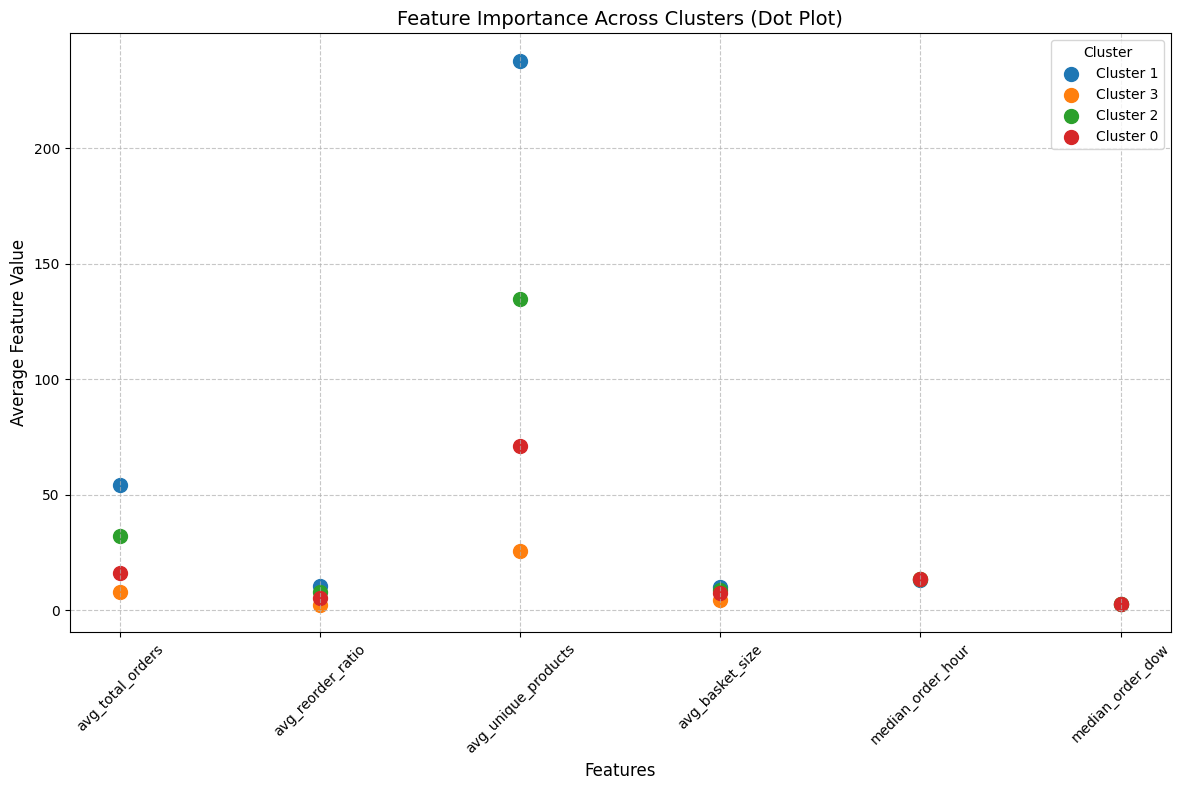

In [ ]:
# Cluster Feature Profiling: Comparative Dot Plot Analysis

import matplotlib.pyplot as plt

# Dot Plot
plt.figure(figsize=(12, 8))
for cluster in cluster_centroids_pd["Cluster"]:
    cluster_data = cluster_centroids_pd[cluster_centroids_pd["Cluster"] == cluster]
    plt.scatter(
        features,  # List of features
        cluster_data[features].values.flatten(),  # Average values for each feature
        label=f"Cluster {cluster}",
        s=100  # Size of dots
    )

# Adding labels and title
plt.title("Feature Importance Across Clusters (Dot Plot)", fontsize=14)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Average Feature Value", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Cluster", fontsize=10, loc="upper right")
plt.tight_layout()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

/content/spark-3.1.1-bin-hadoop3.2/python/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


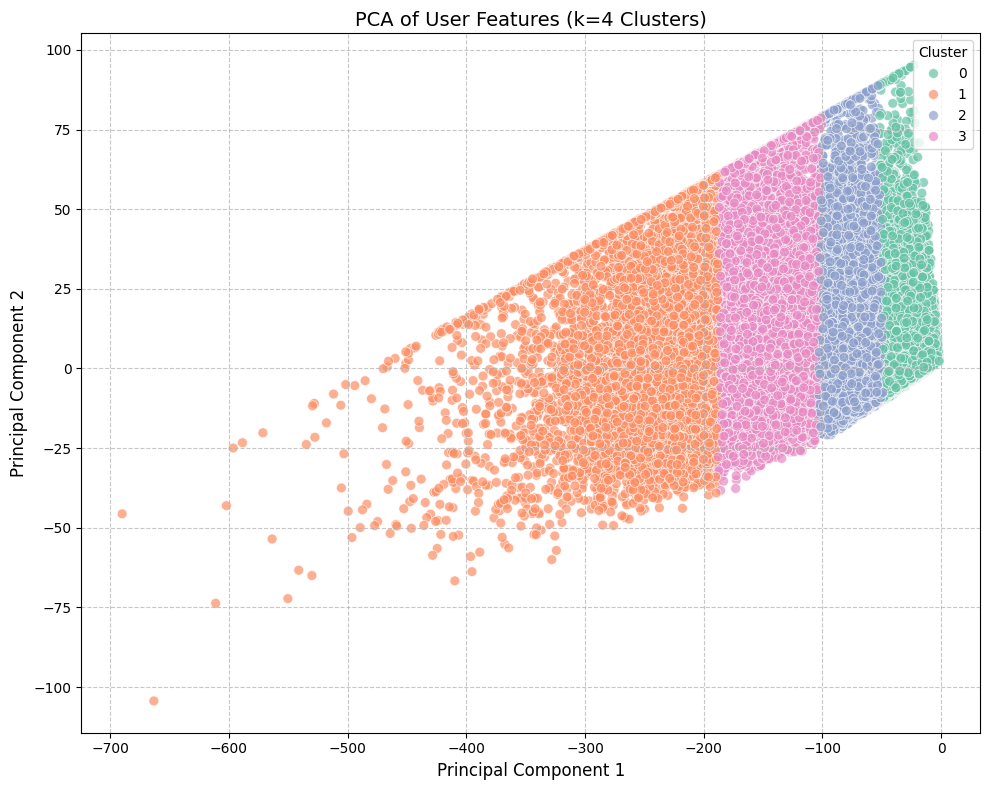

In [ ]:
# PCA Visualization of User Features with k=4 Clusters

from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Ensuring `prediction_k4` is included in the user_features DataFrame
user_features_with_clusters = user_features.join(
    user_features_k4.select("user_id", "prediction_k4"), on="user_id", how="inner"
)

# Applying PCA in PySpark
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(user_features_with_clusters)
user_features_pca = pca_model.transform(user_features_with_clusters)

# Converting to Pandas for plotting
pca_df = user_features_pca.select("pcaFeatures", "prediction_k4").toPandas()

# Extracting PCA components into separate columns
pca_df[['pc1', 'pc2']] = pd.DataFrame(pca_df['pcaFeatures'].tolist(), index=pca_df.index)

# Renaming `prediction_k4` for clarity in the plot
pca_df = pca_df.rename(columns={"prediction_k4": "Cluster"})

# Plotting the PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='pc1',
    y='pc2',
    hue='Cluster',
    data=pca_df,
    palette='Set2',
    s=50,
    alpha=0.7
)
plt.title('PCA of User Features (k=4 Clusters)', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Cluster', fontsize=10, loc="upper right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


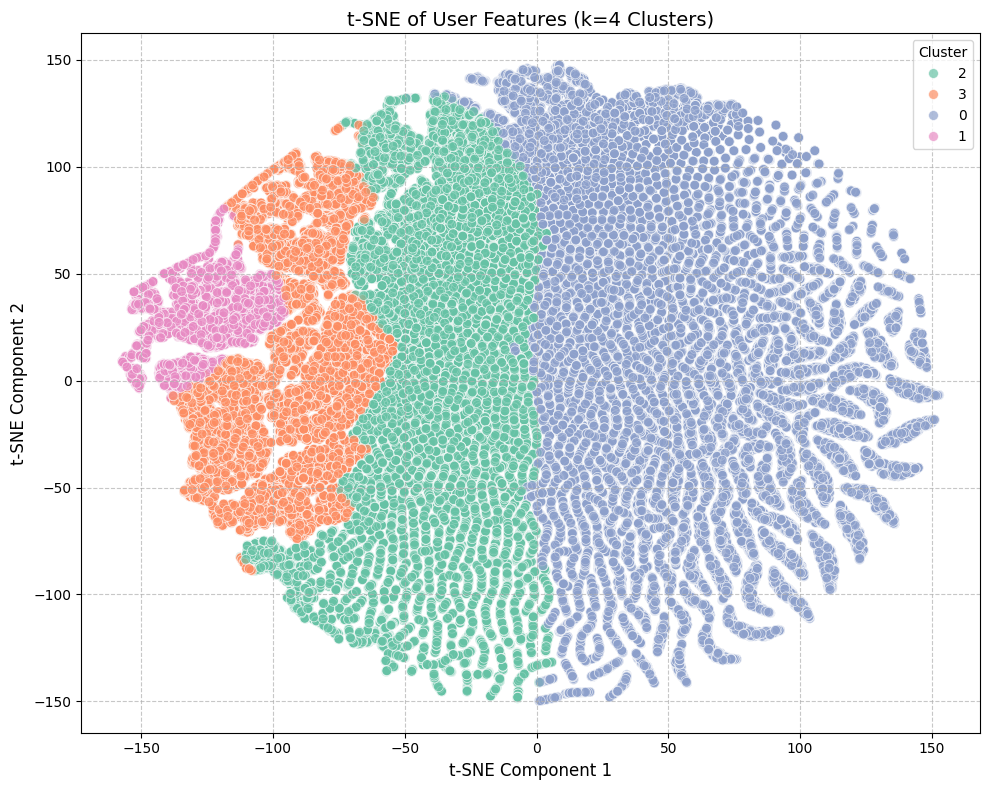

In [ ]:
# t-SNE Visualization of User Features with k=4 Clusters

from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extracting features and cluster labels
features = pca_df[['pc1', 'pc2']].values  # Use PCA-reduced features as input
labels = pca_df['Cluster'].astype(str).values  # Convert cluster labels to string for visualization

# Applying t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, init='pca', learning_rate='auto')
tsne_results = tsne.fit_transform(features)

# Creating a DataFrame for t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
tsne_df['Cluster'] = labels

# Plotting t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='tsne1',
    y='tsne2',
    hue='Cluster',
    data=tsne_df,
    palette='Set2',
    s=50,
    alpha=0.7
)
plt.title('t-SNE of User Features (k=4 Clusters)', fontsize=14)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend(title='Cluster', fontsize=10, loc="upper right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

ALS

In [ ]:
# Helper Functions for Evaluating ALS Model Performance with Ranking Metric

from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F
import time
import math

# Timer functions
def timer_start(label):
    print(f"Starting {label}...")
    return time.time()

def timer_end(label, start_time):
    elapsed = time.time() - start_time
    print(f"Finished {label}. Elapsed time: {elapsed:.2f} seconds\n")
    return elapsed

# Ranking Evaluator
class RankingEvaluator:
    def __init__(self, k=5):
        self.k = k

    def evaluate(self, predictions):
        results = predictions.select("user_id", "product_id", "prediction").groupBy("user_id").agg(
            F.collect_list("product_id").alias("true_items"),
            F.collect_list("prediction").alias("predicted_scores")
        ).rdd.map(self.ndcg_at_k).mean()
        return results

    def ndcg_at_k(self, row):
        true_items = set(row["true_items"])
        predicted_items = sorted(
            zip(row["predicted_scores"], row["true_items"]),
            key=lambda x: -x[0]
        )[:self.k]

        dcg = 0.0
        idcg = self.calculate_idcg(len(true_items))

        for i, (_, item) in enumerate(predicted_items, start=1):
            if item in true_items:
                dcg += 1 / math.log2(i + 1)

        return dcg / idcg if idcg > 0 else 0.0

    @staticmethod
    def calculate_idcg(n):
        return sum((1 / math.log2(i + 1)) for i in range(1, n + 1))


In [ ]:
# Loading and Processing Data
start = timer_start("Loading and Processing Dataset")

# Including product_id and filter nulls
als_df = full_df.select("order_id", "user_id", "product_id", "reordered").filter(
    F.col("user_id").isNotNull() & F.col("product_id").isNotNull()
).withColumn(
    "rating", F.col("reordered").cast("int")  # Convert 'reordered' to integer for ALS
)

timer_end("Loading and Processing Dataset", start)

Starting Loading and Processing Dataset...
Finished Loading and Processing Dataset. Elapsed time: 0.03 seconds



0.03244662284851074

In [ ]:
# Stratified Split for ALS Training and Testing Data Based on User Activity

start = timer_start("Stratified Split")

# Computing activity threshold based on user activity
activity_threshold = als_df.groupBy("user_id").count().approxQuantile("count", [0.5], 0.1)[0]

# Splitting users into high and low activity groups
high_activity_users = als_df.groupBy("user_id").count().filter(F.col("count") >= activity_threshold).select("user_id")
low_activity_users = als_df.groupBy("user_id").count().filter(F.col("count") < activity_threshold).select("user_id")

# Filtering ALS dataset into high and low activity subsets
high_activity_data = als_df.join(high_activity_users, on="user_id")
low_activity_data = als_df.join(low_activity_users, on="user_id")

# Splitting data into training and testing sets for high and low activity users
train_high, test_high = high_activity_data.randomSplit([0.8, 0.2], seed=42)
train_low, test_low = low_activity_data.randomSplit([0.8, 0.2], seed=42)

# Combining training and testing datasets
train_data = train_high.union(train_low).cache()
test_data = test_high.union(test_low).cache()

# Ensuring `product_id` and `user_id` in both train and test datasets
test_data = test_data.join(train_data.select("user_id").distinct(), "user_id", "inner")
test_data = test_data.join(train_data.select("product_id").distinct(), "product_id", "inner")

# Verifying schemas
train_data.printSchema()
test_data.printSchema()

timer_end("Stratified Split", start)

Starting Stratified Split...
root
 |-- user_id: integer (nullable = true)
 |-- order_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- reordered: integer (nullable = true)
 |-- rating: integer (nullable = true)

root
 |-- product_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- order_id: integer (nullable = true)
 |-- reordered: integer (nullable = true)
 |-- rating: integer (nullable = true)

Finished Stratified Split. Elapsed time: 33.10 seconds



33.095794916152954

In [ ]:
# Selecting Relevant Columns for ALS Model Training and Testing Datasets

train_data = train_data.select("user_id", "order_id", "product_id", "reordered", "rating")
test_data = test_data.select("user_id", "order_id", "product_id", "reordered", "rating")

In [ ]:
# Determining Maximum Interaction Thresholds for Users and Products

max_interactions_per_user = user_interactions.approxQuantile("count", [0.9], 0.01)[0]
max_interactions_per_product = product_interactions.approxQuantile("count", [0.9], 0.01)[0]

In [ ]:
print(f"Max interactions per user: {max_interactions_per_user}")
print(f"Max interactions per product: {max_interactions_per_product}")

Max interactions per user: 291.0
Max interactions per product: 727.0


In [ ]:
# Preprocessing Training Data with Interaction Thresholds and Test-Train Validation

# Dynamically cap maximum interactions per user and product in train_data
max_interactions_per_user = user_interactions.approxQuantile("count", [0.9], 0.01)[0]
max_interactions_per_product = product_interactions.approxQuantile("count", [0.9], 0.01)[0]

train_data = train_data \
    .withColumn("user_row_num", F.row_number().over(Window.partitionBy("user_id").orderBy(F.desc("rating")))) \
    .filter(F.col("user_row_num") <= max_interactions_per_user) \
    .drop("user_row_num")

train_data = train_data \
    .withColumn("product_row_num", F.row_number().over(Window.partitionBy("product_id").orderBy(F.desc("rating")))) \
    .filter(F.col("product_row_num") <= max_interactions_per_product) \
    .drop("product_row_num")

# Filtering rare products
min_product_interactions = 10
train_data = train_data.groupBy("product_id").count() \
    .filter(F.col("count") >= min_product_interactions) \
    .join(train_data, on="product_id")

# Revalidating train-test overlap after preprocessing
test_data = test_data.join(train_data.select("user_id").distinct(), "user_id", "inner")
test_data = test_data.join(train_data.select("product_id").distinct(), "product_id", "inner")

In [ ]:
# Building ALS Model with Cross-Validation

# Removing null ratings if any
train_data = train_data.filter(F.col("rating").isNotNull())
test_data = test_data.filter(F.col("rating").isNotNull())

# Initializing ALS Model for Cross-Validation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

start = timer_start("Cross-Validation Setup")

als = ALS(
    userCol="user_id",
    itemCol="product_id",
    ratingCol="rating",
    coldStartStrategy="drop",  # Drop rows with null predictions
    nonnegative=True,
    implicitPrefs=True
)

# Parameter grid for ALS tuning
param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [10, 20, 40]) \
    .addGrid(als.regParam, [0.05, 0.1, 0.5]) \
    .addGrid(als.alpha, [0.1, 0.5, 1.0]) \
    .build()

# CrossValidator setup
crossval = CrossValidator(
    estimator=als,
    estimatorParamMaps=param_grid,
    evaluator=RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction"),
    numFolds=2,  # 2-fold cross-validation
    parallelism=4  # Number of threads for parallelism
)

# Fitting the ALS model using cross-validation
cv_model = crossval.fit(train_data)
timer_end("Cross-Validation Setup", start)

Starting Cross-Validation Setup...
Finished Cross-Validation Setup. Elapsed time: 2482.14 seconds



2482.140029191971

In [ ]:
# Best model from cross-validation
best_model = cv_model.bestModel

# Generate predictions using the best model
predictions = best_model.transform(test_data)

# Evaluate RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Best Model RMSE: {rmse}")

Best Model RMSE: 0.7309261618507933


In [ ]:
# Evaluating Model Performance: Calculating Precision@K for Recommendations

from pyspark.sql.functions import collect_list, col

# Grouping predictions and actual ratings
predicted = predictions.groupBy("user_id").agg(
    collect_list("product_id").alias("predicted_items")
)

actual = test_data.groupBy("user_id").agg(
    collect_list("product_id").alias("actual_items")
)

# Joining predictions and actuals
evaluation_data = predicted.join(actual, "user_id")

# Calculating Precision@K
def precision_at_k(row, k=5):
    predicted = set(row["predicted_items"][:k])
    actual = set(row["actual_items"])
    return len(predicted & actual) / k if k > 0 else 0.0

precision_k = evaluation_data.rdd.map(lambda row: precision_at_k(row, k=5)).mean()
print(f"Precision@5: {precision_k}")


Precision@5: 0.8011650191648179


In [ ]:
if not best_model:
    print("Error: ALS model has not been trained. Ensure the previous steps were executed.")

In [ ]:
if train_data.rdd.isEmpty():
    print("Error: Training data is empty. Check the input dataset.")

In [ ]:
# Generating and Saving Recommendations Using ALS Model
start = timer_start("Recommendation Generation")

# Generating Recommendations for all users
user_recommendations = best_model.recommendForAllUsers(5)

# Checking if recommendations were generated
if user_recommendations.rdd.isEmpty():
    print("No recommendations generated. Skipping save step.")
else:
    exploded_recommendations = user_recommendations.withColumn(
        "recommendation", F.explode("recommendations")
    ).select(
        "user_id",
        F.col("recommendation.product_id").alias("product_id"),
        F.col("recommendation.rating").alias("rating")
    )

    # Saving recommendations to file
    recommendations_path = "/output_path/file_name.csv"
    exploded_recommendations.coalesce(1) \
        .write \
        .mode("overwrite") \
        .option("header", "true") \
        .csv(recommendations_path)

    # Logging the total number of recommendations
    record_count = exploded_recommendations.count()
    print(f"Total recommendations saved: {record_count}")
    print(f"Recommendations saved to: {recommendations_path}")

timer_end("Recommendation Generation", start)


In [ ]:
# Evaluation Metrics: Precision@K, Average Precision, and Reciprocal Rank Functions

from pyspark.sql import functions as F

def precision_at_k(predicted, actual, k):
    predicted_at_k = predicted[:k]
    return len(set(predicted_at_k) & set(actual)) / len(predicted_at_k)

def average_precision(predicted, actual):
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / (1.0 if len(actual) == 0 else len(actual))

def reciprocal_rank(predicted, actual):
    for i, p in enumerate(predicted):
        if p in actual:
            return 1.0 / (i + 1.0)
    return 0.0


In [ ]:
# Displaying top recommendations for a few users
exploded_recommendations.show(10, truncate=False)

+-------+----------+----------+
|user_id|product_id|rating    |
+-------+----------+----------+
|148    |32018     |0.16970679|
|148    |38141     |0.16966885|
|148    |4962      |0.16955255|
|148    |23025     |0.16908081|
|148    |17622     |0.16818465|
|463    |46979     |0.2357881 |
|463    |38220     |0.23515071|
|463    |47209     |0.23474969|
|463    |49118     |0.23401655|
|463    |48935     |0.23355326|
+-------+----------+----------+
only showing top 10 rows



In [ ]:
# Enriching recommendations with product names
recommendations_with_products = exploded_recommendations.join(
    products_df.select("product_id", "product_name_ref"),  # Correct column name
    "product_id",
    "left"
)

# Displaying enriched recommendations
recommendations_with_products.show(10, truncate=False)

+----------+-------+----------+----------------------------------------------------------------------------+
|product_id|user_id|rating    |product_name_ref                                                            |
+----------+-------+----------+----------------------------------------------------------------------------+
|32018     |148    |0.16970679|Organic Fiber & Protein Pear Blueberry & Spinach Baby Food                  |
|38141     |148    |0.16966885|Fiber & Protein Organic Pears, Raspberries, Butternut Squash & Carrots Snack|
|4962      |148    |0.16955255|Yotoddler Organic Pear Spinach Mango Yogurt                                 |
|23025     |148    |0.16908081|Organic Stage 4 Green Bean Pear & Pea Baby Food                             |
|17622     |148    |0.16818465|Wholesome Breakfast Blueberry Banana                                        |
|46979     |463    |0.2357881 |Asparagus                                                                   |
|38220     |463    

In [ ]:
# Example: Checking recommendations for a specific user
user_id_to_check = 12345
recommendations_with_products.filter(F.col("user_id") == user_id_to_check).show()


+----------+-------+-----------+--------------------+
|product_id|user_id|     rating|    product_name_ref|
+----------+-------+-----------+--------------------+
|      9292|  12345|0.060039207|Half And Half Ult...|
|     48370|  12345|0.052916612|Sensitive Toilet ...|
|     41771|  12345| 0.05229991|Fresh European St...|
|      1447|  12345|0.051548067|Organic Baby Lett...|
|     27514|  12345|0.050305538|Maple Glazed Hone...|
+----------+-------+-----------+--------------------+



In [ ]:
# Aggregating recommendations by product
top_recommended_products = recommendations_with_products.groupBy("product_id", "product_name_ref").count().orderBy(F.desc("count"))
top_recommended_products.show(10, truncate=False)


+----------+-----------------------------------------------------+-----+
|product_id|product_name_ref                                     |count|
+----------+-----------------------------------------------------+-----+
|60        |Cheesy Creations Roasted Garlic Parmesan Sauce       |21417|
|40        |Beef Hot Links Beef Smoked Sausage With Chile Peppers|21417|
|30        |Three Cheese Ziti, Marinara with Meatballs           |21417|
|10        |Sparkling Orange Juice & Prickly Pear Beverage       |21417|
|50        |Pumpkin Muffin Mix                                   |21417|
|19604     |Medium Scarlet Raspberries                           |11067|
|41722     |Original Thin Pepperoni Pizza                        |10086|
|28632     |Premium Sweet Petites Carrots                        |10067|
|49279     |Turkey Store Lean Ground Turkey                      |9589 |
|31985     |Beefsteak Tomatoes                                   |8384 |
+----------+---------------------------------------

In [ ]:
# Filtering and Displaying Recommendations for Frequent Users (Users with >50 Orders)

from pyspark.sql import functions as F

# Calculating total orders per user
user_total_orders = als_df.groupBy("user_id").agg(
    F.countDistinct("order_id").alias("total_orders")
)

# Filtering users with more than 50 total orders
frequent_users = user_total_orders.filter(F.col("total_orders") > 50).select("user_id")

# Getting recommendations for these frequent users
frequent_user_recommendations = recommendations_with_products.join(frequent_users, "user_id", "inner")

# Showing recommendations for frequent users
frequent_user_recommendations.show(10, truncate=False)



+-------+----------+---------+----------------------------+
|user_id|product_id|rating   |product_name_ref            |
+-------+----------+---------+----------------------------+
|496    |46979     |1.3233001|Asparagus                   |
|496    |38220     |1.3197229|Baby Artichokes             |
|496    |47209     |1.3177072|Organic Hass Avocado        |
|496    |49118     |1.3133577|Cilantro                    |
|496    |48935     |1.3119159|Organic Pecans              |
|3794   |44632     |1.0927553|Sparkling Water Grapefruit  |
|3794   |35221     |1.0728197|Lime Sparkling Water        |
|3794   |48935     |1.0022589|Organic Pecans              |
|3794   |42972     |1.0016187|Natural Pure Sparkling Water|
|3794   |48628     |0.9862957|Organic Whole Wheat Bread   |
+-------+----------+---------+----------------------------+
only showing top 10 rows



In [ ]:
# Finding the most active users
top_active_users = user_total_orders.orderBy(F.desc("total_orders")).limit(10)

# Getting recommendations for the most active users
top_active_user_recommendations = recommendations_with_products.join(top_active_users, "user_id", "inner")

# Showing recommendations for the top active users
top_active_user_recommendations.show(20, truncate=False)


+-------+----------+---------+------------------------------------+------------+
|user_id|product_id|rating   |product_name_ref                    |total_orders|
+-------+----------+---------+------------------------------------+------------+
|8086   |28199     |1.3935187|Clementines, Bag                    |99          |
|8086   |12341     |1.2688835|Hass Avocados                       |99          |
|8086   |13575     |1.259475 |Apples                              |99          |
|8086   |34024     |1.2336136|Classic Soda                        |99          |
|8086   |38928     |1.2016126|0% Greek Strained Yogurt            |99          |
|65220  |19057     |1.0049902|Organic Large Extra Fancy Fuji Apple|99          |
|65220  |22035     |0.9919027|Organic Whole String Cheese         |99          |
|65220  |38121     |0.9877484|D'Anjou Pears                       |99          |
|65220  |8277      |0.9594962|Apple Honeycrisp Organic            |99          |
|65220  |39408     |0.949198

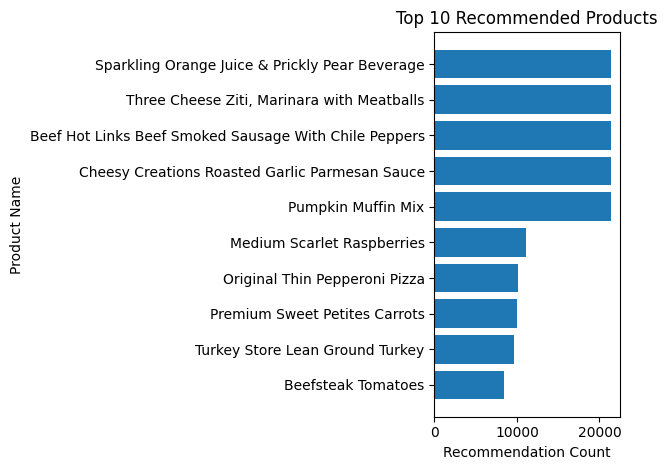

In [ ]:
# Converting Spark DataFrame to Pandas for visualization
top_products_df = top_recommended_products.limit(10).toPandas()

import matplotlib.pyplot as plt

# Creating a horizontal bar chart
plt.barh(top_products_df["product_name_ref"], top_products_df["count"])
plt.xlabel("Recommendation Count")
plt.ylabel("Product Name")
plt.title("Top 10 Recommended Products")
plt.gca().invert_yaxis()  # Reverse y-axis for better readability
plt.tight_layout()
plt.show()


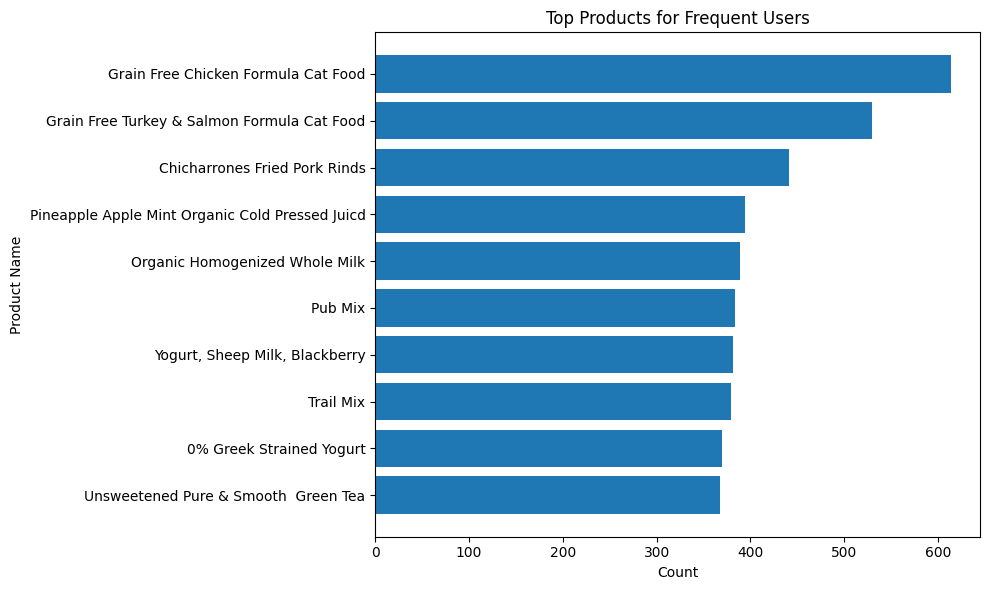

In [ ]:
from pyspark.sql import functions as F

# Calculating total orders per user
user_total_orders = als_df.groupBy("user_id").agg(
    F.countDistinct("order_id").alias("total_orders")
)

# Filtering users with more than 50 total orders
frequent_users = user_total_orders.filter(F.col("total_orders") > 50).select("user_id")

# Getting recommendations for frequent users
frequent_user_recommendations = exploded_recommendations.join(frequent_users, "user_id", "inner")

# Aggregating recommendations to find top products for frequent users
frequent_users_top_products = frequent_user_recommendations.groupBy("product_id").agg(
    F.count("user_id").alias("count")
).join(
    products_df.select("product_id", "product_name_ref"), "product_id", "left"
).orderBy(F.desc("count"))


# Converting to Pandas for visualization
frequent_users_top_products_df = frequent_users_top_products.limit(10).toPandas()

# Creating a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(frequent_users_top_products_df["product_name_ref"], frequent_users_top_products_df["count"])
plt.xlabel("Count")
plt.ylabel("Product Name")
plt.title("Top Products for Frequent Users")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



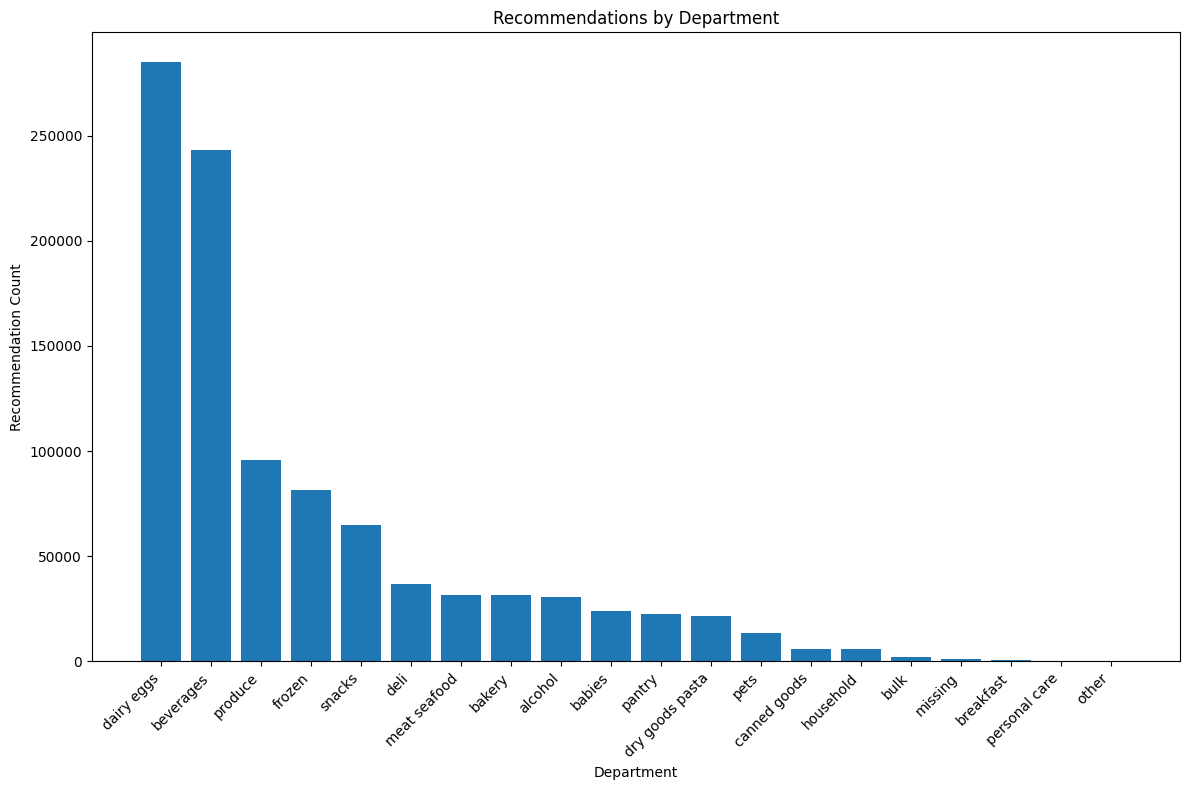

In [ ]:
# Recommendations by Department

# Renaming columns for alignment
departments_df_renamed = departments_df.withColumnRenamed("department_id_ref", "department_id").withColumnRenamed("department_name_ref", "department_name")

products_with_department = products_df.withColumnRenamed("product_department_id_ref", "department_id").join(
    departments_df_renamed, "department_id", "left"
)

# Aggregating recommendations by department
recommendations_by_department = recommendations_with_products.join(
    products_with_department.select("product_id", "department_name"),
    "product_id",
    "left"
).groupBy("department_name").count().orderBy(F.desc("count"))

# Converting to Pandas
recommendations_by_department_df = recommendations_by_department.toPandas()

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.bar(recommendations_by_department_df["department_name"], recommendations_by_department_df["count"])
plt.xlabel("Department")
plt.ylabel("Recommendation Count")
plt.title("Recommendations by Department")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.sql import functions as F

In [ ]:
als_df = als_df.filter(F.col("reordered").isNotNull())

In [ ]:
product_features = als_df.groupBy("product_id").agg(
    F.count("reordered").alias("popularity"),
    F.avg("reordered").alias("product_reorder_ratio")
)

In [ ]:
product_features = product_features.withColumnRenamed("product_reorder_ratio", "avg_product_reorder_ratio")

In [ ]:
print(product_features)

+----------+----------+-------------------------+
|product_id|popularity|avg_product_reorder_ratio|
+----------+----------+-------------------------+
|       463|        32|                    0.125|
|       471|       138|       0.5652173913043478|
|       496|        37|       0.3783783783783784|
|       833|        12|      0.08333333333333333|
|      1088|        44|      0.36363636363636365|
|      1238|        19|       0.2631578947368421|
|      1342|        11|       0.2727272727272727|
|      1580|         4|                      0.0|
|      1591|        18|       0.2777777777777778|
|      1645|        27|      0.14814814814814814|
|      1829|        10|                      0.1|
|      1959|        33|       0.3939393939393939|
|      2122|         5|                      0.0|
|      2142|        57|       0.8596491228070176|
|      2366|       106|      0.24528301886792453|
|      2659|        34|      0.23529411764705882|
|      2866|       110|      0.08181818181818182|


In [ ]:
user_features.describe()

+-------+-----------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+
|summary|          user_id|      total_orders|    total_reorders|  unique_products|   avg_basket_size| median_order_hour| median_order_dow|    reorder_ratio|
+-------+-----------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+
|  count|           206209|            206209|            206209|           206209|            206209|            206209|           206209|           206209|
|   mean|         103105.0|15.590367054784224| 92.75315820357017|62.55945181830085| 6.419986969084881| 13.48410108191204|2.641426901832607|4.438045676895516|
| stddev|59527.55516705405|16.654773501154423|158.40041278669975|54.22856276819751|3.3207953027402364|2.8664658622087624|1.568720155635586|3.790584603539414|
|    min|                1|                 3|                 0|                1|               1.0|                 0|                0|              0.0|
|    max|           206209|                99|              3275|              684| 39.77580071174377|                23|                6|        49.484375|
+-------+-----------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+

In [ ]:
als_df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- order_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- reordered: integer (nullable = true)
 |-- rating: integer (nullable = true)



In [ ]:
# Temporal Features

from pyspark.sql import functions as F

# Adding order hour and day of the week information to als_df
als_df = als_df.join(
    orders_df.select("user_id", "order_id", "order_hour_of_day", "order_dow"),
    on=["user_id", "order_id"],
    how="left"
)

# Adding "new_order_hour_of_day" and "new_order_dow" for downstream analysis
als_df = als_df.join(
    orders_df.select(
        "user_id", "order_id",
        F.col("order_hour_of_day").alias("new_order_hour_of_day"),
        F.col("order_dow").alias("new_order_dow")
    ),
    on=["user_id", "order_id"],
    how="left"
)

In [ ]:
# Aggregating user-level features from als_df
user_features = als_df.groupBy("user_id").agg(
    F.countDistinct("order_id").alias("total_orders"),  # Total unique orders
    F.avg("reordered").alias("avg_reorder_ratio"),  # Average reorder ratio
    F.expr("percentile_approx(order_hour_of_day, 0.5)").alias("median_order_hour"),
    F.expr("percentile_approx(order_dow, 0.5)").alias("median_order_dow")
)

In [ ]:
# Combining features with main dataset
als_enhanced_df = als_df.join(user_features, "user_id").join(product_features, "product_id")

# Feature Engineering
als_enhanced_df = als_enhanced_df.withColumn(
    "basket_reorder_interaction",
    F.col("avg_reorder_ratio") * F.col("total_orders")
).withColumn(
    "peak_activity_time",
    F.concat(F.col("median_order_hour").cast("string"), F.lit("_"), F.col("median_order_dow").cast("string"))
).withColumn(
    "shopping_behavior",
    F.when(F.col("avg_reorder_ratio") > 0.5, "Loyalist").when(
        F.col("popularity") > 50, "Explorer"
    ).otherwise("General")
)

In [ ]:
# Filling null values
als_enhanced_df = als_enhanced_df.fillna({"avg_reorder_ratio": 0, "total_orders": 0})

# Limiting the data to avoid memory issues
als_sampled_df = als_enhanced_df.sample(fraction=0.2, seed=42)

# Saving sampled data
als_sampled_df.coalesce(1).write.csv("file_path/file_name", header=True, mode="overwrite")


In [ ]:
import pandas as pd

# Loading saved data
als_data = pd.read_csv("file_path")

# Preparing features and target
features = ["total_orders", "avg_reorder_ratio", "popularity", "product_reorder_ratio",
            "basket_reorder_interaction", "peak_activity_time", "shopping_behavior"]

X = als_data[features]
y = als_data["reordered"]

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
X.loc[:, "shopping_behavior"] = encoder.fit_transform(X["shopping_behavior"])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
# Checking for nulls
assert X_train.isnull().sum().sum() == 0, "X_train contains null values"
assert y_train.isnull().sum() == 0, "y_train contains null values"

# Checking data distribution
print(y_train.value_counts(normalize=True))

reordered
1    0.589757
0    0.410243
Name: proportion, dtype: float64


In [ ]:
print(X_train.dtypes)  # Ensuring all are numeric

total_orders                    int64
avg_reorder_ratio             float64
popularity                      int64
product_reorder_ratio         float64
basket_reorder_interaction    float64
peak_activity_time             object
shopping_behavior              object
dtype: object


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X_train["peak_activity_time"] = le.fit_transform(X_train["peak_activity_time"])
X_test["peak_activity_time"] = le.transform(X_test["peak_activity_time"])

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encoding categorical column
label_encoder = LabelEncoder()
X_train['shopping_behavior'] = label_encoder.fit_transform(X_train['shopping_behavior'])
X_test['shopping_behavior'] = label_encoder.transform(X_test['shopping_behavior'])

In [ ]:
print(X_train.dtypes)

total_orders                    int64
avg_reorder_ratio             float64
popularity                      int64
product_reorder_ratio         float64
basket_reorder_interaction    float64
peak_activity_time              int64
shopping_behavior               int64
dtype: object


In [ ]:
pip install xgboost

In [ ]:
# Hyperparameter Tuning and Evaluation of XGBoost Classifier

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Initializing XGBoost classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")

# Defining parameter grid
param_dist = {
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 6, 9],
    "n_estimators": [50, 100, 200],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# Performing Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=25,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

Fitting 3 folds for each of 25 candidates, totalling 75 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:09:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.54      0.61    266348
           1       0.72      0.82      0.77    382637

    accuracy                           0.71    648985
   macro avg       0.70      0.68      0.69    648985
weighted avg       0.71      0.71      0.70    648985

ROC-AUC Score: 0.7660


In [ ]:
# Predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.54      0.61    266348
           1       0.72      0.82      0.77    382637

    accuracy                           0.71    648985
   macro avg       0.70      0.68      0.69    648985
weighted avg       0.71      0.71      0.70    648985

ROC-AUC Score: 0.7660


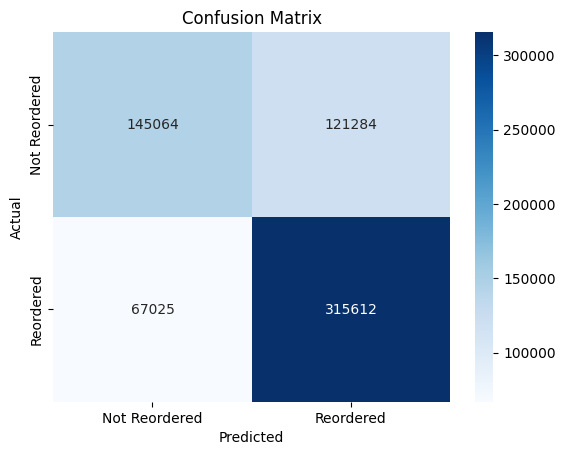

In [ ]:
# Generating and plotting confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Reordered", "Reordered"],
            yticklabels=["Not Reordered", "Reordered"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


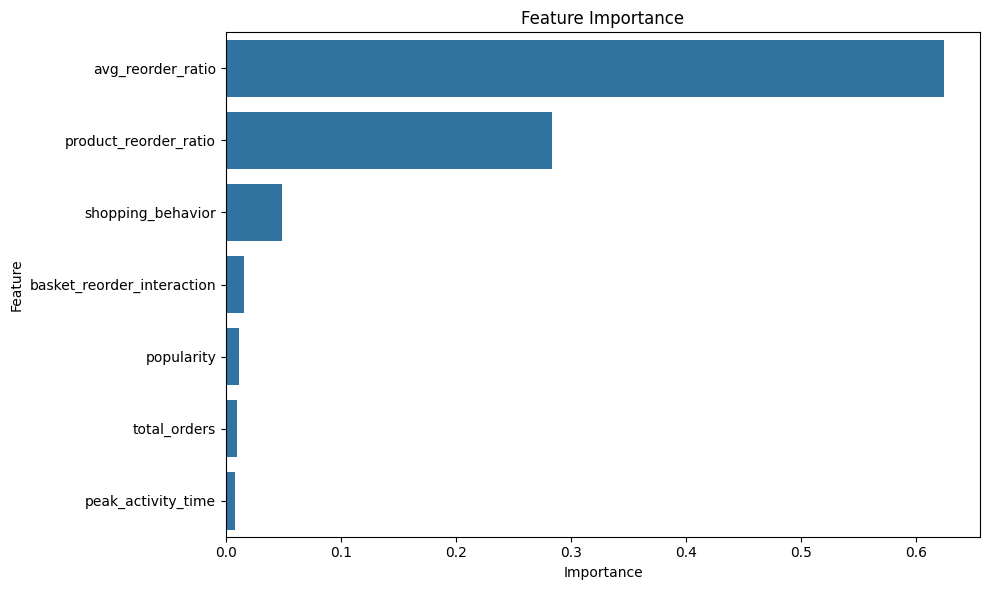

In [ ]:
# Feature Importance
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": best_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plotting Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()


In [ ]:
# Data Scaling and Balancing with SMOTE

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Scaling data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

Class distribution after SMOTE:
reordered
0    3827326
1    3827326
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Adding polynomial and interaction features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X_resampled)

# Updating feature names to include polynomial terms
poly_features = poly.get_feature_names_out(features)

# Converting back to a DataFrame for easier handling
X_poly_df = pd.DataFrame(X_poly, columns=poly_features)

# Adding original target
X_poly_df['reordered'] = y_resampled


In [ ]:
import numpy as np

# Applying log transformation to specific features
X_poly_df["log_popularity"] = np.log1p(X_poly_df["popularity"])
X_poly_df["log_total_orders"] = np.log1p(X_poly_df["total_orders"])

# Dropping the original features if they are no longer needed
X_poly_df.drop(["popularity", "total_orders"], axis=1, inplace=True)


In [ ]:
# Train-test split with transformed features
X_train, X_test, y_train, y_test = train_test_split(
    X_poly_df.drop("reordered", axis=1),
    X_poly_df["reordered"],
    test_size=0.2,
    random_state=42
)

# Training the model
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# Evaluation
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")


Fitting 3 folds for each of 25 candidates, totalling 75 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:54:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.69      0.72    766000
           1       0.72      0.78      0.75    764931

    accuracy                           0.74   1530931
   macro avg       0.74      0.74      0.74   1530931
weighted avg       0.74      0.74      0.74   1530931

ROC-AUC Score: 0.8168


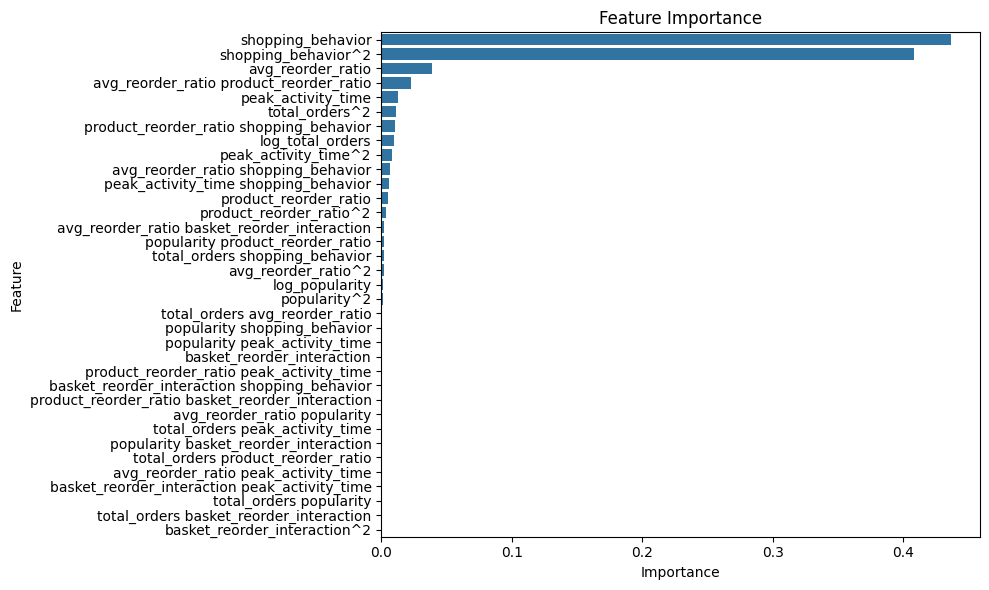

In [ ]:
# Feature Importance
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": best_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plotting Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

# Selecting top N features
top_features = importance_df.head(3)["Feature"].tolist()
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]


In [ ]:
# Identifying low-importance features
low_importance_features = importance_df[importance_df["Importance"] < 0.01]["Feature"].tolist()
print(f"Low-importance features to drop: {low_importance_features}")

Low-importance features to drop: ['log_total_orders', 'peak_activity_time^2', 'avg_reorder_ratio shopping_behavior', 'peak_activity_time shopping_behavior', 'product_reorder_ratio', 'product_reorder_ratio^2', 'avg_reorder_ratio basket_reorder_interaction', 'popularity product_reorder_ratio', 'total_orders shopping_behavior', 'avg_reorder_ratio^2', 'log_popularity', 'popularity^2', 'total_orders avg_reorder_ratio', 'popularity shopping_behavior', 'popularity peak_activity_time', 'basket_reorder_interaction', 'product_reorder_ratio peak_activity_time', 'basket_reorder_interaction shopping_behavior', 'product_reorder_ratio basket_reorder_interaction', 'avg_reorder_ratio popularity', 'total_orders peak_activity_time', 'popularity basket_reorder_interaction', 'total_orders product_reorder_ratio', 'avg_reorder_ratio peak_activity_time', 'basket_reorder_interaction peak_activity_time', 'total_orders popularity', 'total_orders basket_reorder_interaction', 'basket_reorder_interaction^2']


In [ ]:
# Dropping low-importance features from training and testing datasets
X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = X_test.drop(columns=low_importance_features)

In [ ]:
# Re-training the model with reduced features
random_search.fit(X_train_reduced, y_train)
best_model_reduced = random_search.best_estimator_

# Predictions
y_pred_reduced = best_model_reduced.predict(X_test_reduced)
y_pred_proba_reduced = best_model_reduced.predict_proba(X_test_reduced)[:, 1]

# Evaluating performance
print("Classification Report (Reduced Features):")
print(classification_report(y_test, y_pred_reduced))
print(f"ROC-AUC Score (Reduced Features): {roc_auc_score(y_test, y_pred_proba_reduced):.4f}")


Fitting 3 folds for each of 25 candidates, totalling 75 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:12:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report (Reduced Features):
              precision    recall  f1-score   support

           0       0.73      0.68      0.71    766000
           1       0.70      0.75      0.73    764931

    accuracy                           0.72   1530931
   macro avg       0.72      0.72      0.72   1530931
weighted avg       0.72      0.72      0.72   1530931

ROC-AUC Score (Reduced Features): 0.7942


In [ ]:
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier

# Initializing the XGBoost model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")

# Initializing RFE
rfe = RFE(estimator=xgb, n_features_to_select=15, step=1)  # Adjust number of features to select
rfe.fit(X_train, y_train)

# Extracting selected features
selected_features = X_train.columns[rfe.support_]
print(f"Selected features: {selected_features}")

# Training XGBoost using only selected features
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]

xgb.fit(X_train_rfe, y_train)
y_pred_rfe = xgb.predict(X_test_rfe)
y_pred_proba_rfe = xgb.predict_proba(X_test_rfe)[:, 1]

# Evaluating RFE results
print("Classification Report (RFE):")
print(classification_report(y_test, y_pred_rfe))
print(f"ROC-AUC Score (RFE): {roc_auc_score(y_test, y_pred_proba_rfe):.4f}")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:16:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:17:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:18:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:19:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:20:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Selected features: Index(['avg_reorder_ratio', 'product_reorder_ratio', 'peak_activity_time',
       'total_orders^2', 'avg_reorder_ratio^2',
       'avg_reorder_ratio product_reorder_ratio',
       'avg_reorder_ratio basket_reorder_interaction',
       'avg_reorder_ratio shopping_behavior', 'popularity^2',
       'popularity product_reorder_ratio', 'product_reorder_ratio^2',
       'product_reorder_ratio shopping_behavior', 'peak_activity_time^2',
       'peak_activity_time shopping_behavior', 'log_total_orders'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:32:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report (RFE):
              precision    recall  f1-score   support

           0       0.75      0.69      0.72    766000
           1       0.71      0.77      0.74    764931

    accuracy                           0.73   1530931
   macro avg       0.73      0.73      0.73   1530931
weighted avg       0.73      0.73      0.73   1530931

ROC-AUC Score (RFE): 0.8091


In [ ]:
!pip install shap --upgrade

Batch 1 processed in 42.07 seconds
Batch 2 processed in 42.33 seconds
Batch 3 processed in 41.50 seconds
Batch 4 processed in 41.99 seconds
Batch 5 processed in 42.31 seconds
Batch 6 processed in 41.56 seconds
Batch 7 processed in 40.75 seconds
Batch 8 processed in 41.47 seconds
Batch 9 processed in 41.47 seconds
Batch 10 processed in 41.33 seconds
Batch 11 processed in 41.45 seconds
Batch 12 processed in 41.38 seconds
Batch 13 processed in 41.03 seconds
Batch 14 processed in 41.65 seconds
Batch 15 processed in 41.18 seconds
Batch 16 processed in 41.04 seconds
Batch 17 processed in 40.91 seconds
Batch 18 processed in 41.36 seconds
Batch 19 processed in 42.26 seconds
Batch 20 processed in 41.87 seconds
Batch 21 processed in 42.56 seconds
Batch 22 processed in 42.43 seconds
Batch 23 processed in 42.17 seconds
Batch 24 processed in 41.84 seconds
Batch 25 processed in 41.07 seconds
Batch 26 processed in 41.73 seconds
Batch 27 processed in 41.54 seconds
Batch 28 processed in 41.31 seconds
B

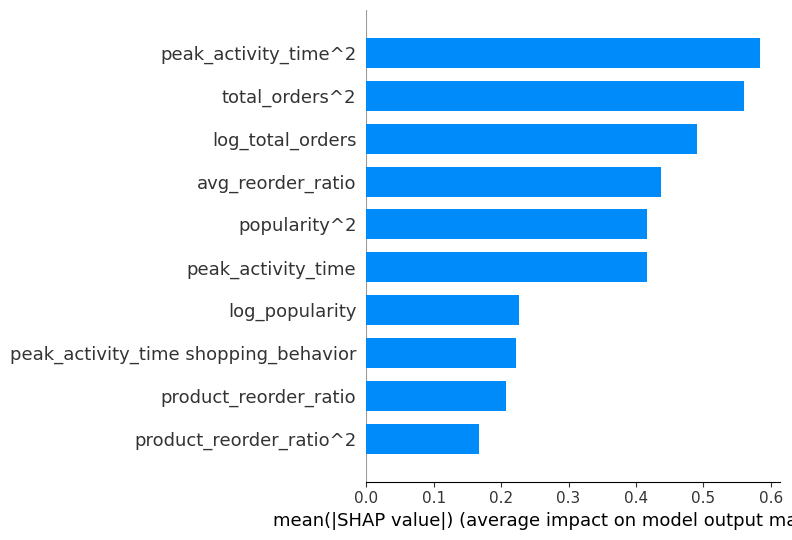

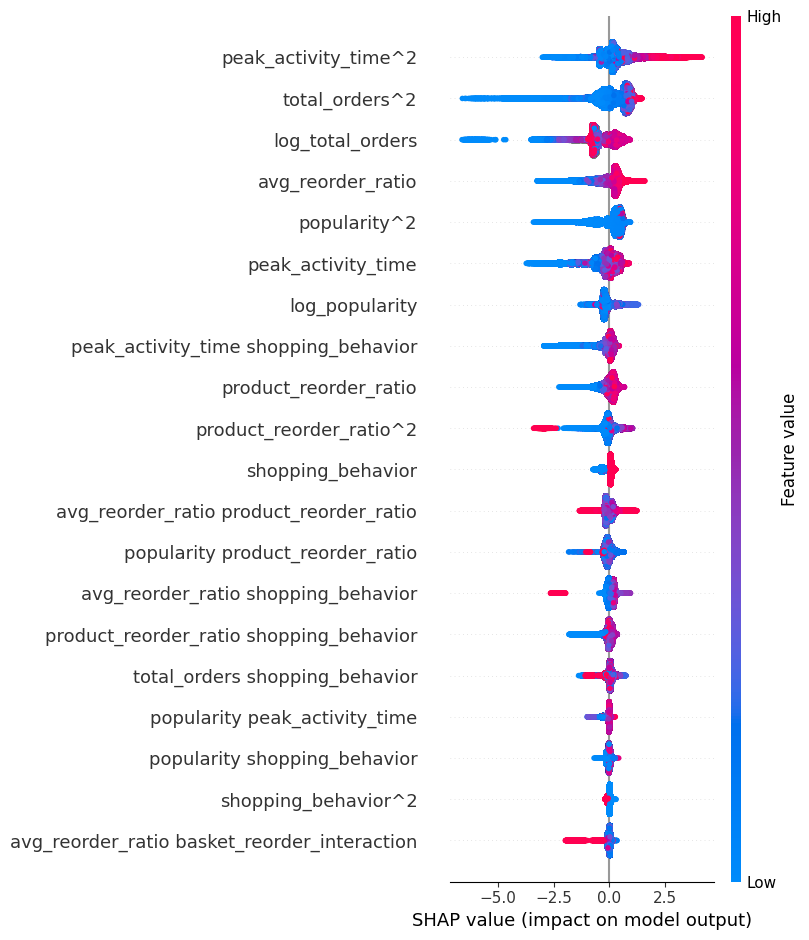

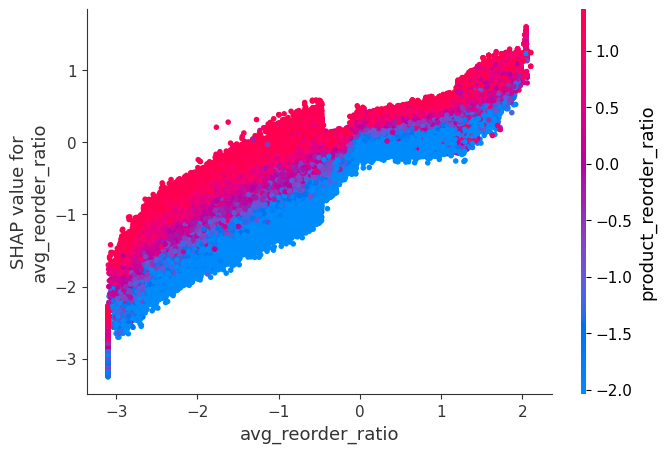

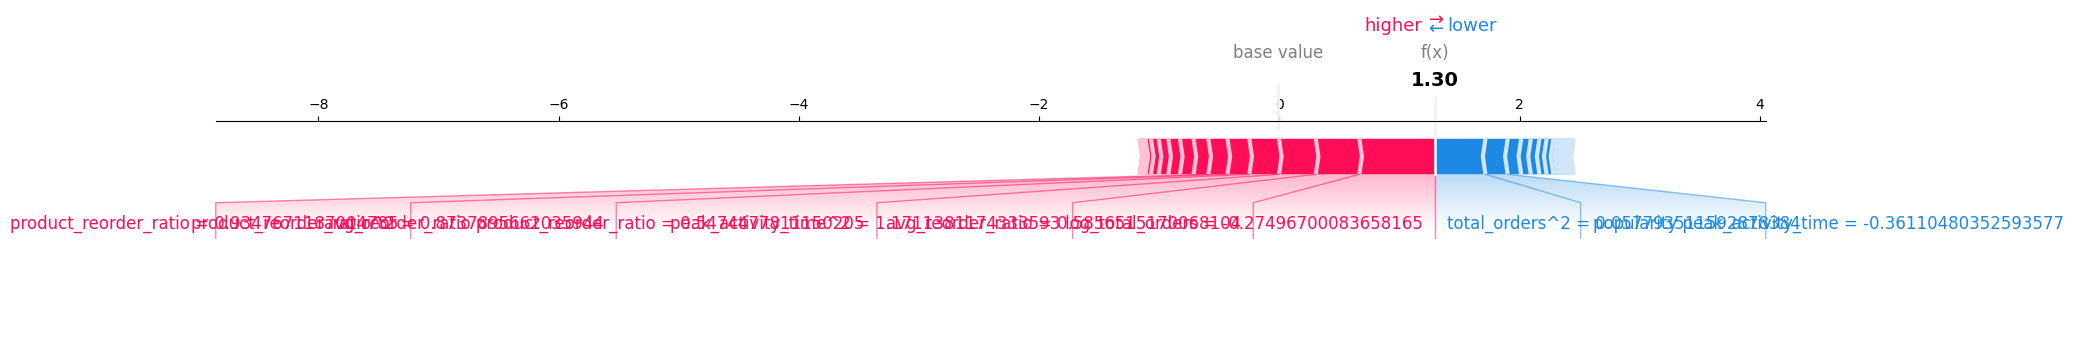

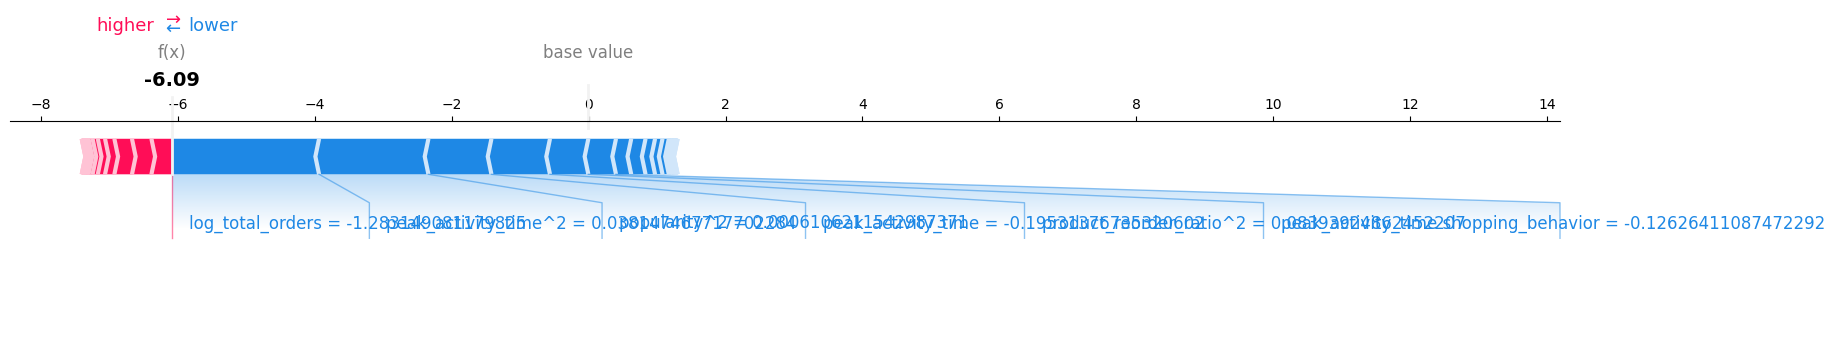

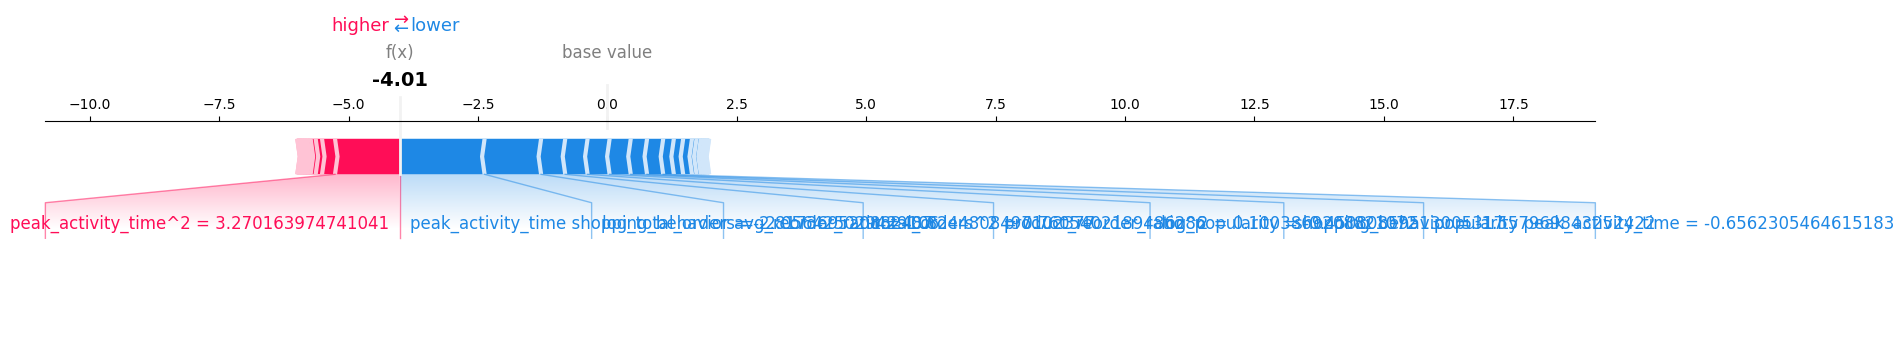

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import time

# Initializing SHAP explainer with GPU acceleration
explainer = explainer = shap.TreeExplainer(best_model, feature_perturbation="tree_path_dependent", model_output="raw", approximate=True)

# Downsampling the dataset for initial debugging
X_test_sample = X_test.sample(n=20000, random_state=42)  # Adjustable

# Computing SHAP values in batches to handle large datasets efficiently
batch_size = 10000
shap_values_list = []

# Looping through batches with timing
for i in range(0, len(X_test), batch_size):
    batch = X_test.iloc[i:i + batch_size]
    start_time = time.time()
    shap_values_batch = explainer.shap_values(batch)
    shap_values_list.append(shap_values_batch)
    print(f"Batch {i // batch_size + 1} processed in {time.time() - start_time:.2f} seconds")

# Combining all SHAP values
shap_values = np.vstack(shap_values_list)

# Saving SHAP values for reuse
np.save("shap_values.npy", shap_values)

# Loading SHAP values for analysis

# Generating Summary Plot: Global feature importance (bar plot)
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)  # Displaying top 10 features

# Generating Detailed Summary Plot: Positive/negative contributions
shap.summary_plot(shap_values, X_test)

# Dependence Plot: Focus on specific feature (e.g., 'avg_reorder_ratio')
shap.dependence_plot("avg_reorder_ratio", shap_values, X_test)

# Generating Force Plots for individual predictions (limited to 3 examples)
for i in range(3):
    shap.force_plot(
        explainer.expected_value,
        shap_values[i, :],
        X_test.iloc[i, :],
        matplotlib=True
    )


In [ ]:
# Frequent Pattern Mining with FP-Growth

from pyspark.sql import functions as F
from pyspark.ml.fpm import FPGrowth

# Ensuring that items within each transaction are unique
transactions_df = transactions_df.withColumn(
    "items", F.array_distinct(F.col("items"))
)

# Initializing FP-Growth
fp_growth = FPGrowth(itemsCol="items", minSupport=0.01, minConfidence=0.5)

# Fitting the model
model = fp_growth.fit(transactions_df)

# Frequent Itemsets
frequent_itemsets = model.freqItemsets
frequent_itemsets.show()

# Association Rules
association_rules = model.associationRules
association_rules.show()

# Predictions
predictions = model.transform(transactions_df)
predictions.show()

+--------------+------+
|         items|  freq|
+--------------+------+
|       [48935]|631818|
|       [37067]|491108|
|[37067, 48935]|143865|
|       [13176]|379450|
|[13176, 48935]|126047|
|       [46979]|315243|
|[46979, 13176]| 57569|
|[46979, 37067]| 63834|
|[46979, 48935]| 95626|
|       [47209]|286471|
|[47209, 13176]| 72817|
|[47209, 37067]| 55157|
|[47209, 46979]| 53207|
|[47209, 48935]| 95262|
|       [49118]|286067|
|[49118, 13176]| 47789|
|[49118, 47209]| 50177|
|[49118, 37067]| 52142|
|[49118, 46979]| 64827|
|[49118, 48935]| 73796|
+--------------+------+
only showing top 20 rows

+----------+----------+------------------+-----------------+------------------+
|antecedent|consequent|        confidence|             lift|           support|
+----------+----------+------------------+-----------------+------------------+
|   [48275]|   [48935]|0.5231406351148828|2.661886119404446|0.0183500592715033|
+----------+----------+------------------+-----------------+------------------

In [ ]:
# Mapping Frequent Itemsets to Product Names

frequent_itemsets_names = (
    frequent_itemsets
    .withColumn("item", F.explode(F.col("items")))  # Explode the items array to individual rows
    .join(products_df, F.col("item") == products_df["product_id"], "left")  # Join on product_id
    .groupBy("items", "freq")  # Group by the original items and frequency
    .agg(F.collect_list("product_name_ref").alias("product_names"))  # Aggregate product names into a list
)

frequent_itemsets_names.show(truncate=False)

+--------------+------+--------------------------------------+
|items         |freq  |product_names                         |
+--------------+------+--------------------------------------+
|[42736]       |57298 |[Unsalted Butter]                     |
|[34969]       |54409 |[Red Vine Tomato]                     |
|[29487]       |69445 |[Roma Tomato]                         |
|[46654]       |38556 |[Organic Grade A Large Brown Eggs]    |
|[49118, 13176]|47789 |[Cilantro, Bag of Organic Bananas]    |
|[28842]       |45530 |[Bunched Cilantro]                    |
|[49352]       |35737 |[Natural Extra Sharp Cheddar Cheese]  |
|[47209, 37067]|55157 |[Organic Hass Avocado, Organic Banana]|
|[16759]       |36433 |[Organic Carrot Bunch]                |
|[43961]       |55371 |[Organic Peeled Whole Baby Carrots]   |
|[49628]       |47990 |[Yoghurt Blueberry]                   |
|[41950]       |64289 |[Organic Tomato Cluster]              |
|[49118, 46979]|64827 |[Cilantro, Asparagus]           

In [ ]:
# Converting product_names to a string representation
frequent_itemsets_pandas["product_names"] = frequent_itemsets_pandas["product_names"].apply(
    lambda x: ", ".join(x) if isinstance(x, (list, np.ndarray)) else str(x)
)

# Displaying the first 10 rows as a clean table using Pandas' built-in formatting
print(frequent_itemsets_pandas.head(10).to_string(index=False))

         items  freq                        product_names
       [42736] 57298                      Unsalted Butter
       [34969] 54409                      Red Vine Tomato
       [29487] 69445                          Roma Tomato
       [46654] 38556     Organic Grade A Large Brown Eggs
[49118, 13176] 47789     Cilantro, Bag of Organic Bananas
       [28842] 45530                     Bunched Cilantro
       [49352] 35737   Natural Extra Sharp Cheddar Cheese
[47209, 37067] 55157 Organic Hass Avocado, Organic Banana
       [16759] 36433                 Organic Carrot Bunch
       [43961] 55371    Organic Peeled Whole Baby Carrots


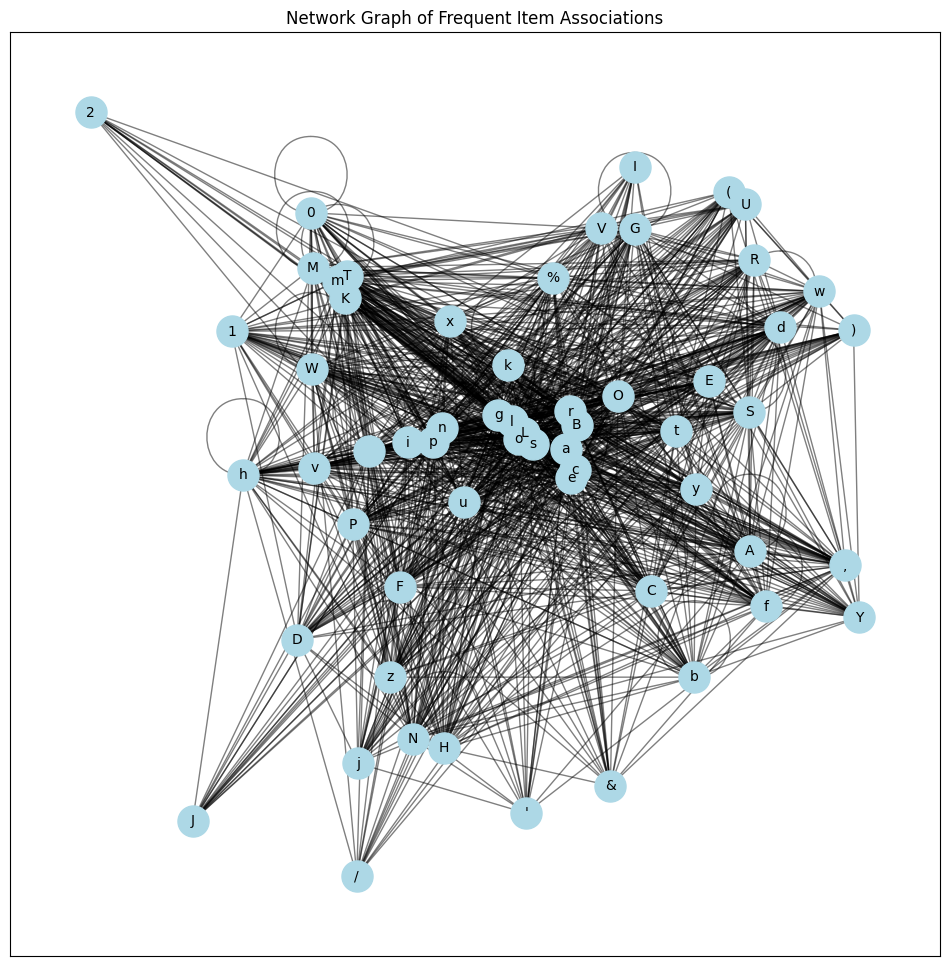

In [ ]:
# Visualizing Item Associations with a Network Graph

import networkx as nx

# Creating a graph
G = nx.Graph()

# Adding edges for top itemsets with >1 item
for _, row in frequent_itemsets_pandas.iterrows():
    if len(row["product_names"]) > 1:
        for i, item_a in enumerate(row["product_names"]):
            for item_b in row["product_names"][i + 1:]:
                G.add_edge(item_a, item_b, weight=row["freq"])

# Creating graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="lightblue")
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Network Graph of Frequent Item Associations")
plt.show()


In [ ]:
!pip install pyvis

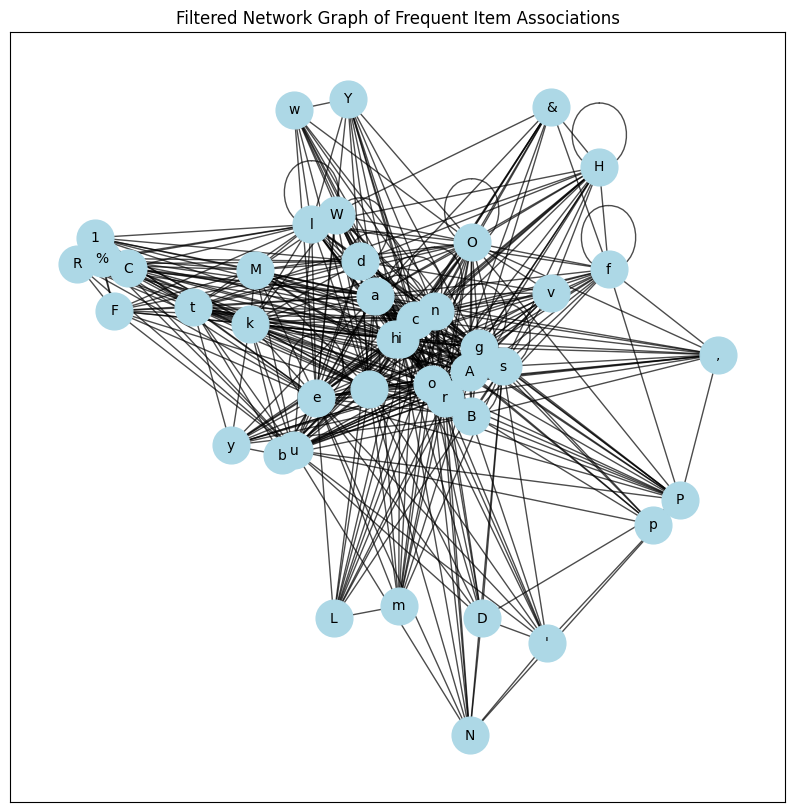

In [ ]:
# Filtering itemsets for those with a high frequency
threshold_freq = frequent_itemsets_pandas["freq"].quantile(0.90)  # Top 10% by frequency
filtered_itemsets = frequent_itemsets_pandas[frequent_itemsets_pandas["freq"] >= threshold_freq]

# Creating a graph from the filtered itemsets
G = nx.Graph()
for _, row in filtered_itemsets.iterrows():
    if len(row["product_names"]) > 1:
        for i, item_a in enumerate(row["product_names"]):
            for item_b in row["product_names"][i + 1:]:
                G.add_edge(item_a, item_b, weight=row["freq"])

# Creating filtered graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=0.6)
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="lightblue")
nx.draw_networkx_edges(G, pos, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Filtered Network Graph of Frequent Item Associations")
plt.show()


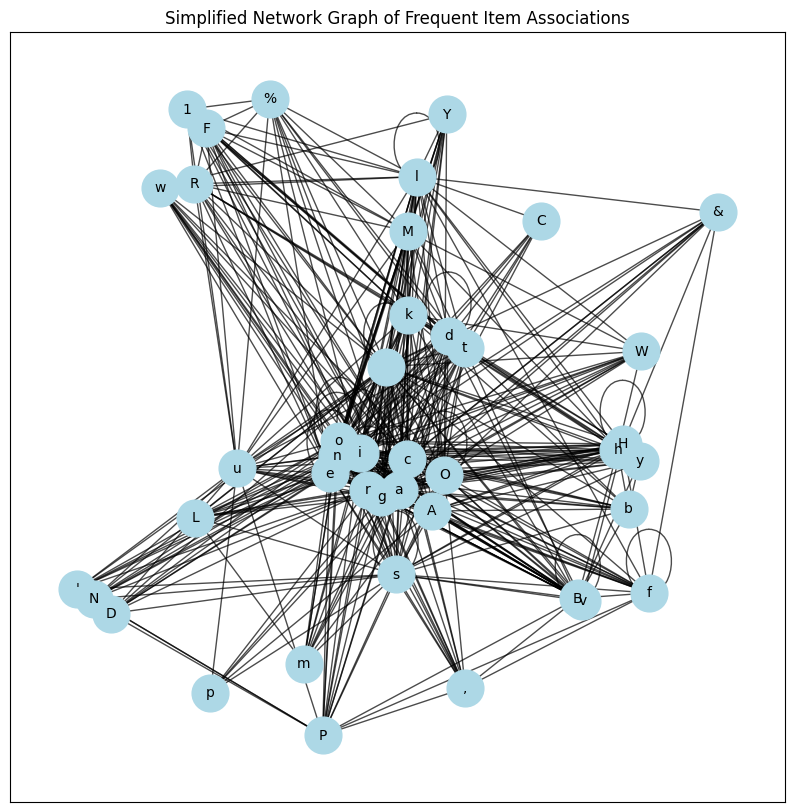

Number of nodes: 42
Number of edges: 456


In [ ]:
# Filtering to the top 50 nodes with the highest degree
G = nx.Graph()
for _, row in filtered_itemsets.iterrows():
    if len(row["product_names"]) > 1:
        for i, item_a in enumerate(row["product_names"]):
            for item_b in row["product_names"][i + 1:]:
                G.add_edge(item_a, item_b, weight=row["freq"])


top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:50]
filtered_graph = G.subgraph([node for node, _ in top_nodes])

# Visualizing simplified graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(filtered_graph, k=0.6)
nx.draw_networkx_nodes(filtered_graph, pos, node_size=700, node_color="lightblue")
nx.draw_networkx_edges(filtered_graph, pos, alpha=0.7)
nx.draw_networkx_labels(filtered_graph, pos, font_size=10)
plt.title("Simplified Network Graph of Frequent Item Associations")
plt.show()

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

In [ ]:
!pip install scikit-optimize

In [ ]:
from skopt import BayesSearchCV

In [ ]:
# Bayesian Optimization and Evaluation of XGBoost Classifier

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Ensuring data is scaled for XGBoost
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Defining parameter space
param_space = {
    "learning_rate": (0.01, 0.3, 'log-uniform'),
    "max_depth": (3, 10),
    "n_estimators": (50, 500),
    "subsample": (0.6, 1.0),
    "colsample_bytree": (0.6, 1.0)
}

# Bayesian search
bayes_search = BayesSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"),
    search_spaces=param_space,
    scoring="roc_auc",
    n_iter=25,  # Reduced iterations for efficiency
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fitting with scaled data
bayes_search.fit(X_train_scaled, y_train)

# Best model and evaluation
best_bayes_model = bayes_search.best_estimator_
y_pred_bayes = best_bayes_model.predict(X_test_scaled)
y_pred_bayes_proba = best_bayes_model.predict_proba(X_test_scaled)[:, 1]

print("Bayesian Optimized Model Classification Report:")
print(classification_report(y_test, y_pred_bayes))
print(f"Bayesian Optimized Model ROC-AUC Score: {roc_auc_score(y_test, y_pred_bayes_proba):.4f}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:10:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Bayesian Optimized Model Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.70      0.72    382859
           1       0.71      0.74      0.73    381917

    accuracy                           0.72    764776
   macro avg       0.72      0.72      0.72    764776
weighted avg       0.72      0.72      0.72    764776

Bayesian Optimized Model ROC-AUC Score: 0.8005


In [ ]:
feature_names = X_train.columns

In [ ]:
# Retrieving feature importance
booster = best_bayes_model.get_booster()

# Mapping feature indices (e.g., f0, f1) to their original names
feature_map = {f"f{i}": feature for i, feature in enumerate(feature_names)}

# Renaming features in the plot
importance = booster.get_score(importance_type="weight")
importance_named = {feature_map[k]: v for k, v in importance.items()}

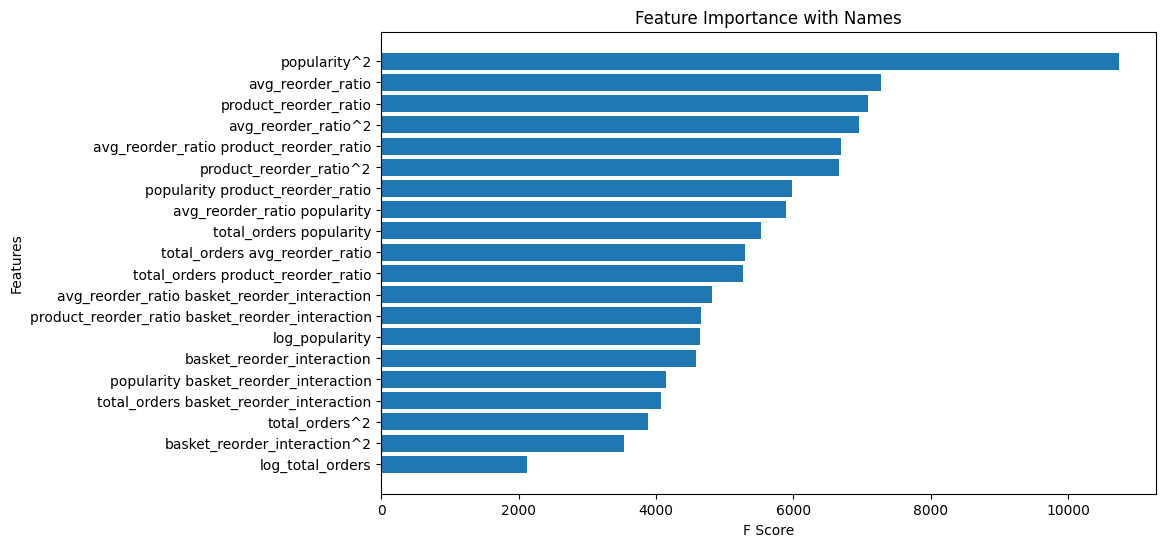

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Converting importance to a DataFrame
importance_df = pd.DataFrame(list(importance_named.items()), columns=["Feature", "Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("F Score")
plt.ylabel("Features")
plt.title("Feature Importance with Names")
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.show()

In [ ]:
!pip install tensorflow

In [ ]:
!pip show tensorflow

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
# Neural Collaborative Filtering with Hyperparameter Tuning

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from keras_tuner import RandomSearch  # For hyperparameter tuning
import numpy as np

# Step 1: Preparing data
user_ids = als_df.select("user_id").rdd.flatMap(lambda x: x).collect()
product_ids = als_df.select("product_id").rdd.flatMap(lambda x: x).collect()
ratings = als_df.select("rating").rdd.flatMap(lambda x: x).collect()

# Normalizing IDs
user_mapping = {id_: idx for idx, id_ in enumerate(np.unique(user_ids))}
product_mapping = {id_: idx for idx, id_ in enumerate(np.unique(product_ids))}

user_ids_mapped = [user_mapping[id_] for id_ in user_ids]
product_ids_mapped = [product_mapping[id_] for id_ in product_ids]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    list(zip(user_ids_mapped, product_ids_mapped)), ratings, test_size=0.2, random_state=42
)

# Step 2: Defining the model with regularization and dropout
def build_model(hp):
    latent_dim = hp.Int("latent_dim", min_value=16, max_value=64, step=16)
    dense_units = hp.Choice("dense_units", values=[64, 128, 256])
    dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)

    # User Embedding
    user_input = Input(shape=(1,))
    user_embedding = Embedding(input_dim=len(user_mapping), output_dim=latent_dim)(user_input)
    user_vec = Flatten()(user_embedding)

    # Product Embedding
    product_input = Input(shape=(1,))
    product_embedding = Embedding(input_dim=len(product_mapping), output_dim=latent_dim)(product_input)
    product_vec = Flatten()(product_embedding)

    # Concatenating and Hidden Layers
    concat = Concatenate()([user_vec, product_vec])
    hidden = Dense(dense_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(concat)
    hidden = Dropout(dropout_rate)(hidden)
    hidden = Dense(dense_units // 2, activation='relu')(hidden)
    output = Dense(1, activation='sigmoid')(hidden)

    # Model Compilation
    model = Model([user_input, product_input], output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 3: Hyperparameter Tuning
tuner = RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    directory="ncf_tuning",
    project_name="ncf"
)

tuner.search(
    [np.array([x[0] for x in X_train]), np.array([x[1] for x in X_train])],
    np.array(y_train),
    epochs=5,
    validation_split=0.1,
    batch_size=256,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)],
)

# Getting the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

# Step 4: Training the Best Model
history = model.fit(
    [np.array([x[0] for x in X_train]), np.array([x[1] for x in X_train])],
    np.array(y_train),
    batch_size=256,
    epochs=10,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)],
)

# Step 5: Predictions
y_pred = model.predict([np.array([x[0] for x in X_test]), np.array([x[1] for x in X_test])])
y_pred_binary = (y_pred > 0.5).astype(int)

# Step 6: Evaluating the Model
print("\nClassification Metrics:")
print(f"Precision: {precision_score(y_test, y_pred_binary):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_binary):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_binary):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred):.2f}")

# Evaluating RMSE
rmse = np.sqrt(np.mean((np.array(y_test) - y_pred.flatten())**2))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plotting Training History
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


Epoch 1/10
91222/91222 ━━━━━━━━━━━━━━━━━━━━ 294s 3ms/step - accuracy: 0.6392 - loss: 0.6353 - val_accuracy: 0.6491 - val_loss: 0.6277
Epoch 2/10
91222/91222 ━━━━━━━━━━━━━━━━━━━━ 289s 3ms/step - accuracy: 0.6561 - loss: 0.6212 - val_accuracy: 0.6491 - val_loss: 0.6275
Epoch 3/10
91222/91222 ━━━━━━━━━━━━━━━━━━━━ 288s 3ms/step - accuracy: 0.6626 - loss: 0.6152 - val_accuracy: 0.6480 - val_loss: 0.6286
Epoch 4/10
91222/91222 ━━━━━━━━━━━━━━━━━━━━ 288s 3ms/step - accuracy: 0.6684 - loss: 0.6093 - val_accuracy: 0.6472 - val_loss: 0.6298
Epoch 5/10
91222/91222 ━━━━━━━━━━━━━━━━━━━━ 287s 3ms/step - accuracy: 0.6739 - loss: 0.6033 - val_accuracy: 0.6435 - val_loss: 0.6332
Epoch 6/10
91222/91222 ━━━━━━━━━━━━━━━━━━━━ 287s 3ms/step - accuracy: 0.6792 - loss: 0.5974 - val_accuracy: 0.6409 - val_loss: 0.6355
Epoch 7/10
91222/91222 ━━━━━━━━━━━━━━━━━━━━ 287s 3ms/step - accuracy: 0.6836 - loss: 0.5920 - val_accuracy: 0.6403 - val_loss: 0.6371
Epoch 8/10
91222/91222 ━━━━━━━━━━━━━━━━━━━━ 287s 3ms/step - ac